## Classifier: this model will be responsible for predicting the status of persons if they have low/high stress.

### Dataset: https://www.kaggle.com/datasets/ziya07/mental-health-monitor-using-wearable-iot-sensors/data

What we have in dataset:

    - EEG Frequency Bands: The values of different EEG frequency bands (delta, theta, alpha, beta) that reflect brain activity.
    - GSR Values: Electrodermal activity representing emotional arousal or stress levels.
    - Cognitive State: The state of the individual's cognitive engagement (Focused, Distracted, or Cognitive Overload).
    - Emotional State: The individual's emotional state, categorized as Calm, Anxious, or Stressed.
    - Student Demographics: Information about the student, including their ID, age, gender, and the session type (study, test, relaxation).
    - Session Duration: The duration of the session in minutes.
    - Environmental Context: The context of the environment (e.g., Quiet Room, Library, or Home).
    - Preprocessed Features: Features obtained after data preprocessing, such as ICA components and mean GSR values.
    - Target: A binary label (1: High Stress, 0: Low Stress) representing the target mental health condition for classification purposes.

    - Steps:
        - Handling dataset:
            - Remapping stringified features into binary reprasantation
            - Normalizing dataset [if necessary]
            - Splitting dataset into [%70 Training] [%20 Testing] [%10 Validation]
            - Convert dataset into tensor

### Model Architecture: [1D CNN] : we will use fully connected layers (Neural Network):
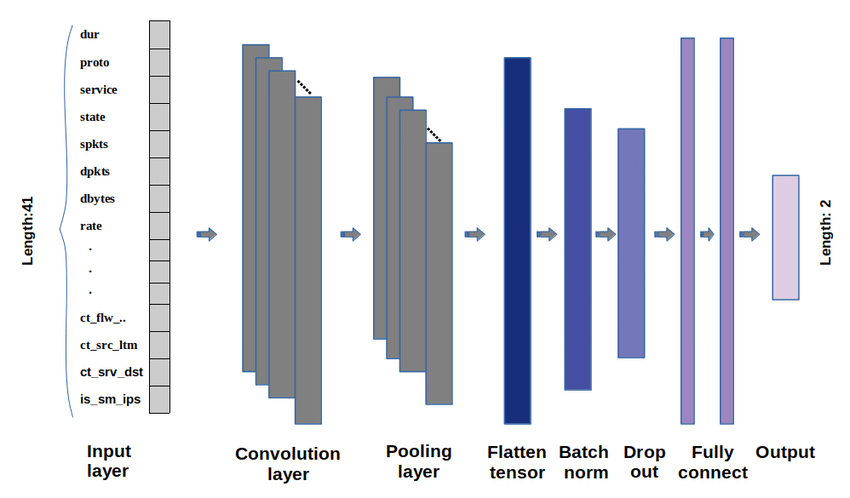

This architecture is inspired by the following paper:
(https://www.researchgate.net/figure/The-architecture-of-the-1D-CNN-simple-model-for-intrusion-detection-The-network-consists_fig1_340697891)
```
Input (GSR, EEG, HR ...)
   ↓
1D CNN (feature extraction)
   ↓
BatchNorm → ReLU → Dropout
   ↓
FullyConnecyedLayer → Softmax (32,1) -> Binary Classifer
```

##### Optimizer: SDG,
##### Loss Function: Binary Classification With Logits
##### Accuracy Function ```correct_ypreds / y_true * 100```

##### Training Loop: training step + validation step
##### Testing Model
##### Store the model into pth file
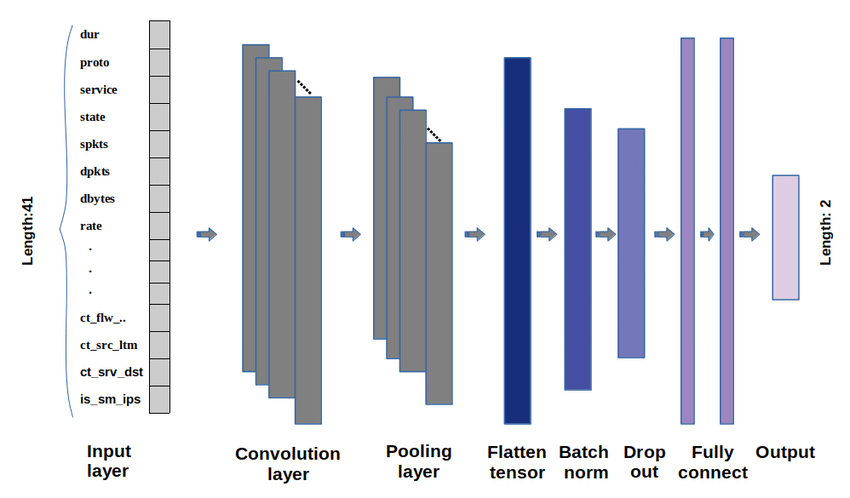

In [379]:
import pathlib
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchsummary import summary

In [380]:
dataset_path = pathlib.Path("datasets")

In [381]:
#Downloading Dataset from kaggle
import os
import requests
from zipfile import ZipFile

dataset_path.mkdir(exist_ok=True, parents=True)

url = "https://www.kaggle.com/api/v1/datasets/download/ziya07/mental-health-monitor-using-wearable-iot-sensors"
filename = "samples.zip"

with open(dataset_path / filename, "wb") as file:
    req = requests.get(url)
    file.write(req.content)

# extract archived file
with ZipFile(dataset_path / filename, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

os.remove(dataset_path / filename)

print("Dataset downloaded")

Dataset downloaded


In [382]:
# Read dataset using Pandas and convert it into numpy array
import pandas as pd

df = pd.read_csv(dataset_path / "mental_health_wearable_data.csv")
print(df.shape), print(df.columns)
df.transpose()

(500, 13)
Index(['Timestamp', 'EEG_Frequency_Bands', 'GSR_Values', 'Cognitive_State',
       'Emotional_State', 'Student_ID', 'Age', 'Gender', 'Session_Type',
       'Duration (minutes)', 'Environmental_Context', 'Preprocessed_Features',
       'Target'],
      dtype='object')


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Timestamp,2025-01-01 10:00:00,2025-01-01 10:05:00,2025-01-01 10:10:00,2025-01-01 10:15:00,2025-01-01 10:20:00,2025-01-01 10:25:00,2025-01-01 10:30:00,2025-01-01 10:35:00,2025-01-01 10:40:00,2025-01-01 10:45:00,...,2025-01-03 02:50:00,2025-01-03 02:55:00,2025-01-03 03:00:00,2025-01-03 03:05:00,2025-01-03 03:10:00,2025-01-03 03:15:00,2025-01-03 03:20:00,2025-01-03 03:25:00,2025-01-03 03:30:00,2025-01-03 03:35:00
EEG_Frequency_Bands,"[7.400574384984986, 5.621240954745124, 4.62440...","[1.6898477932146672, 7.2616994947041125, 1.106...","[0.2693319401287453, 8.909349692334239, 7.2444...","[6.080175212895389, 6.387554935291081, 9.09906...","[5.9007231710422525, 8.301537594579075, 4.4649...","[3.1206030584955933, 1.6685686761001417, 7.465...","[0.32362087812654927, 6.935561342957376, 4.023...","[5.669198183202212, 2.8975571629980768, 9.7467...","[4.627461612306435, 5.593286698252362, 1.10265...","[6.02967633134913, 9.523038037888876, 5.620155...",...,"[4.500500748413897, 2.0958304863579738, 2.1948...","[0.9260599866707675, 3.423250482136294, 1.5092...","[8.417214210421541, 3.1663625170712892, 0.7993...","[2.084568730609684, 6.661707880038761, 2.23720...","[1.215992613709782, 6.448828924500216, 3.76917...","[3.647165756391917, 8.61091886999731, 3.504486...","[4.626751274540835, 4.04265177758583, 1.920792...","[1.954111434157224, 2.8449169807263375, 7.6986...","[0.08431355418299535, 6.984096761771843, 9.216...","[7.811986264650325, 8.340740882178983, 7.65929..."
GSR_Values,1.376494,0.084319,0.895629,0.386398,1.186898,1.397812,1.952754,1.327385,0.929081,1.767935,...,1.929459,1.998284,0.043791,1.525601,1.262274,0.063332,1.157298,1.183166,0.674164,1.841824
Cognitive_State,Distracted,Focused,Cognitive Overload,Focused,Focused,Cognitive Overload,Cognitive Overload,Distracted,Cognitive Overload,Cognitive Overload,...,Cognitive Overload,Distracted,Distracted,Cognitive Overload,Focused,Focused,Cognitive Overload,Cognitive Overload,Distracted,Cognitive Overload
Emotional_State,Anxious,Stressed,Anxious,Anxious,Anxious,Stressed,Anxious,Calm,Stressed,Stressed,...,Anxious,Stressed,Calm,Calm,Anxious,Calm,Anxious,Calm,Anxious,Calm
Student_ID,151,150,173,171,131,154,151,166,147,152,...,171,171,147,121,124,172,180,116,186,123
Age,19,20,24,22,22,19,22,19,24,22,...,18,19,22,19,20,24,22,20,20,22
Gender,Female,Male,Male,Male,Female,Male,Female,Female,Female,Female,...,Female,Male,Male,Male,Male,Male,Male,Male,Female,Female
Session_Type,Study,Test,Test,Relaxation,Relaxation,Study,Test,Test,Test,Test,...,Relaxation,Test,Test,Relaxation,Test,Test,Relaxation,Study,Relaxation,Study
Duration (minutes),43,49,56,48,57,33,36,39,46,36,...,49,55,54,31,35,32,31,37,37,33


In [383]:
import ast
import time
from datetime import datetime


def parse_list(x):
    try:
        return list(map(float, ast.literal_eval(x)))
    except:
        return None


def avg_list(x):
    return sum(x) / len(x)


def ParseTimestamp(x):
    start_date = datetime.fromisoformat(x)
    return time.mktime(start_date.timetuple())

In [384]:
### Remapping & cleaning

# Gender → 0/1
df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})

# EEG list + average
df["EEG_list"] = df["EEG_Frequency_Bands"].apply(
    lambda x: parse_list(x) if isinstance(x, str) and "[" in x else None
)
df["EEG_avg"] = df["EEG_list"].apply(
    lambda x: avg_list(x) if isinstance(x, list) and len(x) > 0 else None
)

# Preprocessed_Features → x1, x2
df["Preprocessed_Features"] = df["Preprocessed_Features"].apply(
    lambda x: parse_list(x) if isinstance(x, str) and "(" in x else None
)
df[["x1", "x2"]] = pd.DataFrame(df["Preprocessed_Features"].tolist(), index=df.index)


df = df.drop([
    "Preprocessed_Features",
    "EEG_Frequency_Bands",
    "EEG_list",
    "Timestamp",
    "Student_ID",
    "Duration (minutes)",
    "Emotional_State",
    "Session_Type",
    "Cognitive_State",
    "Environmental_Context",
], axis=1)

df.head()


,GSR_Values,Age,Gender,Target,EEG_avg,x1,x2
0,1.376494,19,0,0,6.022110,0.092070,0.362187
1,0.084319,20,1,1,4.028793,0.663030,0.165350
2,0.895629,24,1,1,5.280939,0.010578,0.200443
3,0.386398,22,1,1,6.626498,0.292492,0.877307
4,1.186898,22,0,0,5.310230,0.767063,0.565267


In [385]:
feature_cols = ["EEG_avg", "GSR_Values", "Age", "Gender", "x1", "x2"]

X_df = df[["x1", "x2"]]

X_df = df[feature_cols]
y = df["Target"].values.astype("float32")
X = X_df.values.astype("float32")

num_features = X.shape[1]
X[0], y[0]

(array([ 6.02211   ,  1.3764943 , 19.        ,  0.        ,  0.09206977,
         0.36218727], dtype=float32),
 np.float32(0.0))

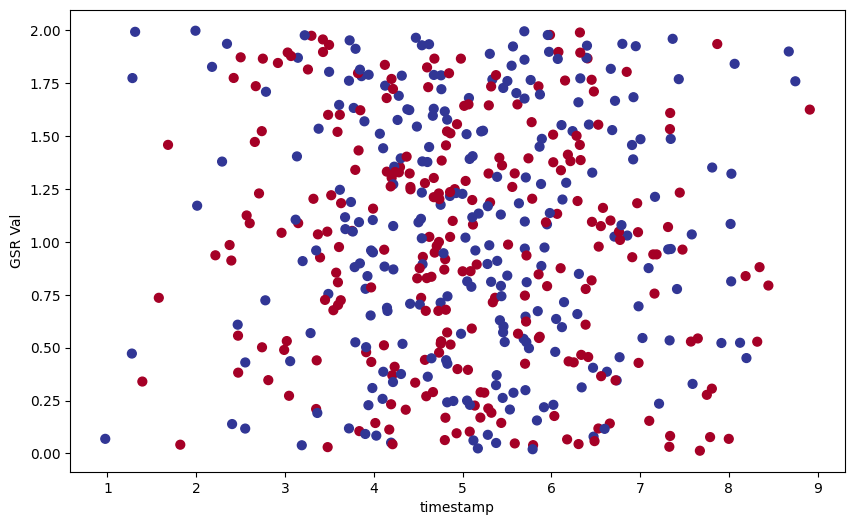

In [386]:
# plotting

import matplotlib.pyplot as plt


def plot_data(x=X, labels=y):
    plt.figure(figsize=(10, 6))
    plt.scatter(x[:, 0], x[:, 1], c=labels, cmap="RdYlBu", s=40)
    plt.xlabel("timestamp")
    plt.ylabel("GSR Val")


plot_data()

In [387]:
df.corr()

,GSR_Values,Age,Gender,Target,EEG_avg,x1,x2
GSR_Values,1.000000,-0.007882,-0.015657,0.074513,-0.047080,-0.048573,-0.038045
Age,-0.007882,1.000000,-0.003146,-0.066927,-0.039264,0.013800,0.009144
Gender,-0.015657,-0.003146,1.000000,-0.020102,0.007770,0.002900,-0.054130
Target,0.074513,-0.066927,-0.020102,1.000000,0.027040,-0.047106,-0.035569
EEG_avg,-0.047080,-0.039264,0.007770,0.027040,1.000000,0.032240,-0.018562
x1,-0.048573,0.013800,0.002900,-0.047106,0.032240,1.000000,-0.007901
x2,-0.038045,0.009144,-0.054130,-0.035569,-0.018562,-0.007901,1.000000


In [388]:
## Now let's split dataset
idx = int(len(X) * 0.7)

train_X, train_y = X[:idx], y[:idx]
tmp_X, tmp_y = X[idx:], y[idx:]

tmp_idx = int(len(tmp_X) * 0.8)
test_X, test_y = tmp_X[:tmp_idx], tmp_y[:tmp_idx]
val_X, val_y = tmp_X[tmp_idx:], tmp_y[tmp_idx:]

len(train_X), len(test_X), len(val_X)

(350, 120, 30)

In [389]:
class WearableDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_ds = WearableDataset(train_X, train_y)
test_ds = WearableDataset(test_X, test_y)
val_ds = WearableDataset(val_X, val_y)

train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=False)
val_loader = DataLoader(dataset=val_ds, shuffle=False)
test_loader = DataLoader(dataset=test_ds, shuffle=False)

len(train_loader), len(test_loader), len(val_loader)

(11, 120, 30)

In [390]:
## agnostic code to detect processor device
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
device

'mps'

In [391]:
### Now let's create model architecture
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
        )

    def forward(self, x):
        return self.net(x)

class StressCNN1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = ConvBlock(in_ch=1, out_ch=32)
        self.conv_block2 = ConvBlock(in_ch=32, out_ch=64)

        flattened_dim = 64 * num_features

        self.fc = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=flattened_dim, out_features=32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.LazyLinear(out_features=1)
        )

    def forward(self, x):
        x = x.unsqueeze(dim=1)  #[B, C, L] I've added channel dimension in position 1
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        return self.fc(x).squeeze(1)


class StressMLP(nn.Module):
    def __init__(self, num_features=num_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(16, 1)  # logits
        )

    def forward(self, x):
        # x: [B, num_features]
        return self.net(x).squeeze(1)  # [B]


In [392]:
model_01 = StressMLP()
model_01.state_dict()

OrderedDict([('net.0.weight',
              tensor([[ 0.0851,  0.2404, -0.3653, -0.3468, -0.2213, -0.3464],
                      [ 0.1071, -0.3356, -0.3502,  0.1064, -0.1992, -0.1379],
                      [-0.0791, -0.1957, -0.1498,  0.1985, -0.2634,  0.2306],
                      [-0.2620,  0.3629, -0.3942,  0.1809,  0.1498, -0.3374],
                      [-0.3949, -0.2811, -0.2780, -0.0756,  0.4041, -0.1128],
                      [-0.1575,  0.0800,  0.1597, -0.1238, -0.2718,  0.1560],
                      [ 0.1445, -0.3641, -0.1156,  0.0293, -0.2353,  0.2480],
                      [ 0.0629,  0.0628, -0.0443,  0.0840, -0.3843,  0.0577],
                      [-0.0554, -0.2566, -0.3168,  0.0642,  0.0643,  0.1630],
                      [ 0.3436, -0.2277, -0.3825,  0.0257, -0.0759,  0.2775],
                      [-0.1560,  0.2856,  0.1667, -0.1128, -0.2368, -0.3033],
                      [ 0.0464,  0.3560, -0.2723,  0.1779, -0.0351,  0.3216],
                      [ 0.3067, -0

In [393]:
summary(model_01, input_size=(num_features,), batch_size=32, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [32, 32]             224
              ReLU-2                   [32, 32]               0
           Dropout-3                   [32, 32]               0
            Linear-4                   [32, 16]             528
              ReLU-5                   [32, 16]               0
           Dropout-6                   [32, 16]               0
            Linear-7                    [32, 1]              17
Total params: 769
Trainable params: 769
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.00
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [394]:
## Loss function and Optimizer and Accuracy
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_01.parameters(), lr=1e-3)

In [395]:
def accuracy_fn(ytrue, ypreds):
    correct = torch.eq(ypreds,ytrue).sum().item()

    return correct / len(ytrue) * 100

In [396]:
from timeit import default_timer as timer


def train_step(model: nn.Module,
               dataloader: DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device):
    total_loss, total_acc, num_batches = 0.0, 0.0, 0

    model.to(device)
    model.train()
    start_timer = timer()

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device).float()

        # forward
        logits = model(X)

        # loss
        loss = loss_fn(logits, y)

        #acc
        with torch.inference_mode():
            ypreds = torch.round(torch.sigmoid(logits))

        acc = accuracy_fn(ytrue=y, ypreds=ypreds)

        # backward
        optimizer.zero_grad(set_to_none=True)

        loss.backward()
        optimizer.step()

        # metrics
        batch_loss = loss.item()
        total_loss += batch_loss
        total_acc += acc
        num_batches += 1

        if batch % 10 == 0:
            print(f"Batch {batch}: loss={batch_loss:.4f}, acc={acc:.4f}%")

    # averages
    total_loss /= num_batches
    total_acc /= num_batches
    end_timer = timer()
    total_time = end_timer - start_timer

    print(f"Epoch Train --> loss_avg={total_loss:.4f}, acc_avg={total_acc:.4f}% :: time={total_time:.2f}s")

    return {
        "loss": total_loss,
        "acc": total_acc,
        "time": total_time
    }

In [397]:
def test_step(model: nn.Module,
              dataloader: DataLoader,
              loss_fn=loss_fn,
              device=device,
              accuracy_fn=accuracy_fn,
              validation=False):
    total_loss, total_acc = 0.0, 0.0
    action = "Validating" if validation else "Testing"
    start_timer = timer()
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device).float()

            # forward
            logits = model(X)

            # loss
            loss = loss_fn(logits, y)

            #acc
            ypreds = torch.round(torch.sigmoid(logits))
            acc = accuracy_fn(ytrue=y, ypreds=ypreds)

            # metrics
            batch_loss = loss.item()

            total_loss += batch_loss
            total_acc += acc
            # print(f"{action} --> Loss: {loss:.2f} Acc: {acc:.2f}%")

    #calculate loss avg, accuracy avg
    total_loss /= len(dataloader)
    total_acc /= len(dataloader)

    end_timer = timer()
    total_time = end_timer - start_timer
    print(f"Epoch {action} --> loss_avg={total_loss:.4f} , acc_avg={total_acc:.4f}% :: time={total_time:.2f}s")

    return {
        "loss": total_loss,
        "acc": total_acc,
        "time": total_time
    }

In [398]:
## training Loop

from tqdm import tqdm

training_steps = []
validation_steps = []

epochs = 700

for epoch in tqdm(range(epochs), colour="green"):
    # ----- Training -----
    train_metrics = train_step(
        model=model_01,
        dataloader=train_loader,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        loss_fn=loss_fn,
        device=device
    )
    training_steps.append(train_metrics)

    # ----- Validation -----
    val_metrics = test_step(
        model=model_01,
        dataloader=val_loader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
        validation=True
    )
    validation_steps.append(val_metrics)

    model_dir = pathlib.Path("models")
    model_dir.mkdir(parents=True, exist_ok=True)

    torch.save(model_01.state_dict(), model_dir / "stress_cnn_1d.pth")

  0%|          | 0/700 [00:00<?, ?it/s]

Batch 0: loss=0.7357, acc=56.2500%
Batch 10: loss=0.7931, acc=46.6667%
Epoch Train --> loss_avg=0.8306, acc_avg=46.2879% :: time=0.04s
Epoch Validating --> loss_avg=0.6954 , acc_avg=46.6667% :: time=0.03s
Batch 0: loss=0.7339, acc=50.0000%
Batch 10: loss=0.8894, acc=33.3333%
Epoch Train --> loss_avg=0.7786, acc_avg=50.4735% :: time=0.02s


  0%|          | 2/700 [00:00<00:49, 13.96it/s]

Epoch Validating --> loss_avg=0.6755 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7708, acc=46.8750%
Batch 10: loss=0.7358, acc=56.6667%
Epoch Train --> loss_avg=0.7543, acc_avg=50.0379% :: time=0.03s
Epoch Validating --> loss_avg=0.6837 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7340, acc=50.0000%
Batch 10: loss=0.6762, acc=70.0000%
Epoch Train --> loss_avg=0.7448, acc_avg=52.9545% :: time=0.03s


  1%|          | 4/700 [00:00<00:44, 15.76it/s]

Epoch Validating --> loss_avg=0.6874 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.7060, acc=50.0000%
Batch 10: loss=0.6587, acc=56.6667%
Epoch Train --> loss_avg=0.7012, acc_avg=54.2992% :: time=0.02s
Epoch Validating --> loss_avg=0.6825 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7579, acc=53.1250%
Batch 10: loss=0.7144, acc=53.3333%
Epoch Train --> loss_avg=0.7445, acc_avg=50.5871% :: time=0.02s


  1%|          | 6/700 [00:00<00:40, 17.21it/s]

Epoch Validating --> loss_avg=0.6840 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.6922, acc=68.7500%
Batch 10: loss=0.7757, acc=43.3333%
Epoch Train --> loss_avg=0.7159, acc_avg=51.3826% :: time=0.02s
Epoch Validating --> loss_avg=0.6868 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.7315, acc=46.8750%
Batch 10: loss=0.7599, acc=50.0000%
Epoch Train --> loss_avg=0.7099, acc_avg=51.9886% :: time=0.02s


  1%|▏         | 9/700 [00:00<00:36, 18.87it/s]

Epoch Validating --> loss_avg=0.6977 , acc_avg=43.3333% :: time=0.02s
Batch 0: loss=0.6907, acc=53.1250%
Batch 10: loss=0.6830, acc=50.0000%
Epoch Train --> loss_avg=0.7125, acc_avg=50.5682% :: time=0.02s
Epoch Validating --> loss_avg=0.7006 , acc_avg=40.0000% :: time=0.02s
Batch 0: loss=0.7309, acc=53.1250%
Batch 10: loss=0.7433, acc=50.0000%
Epoch Train --> loss_avg=0.7066, acc_avg=53.1250% :: time=0.02s
Epoch Validating --> loss_avg=0.7009 , acc_avg=40.0000% :: time=0.03s
Batch 0: loss=0.7071, acc=37.5000%


  2%|▏         | 12/700 [00:00<00:34, 19.67it/s]

Batch 10: loss=0.7307, acc=40.0000%
Epoch Train --> loss_avg=0.7237, acc_avg=46.2500% :: time=0.02s
Epoch Validating --> loss_avg=0.6975 , acc_avg=40.0000% :: time=0.03s
Batch 0: loss=0.7788, acc=37.5000%
Batch 10: loss=0.7095, acc=60.0000%
Epoch Train --> loss_avg=0.7217, acc_avg=48.6364% :: time=0.02s
Epoch Validating --> loss_avg=0.6944 , acc_avg=46.6667% :: time=0.03s
Batch 0: loss=0.7097, acc=50.0000%
Batch 10: loss=0.7259, acc=53.3333%
Epoch Train --> loss_avg=0.7104, acc_avg=51.7235% :: time=0.02s
Epoch Validating --> loss_avg=0.6903 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7644, acc=43.7500%
Batch 10: loss=0.7145, acc=43.3333%
Epoch Train --> loss_avg=0.7218, acc_avg=46.5530% :: time=0.02s
Epoch Validating --> loss_avg=0.6879 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.7142, acc=46.8750%
Batch 10: loss=0.7336, acc=43.3333%
Epoch Train --> loss_avg=0.6965, acc_avg=49.9621% :: time=0.02s


  2%|▏         | 15/700 [00:00<00:33, 20.19it/s]

Epoch Validating --> loss_avg=0.6879 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6927, acc=59.3750%
Batch 10: loss=0.7246, acc=30.0000%
Epoch Train --> loss_avg=0.7093, acc_avg=50.1705% :: time=0.02s
Epoch Validating --> loss_avg=0.6890 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7191, acc=46.8750%
Batch 10: loss=0.7298, acc=43.3333%
Epoch Train --> loss_avg=0.6993, acc_avg=49.3939% :: time=0.02s


  3%|▎         | 18/700 [00:00<00:33, 20.45it/s]

Epoch Validating --> loss_avg=0.6906 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6909, acc=53.1250%
Batch 10: loss=0.6948, acc=56.6667%
Epoch Train --> loss_avg=0.7046, acc_avg=52.8788% :: time=0.02s
Epoch Validating --> loss_avg=0.6922 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.7243, acc=37.5000%
Batch 10: loss=0.6811, acc=56.6667%
Epoch Train --> loss_avg=0.6971, acc_avg=52.0265% :: time=0.02s
Epoch Validating --> loss_avg=0.6921 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7163, acc=46.8750%


  3%|▎         | 21/700 [00:01<00:32, 20.82it/s]

Batch 10: loss=0.7044, acc=53.3333%
Epoch Train --> loss_avg=0.6943, acc_avg=52.8598% :: time=0.02s
Epoch Validating --> loss_avg=0.6913 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.7412, acc=43.7500%
Batch 10: loss=0.6964, acc=53.3333%
Epoch Train --> loss_avg=0.7061, acc_avg=48.3144% :: time=0.02s
Epoch Validating --> loss_avg=0.6914 , acc_avg=56.6667% :: time=0.02s
Batch 0: loss=0.7155, acc=53.1250%
Batch 10: loss=0.6790, acc=63.3333%
Epoch Train --> loss_avg=0.6970, acc_avg=51.2121% :: time=0.02s
Epoch Validating --> loss_avg=0.6901 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6780, acc=56.2500%
Batch 10: loss=0.6744, acc=50.0000%
Epoch Train --> loss_avg=0.6855, acc_avg=52.5568% :: time=0.02s
Epoch Validating --> loss_avg=0.6906 , acc_avg=56.6667% :: time=0.02s
Batch 0: loss=0.7316, acc=31.2500%
Batch 10: loss=0.7296, acc=43.3333%
Epoch Train --> loss_avg=0.7046, acc_avg=48.5417% :: time=0.02s


  3%|▎         | 24/700 [00:01<00:31, 21.19it/s]

Epoch Validating --> loss_avg=0.6893 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6912, acc=50.0000%
Batch 10: loss=0.7407, acc=33.3333%
Epoch Train --> loss_avg=0.6963, acc_avg=52.4621% :: time=0.02s
Epoch Validating --> loss_avg=0.6871 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7259, acc=40.6250%
Batch 10: loss=0.7145, acc=50.0000%
Epoch Train --> loss_avg=0.7093, acc_avg=47.7273% :: time=0.02s


  4%|▍         | 27/700 [00:01<00:31, 21.50it/s]

Epoch Validating --> loss_avg=0.6866 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7143, acc=43.7500%
Batch 10: loss=0.7104, acc=36.6667%
Epoch Train --> loss_avg=0.6996, acc_avg=51.9129% :: time=0.02s
Epoch Validating --> loss_avg=0.6868 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.7118, acc=53.1250%
Batch 10: loss=0.6773, acc=50.0000%
Epoch Train --> loss_avg=0.6875, acc_avg=54.2614% :: time=0.02s
Epoch Validating --> loss_avg=0.6866 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7255, acc=40.6250%


  4%|▍         | 30/700 [00:01<00:31, 21.14it/s]

Batch 10: loss=0.6708, acc=60.0000%
Epoch Train --> loss_avg=0.6948, acc_avg=50.9091% :: time=0.02s
Epoch Validating --> loss_avg=0.6883 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7020, acc=28.1250%
Batch 10: loss=0.7122, acc=30.0000%
Epoch Train --> loss_avg=0.7007, acc_avg=42.7841% :: time=0.02s
Epoch Validating --> loss_avg=0.6879 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6908, acc=53.1250%
Batch 10: loss=0.6719, acc=60.0000%
Epoch Train --> loss_avg=0.6934, acc_avg=53.7500% :: time=0.02s
Epoch Validating --> loss_avg=0.6873 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6825, acc=50.0000%
Batch 10: loss=0.7013, acc=43.3333%
Epoch Train --> loss_avg=0.6947, acc_avg=54.5076% :: time=0.02s
Epoch Validating --> loss_avg=0.6864 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7208, acc=37.5000%
Batch 10: loss=0.7198, acc=40.0000%
Epoch Train --> loss_avg=0.7008, acc_avg=48.5227% :: time=0.02s


  5%|▍         | 33/700 [00:01<00:31, 20.98it/s]

Epoch Validating --> loss_avg=0.6862 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7019, acc=43.7500%
Batch 10: loss=0.6978, acc=53.3333%
Epoch Train --> loss_avg=0.6951, acc_avg=53.4280% :: time=0.02s
Epoch Validating --> loss_avg=0.6850 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7202, acc=46.8750%
Batch 10: loss=0.6848, acc=53.3333%
Epoch Train --> loss_avg=0.6975, acc_avg=52.8598% :: time=0.02s


  5%|▌         | 36/700 [00:01<00:32, 20.42it/s]

Epoch Validating --> loss_avg=0.6846 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7008, acc=50.0000%
Batch 10: loss=0.6995, acc=43.3333%
Epoch Train --> loss_avg=0.6934, acc_avg=49.6780% :: time=0.02s
Epoch Validating --> loss_avg=0.6850 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6783, acc=53.1250%
Batch 10: loss=0.7036, acc=36.6667%
Epoch Train --> loss_avg=0.6979, acc_avg=49.3561% :: time=0.02s
Epoch Validating --> loss_avg=0.6847 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6957, acc=50.0000%
Batch 10: loss=0.6869, acc=53.3333%
Epoch Train --> loss_avg=0.6875, acc_avg=53.9962% :: time=0.02s
Epoch Validating --> loss_avg=0.6839 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7061, acc=50.0000%
Batch 10: loss=0.7091, acc=50.0000%
Epoch Train --> loss_avg=0.6891, acc_avg=52.2727% :: time=0.02s
Epoch Validating --> loss_avg=0.6849 , acc_avg=60.0000% :: time=0.03s


  6%|▌         | 39/700 [00:01<00:32, 20.47it/s]

Batch 0: loss=0.7174, acc=37.5000%
Batch 10: loss=0.6792, acc=46.6667%
Epoch Train --> loss_avg=0.6911, acc_avg=52.2538% :: time=0.02s
Epoch Validating --> loss_avg=0.6870 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7057, acc=46.8750%
Batch 10: loss=0.6782, acc=60.0000%
Epoch Train --> loss_avg=0.6911, acc_avg=51.7614% :: time=0.02s
Epoch Validating --> loss_avg=0.6880 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6990, acc=37.5000%


  6%|▌         | 42/700 [00:02<00:31, 20.65it/s]

Batch 10: loss=0.6748, acc=50.0000%
Epoch Train --> loss_avg=0.6912, acc_avg=54.8295% :: time=0.02s
Epoch Validating --> loss_avg=0.6863 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7218, acc=43.7500%
Batch 10: loss=0.7098, acc=43.3333%
Epoch Train --> loss_avg=0.6957, acc_avg=50.8144% :: time=0.02s
Epoch Validating --> loss_avg=0.6853 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6858, acc=53.1250%


  6%|▋         | 45/700 [00:02<00:31, 20.50it/s]

Batch 10: loss=0.7149, acc=46.6667%
Epoch Train --> loss_avg=0.6984, acc_avg=49.9811% :: time=0.02s
Epoch Validating --> loss_avg=0.6844 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6784, acc=53.1250%
Batch 10: loss=0.6812, acc=63.3333%
Epoch Train --> loss_avg=0.6968, acc_avg=50.6439% :: time=0.02s
Epoch Validating --> loss_avg=0.6823 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6941, acc=43.7500%
Batch 10: loss=0.7221, acc=43.3333%
Epoch Train --> loss_avg=0.7011, acc_avg=47.9735% :: time=0.02s
Epoch Validating --> loss_avg=0.6808 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7033, acc=46.8750%
Batch 10: loss=0.6924, acc=63.3333%
Epoch Train --> loss_avg=0.6942, acc_avg=52.0644% :: time=0.07s


  7%|▋         | 48/700 [00:02<00:38, 16.99it/s]

Epoch Validating --> loss_avg=0.6817 , acc_avg=60.0000% :: time=0.07s
Batch 0: loss=0.7024, acc=43.7500%
Batch 10: loss=0.7107, acc=43.3333%
Epoch Train --> loss_avg=0.6975, acc_avg=49.1098% :: time=0.02s
Epoch Validating --> loss_avg=0.6820 , acc_avg=60.0000% :: time=0.03s


  7%|▋         | 51/700 [00:02<00:35, 18.03it/s]

Batch 0: loss=0.7144, acc=43.7500%
Batch 10: loss=0.7319, acc=36.6667%
Epoch Train --> loss_avg=0.6964, acc_avg=51.3447% :: time=0.02s
Epoch Validating --> loss_avg=0.6838 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.7005, acc=46.8750%
Batch 10: loss=0.6885, acc=43.3333%
Epoch Train --> loss_avg=0.6863, acc_avg=55.3598% :: time=0.02s
Epoch Validating --> loss_avg=0.6833 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6872, acc=62.5000%
Batch 10: loss=0.7222, acc=40.0000%
Epoch Train --> loss_avg=0.6925, acc_avg=49.6591% :: time=0.02s
Epoch Validating --> loss_avg=0.6838 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7231, acc=37.5000%
Batch 10: loss=0.7336, acc=33.3333%
Epoch Train --> loss_avg=0.6931, acc_avg=53.0303% :: time=0.02s
Epoch Validating --> loss_avg=0.6823 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7034, acc=50.0000%


  8%|▊         | 54/700 [00:02<00:34, 18.65it/s]

Batch 10: loss=0.6960, acc=43.3333%
Epoch Train --> loss_avg=0.6898, acc_avg=53.6553% :: time=0.02s
Epoch Validating --> loss_avg=0.6801 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7032, acc=50.0000%
Batch 10: loss=0.7076, acc=43.3333%
Epoch Train --> loss_avg=0.6889, acc_avg=54.2235% :: time=0.02s
Epoch Validating --> loss_avg=0.6802 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6916, acc=53.1250%
Batch 10: loss=0.7029, acc=50.0000%
Epoch Train --> loss_avg=0.6922, acc_avg=54.8295% :: time=0.02s
Epoch Validating --> loss_avg=0.6802 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6967, acc=46.8750%


  8%|▊         | 56/700 [00:02<00:34, 18.89it/s]

Batch 10: loss=0.7102, acc=46.6667%
Epoch Train --> loss_avg=0.6867, acc_avg=56.2311% :: time=0.02s
Epoch Validating --> loss_avg=0.6806 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6981, acc=53.1250%


  8%|▊         | 58/700 [00:02<00:33, 19.00it/s]

Batch 10: loss=0.7240, acc=40.0000%
Epoch Train --> loss_avg=0.6968, acc_avg=49.6591% :: time=0.02s
Epoch Validating --> loss_avg=0.6806 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7206, acc=50.0000%
Batch 10: loss=0.6806, acc=53.3333%
Epoch Train --> loss_avg=0.6945, acc_avg=51.4394% :: time=0.02s
Epoch Validating --> loss_avg=0.6812 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7183, acc=40.6250%
Batch 10: loss=0.6728, acc=56.6667%
Epoch Train --> loss_avg=0.6929, acc_avg=52.5947% :: time=0.02s
Epoch Validating --> loss_avg=0.6818 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6815, acc=59.3750%
Batch 10: loss=0.7048, acc=43.3333%
Epoch Train --> loss_avg=0.6944, acc_avg=52.8030% :: time=0.02s
Epoch Validating --> loss_avg=0.6831 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6970, acc=46.8750%
Batch 10: loss=0.7065, acc=50.0000%
Epoch Train --> loss_avg=0.6934, acc_avg=52.2727% :: time=0.02s


  9%|▉         | 64/700 [00:03<00:31, 20.14it/s]

Epoch Validating --> loss_avg=0.6838 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6935, acc=50.0000%
Batch 10: loss=0.6888, acc=53.3333%
Epoch Train --> loss_avg=0.6890, acc_avg=53.4280% :: time=0.02s
Epoch Validating --> loss_avg=0.6846 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6962, acc=43.7500%
Batch 10: loss=0.6921, acc=56.6667%
Epoch Train --> loss_avg=0.6886, acc_avg=56.5720% :: time=0.02s
Epoch Validating --> loss_avg=0.6853 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6837, acc=56.2500%
Batch 10: loss=0.6892, acc=43.3333%
Epoch Train --> loss_avg=0.6917, acc_avg=51.9508% :: time=0.02s
Epoch Validating --> loss_avg=0.6849 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7024, acc=40.6250%
Batch 10: loss=0.7072, acc=33.3333%
Epoch Train --> loss_avg=0.6935, acc_avg=50.7576% :: time=0.02s
Epoch Validating --> loss_avg=0.6832 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7079, acc=37.5000%


 10%|▉         | 67/700 [00:03<00:31, 20.39it/s]

Batch 10: loss=0.6996, acc=50.0000%
Epoch Train --> loss_avg=0.6928, acc_avg=52.5568% :: time=0.02s
Epoch Validating --> loss_avg=0.6828 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6892, acc=53.1250%
Batch 10: loss=0.7081, acc=36.6667%
Epoch Train --> loss_avg=0.6907, acc_avg=50.4924% :: time=0.02s
Epoch Validating --> loss_avg=0.6832 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6992, acc=34.3750%
Batch 10: loss=0.7116, acc=36.6667%
Epoch Train --> loss_avg=0.6971, acc_avg=48.7879% :: time=0.02s
Epoch Validating --> loss_avg=0.6830 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7088, acc=46.8750%
Batch 10: loss=0.7007, acc=46.6667%
Epoch Train --> loss_avg=0.6920, acc_avg=55.0947% :: time=0.02s
Epoch Validating --> loss_avg=0.6830 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7047, acc=46.8750%
Batch 10: loss=0.7084, acc=43.3333%
Epoch Train --> loss_avg=0.7010, acc_avg=48.5417% :: time=0.02s


 10%|█         | 73/700 [00:03<00:30, 20.85it/s]

Epoch Validating --> loss_avg=0.6838 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6984, acc=46.8750%
Batch 10: loss=0.6994, acc=43.3333%
Epoch Train --> loss_avg=0.6959, acc_avg=49.3939% :: time=0.02s
Epoch Validating --> loss_avg=0.6847 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7112, acc=34.3750%
Batch 10: loss=0.6945, acc=56.6667%
Epoch Train --> loss_avg=0.6910, acc_avg=51.7424% :: time=0.02s
Epoch Validating --> loss_avg=0.6842 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6891, acc=53.1250%
Batch 10: loss=0.7020, acc=33.3333%
Epoch Train --> loss_avg=0.6963, acc_avg=51.0417% :: time=0.02s
Epoch Validating --> loss_avg=0.6840 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6732, acc=59.3750%
Batch 10: loss=0.7073, acc=30.0000%
Epoch Train --> loss_avg=0.6867, acc_avg=53.5795% :: time=0.02s
Epoch Validating --> loss_avg=0.6841 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.6964, acc=50.0000%


 11%|█         | 76/700 [00:03<00:29, 21.11it/s]

Batch 10: loss=0.7009, acc=40.0000%
Epoch Train --> loss_avg=0.6857, acc_avg=53.3523% :: time=0.02s
Epoch Validating --> loss_avg=0.6831 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6928, acc=46.8750%
Batch 10: loss=0.7177, acc=40.0000%
Epoch Train --> loss_avg=0.6931, acc_avg=54.2045% :: time=0.02s
Epoch Validating --> loss_avg=0.6824 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6955, acc=53.1250%
Batch 10: loss=0.7198, acc=43.3333%
Epoch Train --> loss_avg=0.6937, acc_avg=52.2348% :: time=0.02s
Epoch Validating --> loss_avg=0.6824 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7011, acc=53.1250%
Batch 10: loss=0.7003, acc=46.6667%
Epoch Train --> loss_avg=0.6931, acc_avg=53.9583% :: time=0.02s
Epoch Validating --> loss_avg=0.6820 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6990, acc=50.0000%
Batch 10: loss=0.6958, acc=56.6667%
Epoch Train --> loss_avg=0.6889, acc_avg=55.4356% :: time=0.02s


 12%|█▏        | 82/700 [00:04<00:29, 21.03it/s]

Epoch Validating --> loss_avg=0.6819 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6938, acc=46.8750%
Batch 10: loss=0.6821, acc=50.0000%
Epoch Train --> loss_avg=0.6924, acc_avg=50.0000% :: time=0.02s
Epoch Validating --> loss_avg=0.6820 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7063, acc=46.8750%
Batch 10: loss=0.6946, acc=36.6667%
Epoch Train --> loss_avg=0.6901, acc_avg=50.7765% :: time=0.02s
Epoch Validating --> loss_avg=0.6827 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6826, acc=46.8750%
Batch 10: loss=0.6941, acc=50.0000%
Epoch Train --> loss_avg=0.6991, acc_avg=48.0114% :: time=0.02s
Epoch Validating --> loss_avg=0.6835 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7043, acc=43.7500%
Batch 10: loss=0.6943, acc=43.3333%
Epoch Train --> loss_avg=0.6943, acc_avg=48.5417% :: time=0.02s
Epoch Validating --> loss_avg=0.6833 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7071, acc=37.5000%


 12%|█▏        | 85/700 [00:04<00:29, 21.04it/s]

Batch 10: loss=0.7110, acc=33.3333%
Epoch Train --> loss_avg=0.6930, acc_avg=51.6098% :: time=0.02s
Epoch Validating --> loss_avg=0.6833 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6980, acc=46.8750%
Batch 10: loss=0.7096, acc=33.3333%
Epoch Train --> loss_avg=0.6927, acc_avg=51.8939% :: time=0.02s
Epoch Validating --> loss_avg=0.6836 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6922, acc=50.0000%
Batch 10: loss=0.7277, acc=26.6667%
Epoch Train --> loss_avg=0.6936, acc_avg=51.0038% :: time=0.02s
Epoch Validating --> loss_avg=0.6842 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6996, acc=37.5000%
Batch 10: loss=0.6805, acc=60.0000%
Epoch Train --> loss_avg=0.6907, acc_avg=54.6023% :: time=0.02s
Epoch Validating --> loss_avg=0.6846 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6960, acc=50.0000%
Batch 10: loss=0.7032, acc=53.3333%
Epoch Train --> loss_avg=0.6963, acc_avg=53.7121% :: time=0.02s


 13%|█▎        | 91/700 [00:04<00:29, 20.82it/s]

Epoch Validating --> loss_avg=0.6849 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7014, acc=50.0000%
Batch 10: loss=0.7015, acc=36.6667%
Epoch Train --> loss_avg=0.6943, acc_avg=49.9242% :: time=0.02s
Epoch Validating --> loss_avg=0.6860 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6959, acc=40.6250%
Batch 10: loss=0.6935, acc=46.6667%
Epoch Train --> loss_avg=0.6899, acc_avg=52.2538% :: time=0.02s
Epoch Validating --> loss_avg=0.6850 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7064, acc=46.8750%
Batch 10: loss=0.7044, acc=36.6667%
Epoch Train --> loss_avg=0.6925, acc_avg=51.9129% :: time=0.02s
Epoch Validating --> loss_avg=0.6848 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7042, acc=43.7500%
Batch 10: loss=0.7004, acc=36.6667%
Epoch Train --> loss_avg=0.6908, acc_avg=52.1970% :: time=0.02s
Epoch Validating --> loss_avg=0.6842 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6933, acc=59.3750%


 13%|█▎        | 94/700 [00:04<00:29, 20.83it/s]

Batch 10: loss=0.7090, acc=36.6667%
Epoch Train --> loss_avg=0.6911, acc_avg=55.8902% :: time=0.02s
Epoch Validating --> loss_avg=0.6838 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7152, acc=31.2500%
Batch 10: loss=0.6964, acc=50.0000%
Epoch Train --> loss_avg=0.6983, acc_avg=49.1477% :: time=0.02s
Epoch Validating --> loss_avg=0.6844 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6819, acc=50.0000%
Batch 10: loss=0.6911, acc=56.6667%
Epoch Train --> loss_avg=0.6885, acc_avg=53.7311% :: time=0.02s
Epoch Validating --> loss_avg=0.6845 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7045, acc=37.5000%
Batch 10: loss=0.6834, acc=50.0000%
Epoch Train --> loss_avg=0.6941, acc_avg=51.7045% :: time=0.02s
Epoch Validating --> loss_avg=0.6847 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7225, acc=28.1250%
Batch 10: loss=0.7058, acc=36.6667%
Epoch Train --> loss_avg=0.6981, acc_avg=47.0833% :: time=0.02s


 14%|█▍        | 100/700 [00:04<00:28, 20.98it/s]

Epoch Validating --> loss_avg=0.6848 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6903, acc=50.0000%
Batch 10: loss=0.6837, acc=50.0000%
Epoch Train --> loss_avg=0.6911, acc_avg=53.1250% :: time=0.02s
Epoch Validating --> loss_avg=0.6847 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.7033, acc=46.8750%
Batch 10: loss=0.6936, acc=46.6667%
Epoch Train --> loss_avg=0.6941, acc_avg=50.8333% :: time=0.02s
Epoch Validating --> loss_avg=0.6854 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7034, acc=40.6250%
Batch 10: loss=0.7129, acc=33.3333%
Epoch Train --> loss_avg=0.6951, acc_avg=50.4735% :: time=0.02s
Epoch Validating --> loss_avg=0.6858 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6860, acc=53.1250%
Batch 10: loss=0.6848, acc=50.0000%
Epoch Train --> loss_avg=0.6887, acc_avg=53.6932% :: time=0.02s
Epoch Validating --> loss_avg=0.6859 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7137, acc=34.3750%


 15%|█▍        | 103/700 [00:05<00:28, 20.94it/s]

Batch 10: loss=0.7025, acc=53.3333%
Epoch Train --> loss_avg=0.6942, acc_avg=54.2803% :: time=0.02s
Epoch Validating --> loss_avg=0.6860 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7153, acc=46.8750%
Batch 10: loss=0.6934, acc=50.0000%
Epoch Train --> loss_avg=0.6922, acc_avg=53.6932% :: time=0.02s
Epoch Validating --> loss_avg=0.6852 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7029, acc=46.8750%
Batch 10: loss=0.7028, acc=43.3333%
Epoch Train --> loss_avg=0.6957, acc_avg=49.9621% :: time=0.02s
Epoch Validating --> loss_avg=0.6857 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6924, acc=59.3750%
Batch 10: loss=0.6947, acc=46.6667%
Epoch Train --> loss_avg=0.6924, acc_avg=51.6856% :: time=0.02s
Epoch Validating --> loss_avg=0.6859 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6959, acc=46.8750%
Batch 10: loss=0.7049, acc=50.0000%
Epoch Train --> loss_avg=0.6913, acc_avg=51.7045% :: time=0.02s


 16%|█▌        | 109/700 [00:05<00:28, 21.03it/s]

Epoch Validating --> loss_avg=0.6849 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6991, acc=40.6250%
Batch 10: loss=0.6960, acc=43.3333%
Epoch Train --> loss_avg=0.6932, acc_avg=52.2348% :: time=0.02s
Epoch Validating --> loss_avg=0.6842 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6911, acc=46.8750%
Batch 10: loss=0.7077, acc=43.3333%
Epoch Train --> loss_avg=0.6930, acc_avg=52.2348% :: time=0.02s
Epoch Validating --> loss_avg=0.6841 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7048, acc=46.8750%
Batch 10: loss=0.7018, acc=40.0000%
Epoch Train --> loss_avg=0.6980, acc_avg=49.9432% :: time=0.02s
Epoch Validating --> loss_avg=0.6844 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6960, acc=43.7500%
Batch 10: loss=0.6953, acc=50.0000%
Epoch Train --> loss_avg=0.6897, acc_avg=52.8409% :: time=0.02s
Epoch Validating --> loss_avg=0.6843 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6994, acc=40.6250%


 16%|█▌        | 112/700 [00:05<00:28, 20.82it/s]

Batch 10: loss=0.7020, acc=43.3333%
Epoch Train --> loss_avg=0.6949, acc_avg=51.0985% :: time=0.02s
Epoch Validating --> loss_avg=0.6856 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6970, acc=53.1250%
Batch 10: loss=0.6907, acc=56.6667%
Epoch Train --> loss_avg=0.6954, acc_avg=52.0265% :: time=0.02s
Epoch Validating --> loss_avg=0.6864 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6968, acc=50.0000%
Batch 10: loss=0.6953, acc=50.0000%
Epoch Train --> loss_avg=0.6953, acc_avg=50.5682% :: time=0.02s
Epoch Validating --> loss_avg=0.6867 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6974, acc=46.8750%
Batch 10: loss=0.6976, acc=46.6667%
Epoch Train --> loss_avg=0.6933, acc_avg=52.8220% :: time=0.02s
Epoch Validating --> loss_avg=0.6869 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6926, acc=43.7500%
Batch 10: loss=0.7006, acc=43.3333%
Epoch Train --> loss_avg=0.6964, acc_avg=48.5417% :: time=0.02s


 17%|█▋        | 118/700 [00:05<00:27, 20.83it/s]

Epoch Validating --> loss_avg=0.6870 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6883, acc=43.7500%
Batch 10: loss=0.7067, acc=40.0000%
Epoch Train --> loss_avg=0.6945, acc_avg=50.7955% :: time=0.02s
Epoch Validating --> loss_avg=0.6869 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6978, acc=53.1250%
Batch 10: loss=0.6962, acc=40.0000%
Epoch Train --> loss_avg=0.6941, acc_avg=47.9545% :: time=0.02s
Epoch Validating --> loss_avg=0.6867 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6942, acc=46.8750%
Batch 10: loss=0.7038, acc=40.0000%
Epoch Train --> loss_avg=0.6943, acc_avg=50.7955% :: time=0.02s
Epoch Validating --> loss_avg=0.6867 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7039, acc=50.0000%
Batch 10: loss=0.7049, acc=40.0000%
Epoch Train --> loss_avg=0.6957, acc_avg=48.5227% :: time=0.02s
Epoch Validating --> loss_avg=0.6869 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6934, acc=53.1250%


 17%|█▋        | 121/700 [00:05<00:27, 20.89it/s]

Batch 10: loss=0.7067, acc=36.6667%
Epoch Train --> loss_avg=0.6930, acc_avg=49.0720% :: time=0.02s
Epoch Validating --> loss_avg=0.6869 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7040, acc=43.7500%
Batch 10: loss=0.7058, acc=40.0000%
Epoch Train --> loss_avg=0.6926, acc_avg=50.5114% :: time=0.02s
Epoch Validating --> loss_avg=0.6870 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.6967, acc=50.0000%
Batch 10: loss=0.7059, acc=40.0000%
Epoch Train --> loss_avg=0.6942, acc_avg=51.0795% :: time=0.02s
Epoch Validating --> loss_avg=0.6869 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6966, acc=53.1250%
Batch 10: loss=0.6976, acc=43.3333%
Epoch Train --> loss_avg=0.6920, acc_avg=52.2348% :: time=0.02s
Epoch Validating --> loss_avg=0.6863 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6942, acc=46.8750%
Batch 10: loss=0.7050, acc=36.6667%
Epoch Train --> loss_avg=0.6935, acc_avg=51.0606% :: time=0.02s


 18%|█▊        | 127/700 [00:06<00:27, 21.21it/s]

Epoch Validating --> loss_avg=0.6853 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6941, acc=46.8750%
Batch 10: loss=0.6974, acc=40.0000%
Epoch Train --> loss_avg=0.6942, acc_avg=53.3523% :: time=0.02s
Epoch Validating --> loss_avg=0.6855 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7025, acc=40.6250%
Batch 10: loss=0.6952, acc=40.0000%
Epoch Train --> loss_avg=0.6922, acc_avg=49.6591% :: time=0.02s
Epoch Validating --> loss_avg=0.6863 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6989, acc=43.7500%
Batch 10: loss=0.7013, acc=36.6667%
Epoch Train --> loss_avg=0.6923, acc_avg=51.9129% :: time=0.02s
Epoch Validating --> loss_avg=0.6869 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.7009, acc=37.5000%
Batch 10: loss=0.6987, acc=36.6667%
Epoch Train --> loss_avg=0.6906, acc_avg=52.1970% :: time=0.02s
Epoch Validating --> loss_avg=0.6875 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6989, acc=43.7500%


 19%|█▊        | 130/700 [00:06<00:27, 21.11it/s]

Batch 10: loss=0.7017, acc=36.6667%
Epoch Train --> loss_avg=0.6946, acc_avg=49.0720% :: time=0.02s
Epoch Validating --> loss_avg=0.6883 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6908, acc=50.0000%
Batch 10: loss=0.7001, acc=43.3333%
Epoch Train --> loss_avg=0.6939, acc_avg=52.2348% :: time=0.02s
Epoch Validating --> loss_avg=0.6881 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7009, acc=40.6250%
Batch 10: loss=0.7005, acc=43.3333%
Epoch Train --> loss_avg=0.6917, acc_avg=51.3826% :: time=0.02s
Epoch Validating --> loss_avg=0.6884 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7059, acc=40.6250%
Batch 10: loss=0.7001, acc=36.6667%
Epoch Train --> loss_avg=0.6945, acc_avg=49.0720% :: time=0.02s
Epoch Validating --> loss_avg=0.6883 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7006, acc=43.7500%
Batch 10: loss=0.6947, acc=40.0000%
Epoch Train --> loss_avg=0.6910, acc_avg=51.0795% :: time=0.02s


 19%|█▉        | 136/700 [00:06<00:26, 21.03it/s]

Epoch Validating --> loss_avg=0.6881 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7011, acc=46.8750%
Batch 10: loss=0.7029, acc=36.6667%
Epoch Train --> loss_avg=0.6920, acc_avg=51.3447% :: time=0.02s
Epoch Validating --> loss_avg=0.6882 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6983, acc=46.8750%
Batch 10: loss=0.6950, acc=43.3333%
Epoch Train --> loss_avg=0.6926, acc_avg=53.3712% :: time=0.02s
Epoch Validating --> loss_avg=0.6882 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6991, acc=40.6250%
Batch 10: loss=0.7049, acc=33.3333%
Epoch Train --> loss_avg=0.6921, acc_avg=52.1780% :: time=0.02s
Epoch Validating --> loss_avg=0.6882 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6955, acc=43.7500%
Batch 10: loss=0.6978, acc=43.3333%
Epoch Train --> loss_avg=0.6904, acc_avg=53.6553% :: time=0.02s
Epoch Validating --> loss_avg=0.6884 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6911, acc=46.8750%


 20%|█▉        | 139/700 [00:06<00:26, 21.07it/s]

Batch 10: loss=0.6956, acc=43.3333%
Epoch Train --> loss_avg=0.6912, acc_avg=52.5189% :: time=0.02s
Epoch Validating --> loss_avg=0.6881 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6960, acc=37.5000%
Batch 10: loss=0.7036, acc=43.3333%
Epoch Train --> loss_avg=0.6919, acc_avg=53.0871% :: time=0.02s
Epoch Validating --> loss_avg=0.6874 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7163, acc=40.6250%
Batch 10: loss=0.7003, acc=40.0000%
Epoch Train --> loss_avg=0.6914, acc_avg=52.2159% :: time=0.02s
Epoch Validating --> loss_avg=0.6875 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6986, acc=46.8750%
Batch 10: loss=0.7026, acc=36.6667%
Epoch Train --> loss_avg=0.6914, acc_avg=51.9129% :: time=0.02s
Epoch Validating --> loss_avg=0.6860 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6988, acc=46.8750%
Batch 10: loss=0.6980, acc=43.3333%
Epoch Train --> loss_avg=0.6915, acc_avg=52.2348% :: time=0.02s


 21%|██        | 145/700 [00:07<00:26, 21.01it/s]

Epoch Validating --> loss_avg=0.6848 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6959, acc=50.0000%
Batch 10: loss=0.7149, acc=33.3333%
Epoch Train --> loss_avg=0.6928, acc_avg=52.1780% :: time=0.02s
Epoch Validating --> loss_avg=0.6847 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6950, acc=50.0000%
Batch 10: loss=0.7082, acc=36.6667%
Epoch Train --> loss_avg=0.6942, acc_avg=52.1970% :: time=0.02s
Epoch Validating --> loss_avg=0.6841 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7072, acc=40.6250%
Batch 10: loss=0.7003, acc=40.0000%
Epoch Train --> loss_avg=0.6902, acc_avg=51.9318% :: time=0.02s
Epoch Validating --> loss_avg=0.6833 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6949, acc=43.7500%
Batch 10: loss=0.7028, acc=43.3333%
Epoch Train --> loss_avg=0.6934, acc_avg=50.2462% :: time=0.02s
Epoch Validating --> loss_avg=0.6831 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.7091, acc=43.7500%


 21%|██        | 148/700 [00:07<00:26, 21.14it/s]

Batch 10: loss=0.7001, acc=40.0000%
Epoch Train --> loss_avg=0.6934, acc_avg=51.9318% :: time=0.02s
Epoch Validating --> loss_avg=0.6835 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6990, acc=43.7500%
Batch 10: loss=0.7021, acc=46.6667%
Epoch Train --> loss_avg=0.6895, acc_avg=51.6856% :: time=0.02s
Epoch Validating --> loss_avg=0.6836 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7043, acc=43.7500%
Batch 10: loss=0.7068, acc=36.6667%
Epoch Train --> loss_avg=0.6924, acc_avg=51.9129% :: time=0.02s
Epoch Validating --> loss_avg=0.6836 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7040, acc=43.7500%
Batch 10: loss=0.6937, acc=46.6667%
Epoch Train --> loss_avg=0.6931, acc_avg=52.2538% :: time=0.02s
Epoch Validating --> loss_avg=0.6836 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7074, acc=34.3750%
Batch 10: loss=0.6950, acc=33.3333%
Epoch Train --> loss_avg=0.6935, acc_avg=49.6212% :: time=0.02s


 22%|██▏       | 154/700 [00:07<00:25, 21.08it/s]

Epoch Validating --> loss_avg=0.6844 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6890, acc=50.0000%
Batch 10: loss=0.7095, acc=33.3333%
Epoch Train --> loss_avg=0.6923, acc_avg=53.5985% :: time=0.02s
Epoch Validating --> loss_avg=0.6853 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7105, acc=40.6250%
Batch 10: loss=0.6981, acc=43.3333%
Epoch Train --> loss_avg=0.6933, acc_avg=50.5303% :: time=0.02s
Epoch Validating --> loss_avg=0.6858 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7045, acc=40.6250%
Batch 10: loss=0.7003, acc=43.3333%
Epoch Train --> loss_avg=0.6936, acc_avg=51.0985% :: time=0.02s
Epoch Validating --> loss_avg=0.6863 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6972, acc=50.0000%
Batch 10: loss=0.6966, acc=46.6667%
Epoch Train --> loss_avg=0.6955, acc_avg=49.4129% :: time=0.02s
Epoch Validating --> loss_avg=0.6872 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7024, acc=43.7500%


 22%|██▏       | 157/700 [00:07<00:25, 21.04it/s]

Batch 10: loss=0.6952, acc=46.6667%
Epoch Train --> loss_avg=0.6916, acc_avg=52.8220% :: time=0.02s
Epoch Validating --> loss_avg=0.6866 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6982, acc=46.8750%
Batch 10: loss=0.6871, acc=53.3333%
Epoch Train --> loss_avg=0.6891, acc_avg=53.4280% :: time=0.02s
Epoch Validating --> loss_avg=0.6868 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7036, acc=43.7500%
Batch 10: loss=0.7037, acc=43.3333%
Epoch Train --> loss_avg=0.6942, acc_avg=50.2462% :: time=0.02s
Epoch Validating --> loss_avg=0.6873 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7019, acc=37.5000%
Batch 10: loss=0.7023, acc=46.6667%
Epoch Train --> loss_avg=0.6914, acc_avg=52.5379% :: time=0.02s
Epoch Validating --> loss_avg=0.6876 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6968, acc=50.0000%
Batch 10: loss=0.7030, acc=36.6667%
Epoch Train --> loss_avg=0.6913, acc_avg=53.3333% :: time=0.02s


 23%|██▎       | 160/700 [00:07<00:26, 20.58it/s]

Epoch Validating --> loss_avg=0.6872 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7013, acc=43.7500%
Batch 10: loss=0.6966, acc=36.6667%
Epoch Train --> loss_avg=0.6927, acc_avg=50.7765% :: time=0.02s
Epoch Validating --> loss_avg=0.6871 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6948, acc=43.7500%
Batch 10: loss=0.6963, acc=36.6667%
Epoch Train --> loss_avg=0.6914, acc_avg=51.6288% :: time=0.02s
Epoch Validating --> loss_avg=0.6865 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7018, acc=43.7500%
Batch 10: loss=0.7033, acc=40.0000%
Epoch Train --> loss_avg=0.6937, acc_avg=48.8068% :: time=0.03s


 23%|██▎       | 163/700 [00:07<00:26, 20.33it/s]

Epoch Validating --> loss_avg=0.6868 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.7008, acc=40.6250%
Batch 10: loss=0.7009, acc=40.0000%
Epoch Train --> loss_avg=0.6918, acc_avg=51.6477% :: time=0.02s
Epoch Validating --> loss_avg=0.6875 , acc_avg=60.0000% :: time=0.03s


 24%|██▎       | 166/700 [00:08<00:26, 20.42it/s]

Batch 0: loss=0.7001, acc=37.5000%
Batch 10: loss=0.7030, acc=40.0000%
Epoch Train --> loss_avg=0.6928, acc_avg=52.2159% :: time=0.02s
Epoch Validating --> loss_avg=0.6876 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6966, acc=50.0000%
Batch 10: loss=0.7105, acc=36.6667%
Epoch Train --> loss_avg=0.6907, acc_avg=52.1970% :: time=0.02s
Epoch Validating --> loss_avg=0.6875 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7072, acc=37.5000%
Batch 10: loss=0.7102, acc=43.3333%
Epoch Train --> loss_avg=0.6945, acc_avg=52.2348% :: time=0.02s
Epoch Validating --> loss_avg=0.6875 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7022, acc=46.8750%
Batch 10: loss=0.7056, acc=40.0000%
Epoch Train --> loss_avg=0.6954, acc_avg=52.2159% :: time=0.02s
Epoch Validating --> loss_avg=0.6871 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6966, acc=40.6250%


 24%|██▍       | 169/700 [00:08<00:26, 20.38it/s]

Batch 10: loss=0.7007, acc=43.3333%
Epoch Train --> loss_avg=0.6944, acc_avg=51.0985% :: time=0.02s
Epoch Validating --> loss_avg=0.6865 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6934, acc=43.7500%
Batch 10: loss=0.6995, acc=40.0000%
Epoch Train --> loss_avg=0.6926, acc_avg=53.0682% :: time=0.02s
Epoch Validating --> loss_avg=0.6861 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.6941, acc=50.0000%
Batch 10: loss=0.6938, acc=46.6667%
Epoch Train --> loss_avg=0.6913, acc_avg=53.9583% :: time=0.02s
Epoch Validating --> loss_avg=0.6859 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7060, acc=43.7500%
Batch 10: loss=0.7021, acc=43.3333%
Epoch Train --> loss_avg=0.6931, acc_avg=52.2348% :: time=0.02s


 25%|██▍       | 172/700 [00:08<00:25, 20.45it/s]

Epoch Validating --> loss_avg=0.6865 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6973, acc=46.8750%
Batch 10: loss=0.6967, acc=36.6667%
Epoch Train --> loss_avg=0.6915, acc_avg=52.4811% :: time=0.02s


 25%|██▌       | 175/700 [00:08<00:26, 20.17it/s]

Epoch Validating --> loss_avg=0.6867 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6944, acc=50.0000%
Batch 10: loss=0.6993, acc=36.6667%
Epoch Train --> loss_avg=0.6922, acc_avg=51.9129% :: time=0.02s
Epoch Validating --> loss_avg=0.6869 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6972, acc=50.0000%
Batch 10: loss=0.7008, acc=43.3333%
Epoch Train --> loss_avg=0.6925, acc_avg=52.8030% :: time=0.02s
Epoch Validating --> loss_avg=0.6864 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6985, acc=43.7500%
Batch 10: loss=0.6939, acc=43.3333%
Epoch Train --> loss_avg=0.6923, acc_avg=52.5189% :: time=0.02s
Epoch Validating --> loss_avg=0.6858 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6981, acc=40.6250%
Batch 10: loss=0.7001, acc=43.3333%
Epoch Train --> loss_avg=0.6931, acc_avg=50.2462% :: time=0.02s
Epoch Validating --> loss_avg=0.6853 , acc_avg=60.0000% :: time=0.03s


 25%|██▌       | 178/700 [00:08<00:26, 20.06it/s]

Batch 0: loss=0.6943, acc=50.0000%
Batch 10: loss=0.6940, acc=43.3333%
Epoch Train --> loss_avg=0.6913, acc_avg=52.5189% :: time=0.02s
Epoch Validating --> loss_avg=0.6858 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6895, acc=46.8750%
Batch 10: loss=0.7003, acc=43.3333%
Epoch Train --> loss_avg=0.6911, acc_avg=52.5189% :: time=0.02s
Epoch Validating --> loss_avg=0.6857 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7021, acc=43.7500%
Batch 10: loss=0.6998, acc=40.0000%
Epoch Train --> loss_avg=0.6953, acc_avg=51.3636% :: time=0.02s
Epoch Validating --> loss_avg=0.6869 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7068, acc=46.8750%


 26%|██▌       | 181/700 [00:08<00:25, 20.32it/s]

Batch 10: loss=0.7027, acc=40.0000%
Epoch Train --> loss_avg=0.6950, acc_avg=50.7955% :: time=0.02s
Epoch Validating --> loss_avg=0.6874 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6931, acc=50.0000%


 26%|██▋       | 184/700 [00:09<00:25, 20.53it/s]

Batch 10: loss=0.7036, acc=40.0000%
Epoch Train --> loss_avg=0.6929, acc_avg=52.2159% :: time=0.02s
Epoch Validating --> loss_avg=0.6876 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7050, acc=40.6250%
Batch 10: loss=0.6974, acc=40.0000%
Epoch Train --> loss_avg=0.6915, acc_avg=51.9318% :: time=0.02s
Epoch Validating --> loss_avg=0.6874 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6953, acc=40.6250%
Batch 10: loss=0.7106, acc=40.0000%
Epoch Train --> loss_avg=0.6941, acc_avg=50.7955% :: time=0.02s
Epoch Validating --> loss_avg=0.6868 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6939, acc=43.7500%
Batch 10: loss=0.7059, acc=40.0000%
Epoch Train --> loss_avg=0.6918, acc_avg=52.2159% :: time=0.02s
Epoch Validating --> loss_avg=0.6858 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6977, acc=46.8750%
Batch 10: loss=0.6921, acc=40.0000%
Epoch Train --> loss_avg=0.6912, acc_avg=52.2159% :: time=0.02s


 27%|██▋       | 187/700 [00:09<00:24, 20.63it/s]

Epoch Validating --> loss_avg=0.6854 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6964, acc=43.7500%
Batch 10: loss=0.7046, acc=40.0000%
Epoch Train --> loss_avg=0.6940, acc_avg=52.2159% :: time=0.02s
Epoch Validating --> loss_avg=0.6851 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6916, acc=43.7500%
Batch 10: loss=0.7069, acc=40.0000%
Epoch Train --> loss_avg=0.6896, acc_avg=51.9318% :: time=0.02s
Epoch Validating --> loss_avg=0.6850 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6990, acc=43.7500%
Batch 10: loss=0.7089, acc=36.6667%
Epoch Train --> loss_avg=0.6895, acc_avg=51.6288% :: time=0.02s
Epoch Validating --> loss_avg=0.6847 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7037, acc=43.7500%


 27%|██▋       | 190/700 [00:09<00:24, 20.67it/s]

Batch 10: loss=0.6959, acc=40.0000%
Epoch Train --> loss_avg=0.6914, acc_avg=52.7841% :: time=0.02s
Epoch Validating --> loss_avg=0.6841 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6939, acc=46.8750%


 28%|██▊       | 193/700 [00:09<00:24, 20.75it/s]

Batch 10: loss=0.7003, acc=33.3333%
Epoch Train --> loss_avg=0.6916, acc_avg=51.8939% :: time=0.02s
Epoch Validating --> loss_avg=0.6839 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7000, acc=43.7500%
Batch 10: loss=0.6978, acc=43.3333%
Epoch Train --> loss_avg=0.6917, acc_avg=51.9508% :: time=0.02s
Epoch Validating --> loss_avg=0.6837 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6953, acc=46.8750%
Batch 10: loss=0.6976, acc=33.3333%
Epoch Train --> loss_avg=0.6920, acc_avg=52.1780% :: time=0.02s
Epoch Validating --> loss_avg=0.6841 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6987, acc=40.6250%
Batch 10: loss=0.7034, acc=43.3333%
Epoch Train --> loss_avg=0.6939, acc_avg=49.1098% :: time=0.02s
Epoch Validating --> loss_avg=0.6839 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6953, acc=46.8750%
Batch 10: loss=0.6959, acc=40.0000%
Epoch Train --> loss_avg=0.6914, acc_avg=51.3636% :: time=0.02s


 28%|██▊       | 196/700 [00:09<00:24, 20.98it/s]

Epoch Validating --> loss_avg=0.6831 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.6968, acc=37.5000%
Batch 10: loss=0.7040, acc=33.3333%
Epoch Train --> loss_avg=0.6894, acc_avg=52.7462% :: time=0.02s
Epoch Validating --> loss_avg=0.6821 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7031, acc=46.8750%
Batch 10: loss=0.7014, acc=46.6667%
Epoch Train --> loss_avg=0.6957, acc_avg=51.1174% :: time=0.02s
Epoch Validating --> loss_avg=0.6820 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6930, acc=50.0000%
Batch 10: loss=0.7016, acc=33.3333%
Epoch Train --> loss_avg=0.6911, acc_avg=52.4621% :: time=0.02s
Epoch Validating --> loss_avg=0.6830 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7076, acc=37.5000%


 28%|██▊       | 199/700 [00:09<00:23, 21.00it/s]

Batch 10: loss=0.7068, acc=36.6667%
Epoch Train --> loss_avg=0.6924, acc_avg=50.4924% :: time=0.02s
Epoch Validating --> loss_avg=0.6834 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7050, acc=43.7500%


 29%|██▉       | 202/700 [00:09<00:23, 21.04it/s]

Batch 10: loss=0.7068, acc=36.6667%
Epoch Train --> loss_avg=0.6925, acc_avg=49.6402% :: time=0.02s
Epoch Validating --> loss_avg=0.6834 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7008, acc=43.7500%
Batch 10: loss=0.7078, acc=43.3333%
Epoch Train --> loss_avg=0.6913, acc_avg=51.9508% :: time=0.02s
Epoch Validating --> loss_avg=0.6831 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6990, acc=34.3750%
Batch 10: loss=0.7041, acc=40.0000%
Epoch Train --> loss_avg=0.6929, acc_avg=51.6477% :: time=0.02s
Epoch Validating --> loss_avg=0.6831 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7064, acc=43.7500%
Batch 10: loss=0.6952, acc=43.3333%
Epoch Train --> loss_avg=0.6911, acc_avg=51.9508% :: time=0.02s
Epoch Validating --> loss_avg=0.6831 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6999, acc=50.0000%
Batch 10: loss=0.6910, acc=40.0000%
Epoch Train --> loss_avg=0.6919, acc_avg=53.0682% :: time=0.02s


 29%|██▉       | 205/700 [00:10<00:23, 20.96it/s]

Epoch Validating --> loss_avg=0.6831 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7021, acc=43.7500%
Batch 10: loss=0.7069, acc=33.3333%
Epoch Train --> loss_avg=0.6933, acc_avg=51.0417% :: time=0.02s
Epoch Validating --> loss_avg=0.6834 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6975, acc=50.0000%
Batch 10: loss=0.7082, acc=43.3333%
Epoch Train --> loss_avg=0.6924, acc_avg=52.5189% :: time=0.02s
Epoch Validating --> loss_avg=0.6839 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6996, acc=43.7500%
Batch 10: loss=0.7078, acc=40.0000%
Epoch Train --> loss_avg=0.6908, acc_avg=51.9318% :: time=0.02s
Epoch Validating --> loss_avg=0.6833 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6989, acc=43.7500%


 30%|██▉       | 208/700 [00:10<00:23, 21.02it/s]

Batch 10: loss=0.6958, acc=40.0000%
Epoch Train --> loss_avg=0.6909, acc_avg=52.7841% :: time=0.02s
Epoch Validating --> loss_avg=0.6828 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7032, acc=46.8750%


 30%|███       | 211/700 [00:10<00:23, 21.01it/s]

Batch 10: loss=0.7074, acc=40.0000%
Epoch Train --> loss_avg=0.6924, acc_avg=53.3523% :: time=0.02s
Epoch Validating --> loss_avg=0.6830 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7033, acc=40.6250%
Batch 10: loss=0.7022, acc=40.0000%
Epoch Train --> loss_avg=0.6919, acc_avg=51.9318% :: time=0.02s
Epoch Validating --> loss_avg=0.6829 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6992, acc=43.7500%
Batch 10: loss=0.6933, acc=43.3333%
Epoch Train --> loss_avg=0.6899, acc_avg=52.2348% :: time=0.02s
Epoch Validating --> loss_avg=0.6824 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6899, acc=46.8750%
Batch 10: loss=0.7082, acc=40.0000%
Epoch Train --> loss_avg=0.6926, acc_avg=52.7841% :: time=0.02s
Epoch Validating --> loss_avg=0.6827 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6923, acc=40.6250%
Batch 10: loss=0.6978, acc=33.3333%
Epoch Train --> loss_avg=0.6909, acc_avg=50.7576% :: time=0.02s


 31%|███       | 214/700 [00:10<00:23, 21.03it/s]

Epoch Validating --> loss_avg=0.6820 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7042, acc=46.8750%
Batch 10: loss=0.6984, acc=40.0000%
Epoch Train --> loss_avg=0.6933, acc_avg=50.7955% :: time=0.02s
Epoch Validating --> loss_avg=0.6827 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7038, acc=40.6250%
Batch 10: loss=0.6996, acc=43.3333%
Epoch Train --> loss_avg=0.6911, acc_avg=52.2348% :: time=0.02s
Epoch Validating --> loss_avg=0.6830 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6912, acc=50.0000%
Batch 10: loss=0.7076, acc=40.0000%
Epoch Train --> loss_avg=0.6907, acc_avg=52.5000% :: time=0.02s
Epoch Validating --> loss_avg=0.6821 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7105, acc=46.8750%


 31%|███       | 217/700 [00:10<00:22, 21.07it/s]

Batch 10: loss=0.7092, acc=43.3333%
Epoch Train --> loss_avg=0.6916, acc_avg=53.6553% :: time=0.02s
Epoch Validating --> loss_avg=0.6819 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7071, acc=46.8750%


 31%|███▏      | 220/700 [00:10<00:22, 21.18it/s]

Batch 10: loss=0.7042, acc=36.6667%
Epoch Train --> loss_avg=0.6940, acc_avg=51.6288% :: time=0.02s
Epoch Validating --> loss_avg=0.6839 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7012, acc=43.7500%
Batch 10: loss=0.6969, acc=36.6667%
Epoch Train --> loss_avg=0.6895, acc_avg=51.9129% :: time=0.02s
Epoch Validating --> loss_avg=0.6842 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6896, acc=50.0000%
Batch 10: loss=0.7067, acc=36.6667%
Epoch Train --> loss_avg=0.6897, acc_avg=53.3333% :: time=0.02s
Epoch Validating --> loss_avg=0.6834 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7102, acc=46.8750%
Batch 10: loss=0.7021, acc=36.6667%
Epoch Train --> loss_avg=0.6940, acc_avg=50.7765% :: time=0.02s
Epoch Validating --> loss_avg=0.6841 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7048, acc=46.8750%
Batch 10: loss=0.6960, acc=46.6667%
Epoch Train --> loss_avg=0.6934, acc_avg=51.9697% :: time=0.02s


 32%|███▏      | 223/700 [00:10<00:22, 21.03it/s]

Epoch Validating --> loss_avg=0.6849 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6992, acc=43.7500%
Batch 10: loss=0.7010, acc=40.0000%
Epoch Train --> loss_avg=0.6942, acc_avg=49.9432% :: time=0.02s
Epoch Validating --> loss_avg=0.6859 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7038, acc=43.7500%
Batch 10: loss=0.6880, acc=46.6667%
Epoch Train --> loss_avg=0.6917, acc_avg=52.2538% :: time=0.02s
Epoch Validating --> loss_avg=0.6863 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7017, acc=43.7500%
Batch 10: loss=0.6960, acc=36.6667%
Epoch Train --> loss_avg=0.6929, acc_avg=51.9129% :: time=0.02s
Epoch Validating --> loss_avg=0.6851 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7032, acc=40.6250%


 32%|███▏      | 226/700 [00:11<00:22, 20.88it/s]

Batch 10: loss=0.7042, acc=36.6667%
Epoch Train --> loss_avg=0.6927, acc_avg=51.3447% :: time=0.02s
Epoch Validating --> loss_avg=0.6837 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7060, acc=43.7500%


 33%|███▎      | 229/700 [00:11<00:22, 20.81it/s]

Batch 10: loss=0.6995, acc=43.3333%
Epoch Train --> loss_avg=0.6934, acc_avg=53.0871% :: time=0.02s
Epoch Validating --> loss_avg=0.6849 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7093, acc=40.6250%
Batch 10: loss=0.7047, acc=43.3333%
Epoch Train --> loss_avg=0.6921, acc_avg=52.2348% :: time=0.02s
Epoch Validating --> loss_avg=0.6849 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6990, acc=46.8750%
Batch 10: loss=0.7124, acc=33.3333%
Epoch Train --> loss_avg=0.6913, acc_avg=51.8939% :: time=0.02s
Epoch Validating --> loss_avg=0.6841 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6999, acc=43.7500%
Batch 10: loss=0.6982, acc=43.3333%
Epoch Train --> loss_avg=0.6927, acc_avg=53.3712% :: time=0.02s
Epoch Validating --> loss_avg=0.6834 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6960, acc=46.8750%
Batch 10: loss=0.7009, acc=36.6667%
Epoch Train --> loss_avg=0.6925, acc_avg=50.7765% :: time=0.02s


 33%|███▎      | 232/700 [00:11<00:22, 20.84it/s]

Epoch Validating --> loss_avg=0.6833 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7032, acc=46.8750%
Batch 10: loss=0.6992, acc=40.0000%
Epoch Train --> loss_avg=0.6935, acc_avg=51.6477% :: time=0.02s
Epoch Validating --> loss_avg=0.6841 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6986, acc=50.0000%
Batch 10: loss=0.6995, acc=36.6667%
Epoch Train --> loss_avg=0.6895, acc_avg=52.7652% :: time=0.02s
Epoch Validating --> loss_avg=0.6838 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6935, acc=43.7500%
Batch 10: loss=0.6965, acc=43.3333%
Epoch Train --> loss_avg=0.6899, acc_avg=53.0871% :: time=0.02s
Epoch Validating --> loss_avg=0.6814 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7040, acc=50.0000%


 34%|███▎      | 235/700 [00:11<00:22, 20.86it/s]

Batch 10: loss=0.7012, acc=43.3333%
Epoch Train --> loss_avg=0.6936, acc_avg=51.9508% :: time=0.02s
Epoch Validating --> loss_avg=0.6810 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7006, acc=43.7500%


 34%|███▍      | 238/700 [00:11<00:22, 20.80it/s]

Batch 10: loss=0.6971, acc=40.0000%
Epoch Train --> loss_avg=0.6948, acc_avg=50.2273% :: time=0.02s
Epoch Validating --> loss_avg=0.6822 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6965, acc=43.7500%
Batch 10: loss=0.6962, acc=40.0000%
Epoch Train --> loss_avg=0.6917, acc_avg=50.7955% :: time=0.02s
Epoch Validating --> loss_avg=0.6824 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6954, acc=46.8750%
Batch 10: loss=0.7035, acc=36.6667%
Epoch Train --> loss_avg=0.6911, acc_avg=51.9129% :: time=0.02s
Epoch Validating --> loss_avg=0.6824 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7058, acc=46.8750%
Batch 10: loss=0.7055, acc=40.0000%
Epoch Train --> loss_avg=0.6922, acc_avg=51.0795% :: time=0.02s
Epoch Validating --> loss_avg=0.6827 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7025, acc=43.7500%
Batch 10: loss=0.6995, acc=40.0000%
Epoch Train --> loss_avg=0.6898, acc_avg=51.9318% :: time=0.02s


 34%|███▍      | 241/700 [00:11<00:22, 20.83it/s]

Epoch Validating --> loss_avg=0.6818 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7034, acc=43.7500%
Batch 10: loss=0.7008, acc=33.3333%
Epoch Train --> loss_avg=0.6912, acc_avg=52.4621% :: time=0.02s
Epoch Validating --> loss_avg=0.6812 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6963, acc=43.7500%
Batch 10: loss=0.7095, acc=43.3333%
Epoch Train --> loss_avg=0.6936, acc_avg=51.9508% :: time=0.02s
Epoch Validating --> loss_avg=0.6815 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.7016, acc=43.7500%
Batch 10: loss=0.7066, acc=40.0000%
Epoch Train --> loss_avg=0.6940, acc_avg=52.7841% :: time=0.02s
Epoch Validating --> loss_avg=0.6827 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6996, acc=43.7500%


 35%|███▍      | 244/700 [00:11<00:22, 20.67it/s]

Batch 10: loss=0.7012, acc=40.0000%
Epoch Train --> loss_avg=0.6913, acc_avg=49.0909% :: time=0.02s
Epoch Validating --> loss_avg=0.6840 , acc_avg=60.0000% :: time=0.04s
Batch 0: loss=0.7022, acc=37.5000%


 35%|███▌      | 247/700 [00:12<00:21, 20.60it/s]

Batch 10: loss=0.6955, acc=36.6667%
Epoch Train --> loss_avg=0.6933, acc_avg=50.4924% :: time=0.02s
Epoch Validating --> loss_avg=0.6845 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7001, acc=40.6250%
Batch 10: loss=0.7068, acc=43.3333%
Epoch Train --> loss_avg=0.6925, acc_avg=51.0985% :: time=0.02s
Epoch Validating --> loss_avg=0.6844 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6945, acc=50.0000%
Batch 10: loss=0.7014, acc=43.3333%
Epoch Train --> loss_avg=0.6941, acc_avg=51.6667% :: time=0.02s
Epoch Validating --> loss_avg=0.6847 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6969, acc=43.7500%
Batch 10: loss=0.7034, acc=43.3333%
Epoch Train --> loss_avg=0.6910, acc_avg=51.9508% :: time=0.02s
Epoch Validating --> loss_avg=0.6850 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6994, acc=43.7500%
Batch 10: loss=0.6935, acc=40.0000%
Epoch Train --> loss_avg=0.6923, acc_avg=51.3636% :: time=0.02s


 36%|███▌      | 250/700 [00:12<00:21, 20.74it/s]

Epoch Validating --> loss_avg=0.6853 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7015, acc=43.7500%
Batch 10: loss=0.7041, acc=46.6667%
Epoch Train --> loss_avg=0.6913, acc_avg=52.8220% :: time=0.02s
Epoch Validating --> loss_avg=0.6855 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6972, acc=46.8750%
Batch 10: loss=0.7046, acc=40.0000%
Epoch Train --> loss_avg=0.6908, acc_avg=53.0682% :: time=0.02s
Epoch Validating --> loss_avg=0.6848 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6944, acc=43.7500%
Batch 10: loss=0.7014, acc=40.0000%
Epoch Train --> loss_avg=0.6926, acc_avg=51.6477% :: time=0.02s


 36%|███▌      | 253/700 [00:12<00:21, 20.83it/s]

Epoch Validating --> loss_avg=0.6846 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6938, acc=46.8750%
Batch 10: loss=0.6941, acc=43.3333%
Epoch Train --> loss_avg=0.6910, acc_avg=53.0871% :: time=0.02s
Epoch Validating --> loss_avg=0.6847 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7043, acc=40.6250%


 37%|███▋      | 256/700 [00:12<00:21, 20.78it/s]

Batch 10: loss=0.6940, acc=43.3333%
Epoch Train --> loss_avg=0.6936, acc_avg=50.8144% :: time=0.02s
Epoch Validating --> loss_avg=0.6851 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6918, acc=53.1250%
Batch 10: loss=0.6956, acc=43.3333%
Epoch Train --> loss_avg=0.6914, acc_avg=52.5189% :: time=0.02s
Epoch Validating --> loss_avg=0.6846 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6995, acc=37.5000%
Batch 10: loss=0.6977, acc=40.0000%
Epoch Train --> loss_avg=0.6916, acc_avg=50.5114% :: time=0.02s
Epoch Validating --> loss_avg=0.6839 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6940, acc=56.2500%
Batch 10: loss=0.6903, acc=50.0000%
Epoch Train --> loss_avg=0.6910, acc_avg=53.6932% :: time=0.02s
Epoch Validating --> loss_avg=0.6839 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7046, acc=40.6250%
Batch 10: loss=0.6971, acc=46.6667%
Epoch Train --> loss_avg=0.6925, acc_avg=51.4015% :: time=0.02s


 37%|███▋      | 259/700 [00:12<00:21, 20.76it/s]

Epoch Validating --> loss_avg=0.6839 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6984, acc=43.7500%
Batch 10: loss=0.7034, acc=33.3333%
Epoch Train --> loss_avg=0.6906, acc_avg=51.8939% :: time=0.02s
Epoch Validating --> loss_avg=0.6835 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6918, acc=46.8750%
Batch 10: loss=0.7016, acc=43.3333%
Epoch Train --> loss_avg=0.6909, acc_avg=52.2348% :: time=0.02s
Epoch Validating --> loss_avg=0.6831 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7022, acc=46.8750%
Batch 10: loss=0.7045, acc=40.0000%
Epoch Train --> loss_avg=0.6918, acc_avg=53.9205% :: time=0.02s


 37%|███▋      | 262/700 [00:12<00:21, 20.83it/s]

Epoch Validating --> loss_avg=0.6827 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6976, acc=40.6250%
Batch 10: loss=0.7098, acc=40.0000%
Epoch Train --> loss_avg=0.6896, acc_avg=53.0682% :: time=0.02s
Epoch Validating --> loss_avg=0.6820 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7010, acc=46.8750%


 38%|███▊      | 265/700 [00:12<00:20, 20.91it/s]

Batch 10: loss=0.7033, acc=33.3333%
Epoch Train --> loss_avg=0.6948, acc_avg=50.7576% :: time=0.02s
Epoch Validating --> loss_avg=0.6823 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7093, acc=37.5000%
Batch 10: loss=0.7105, acc=40.0000%
Epoch Train --> loss_avg=0.6951, acc_avg=49.6591% :: time=0.02s
Epoch Validating --> loss_avg=0.6833 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6998, acc=50.0000%
Batch 10: loss=0.6976, acc=46.6667%
Epoch Train --> loss_avg=0.6885, acc_avg=53.9583% :: time=0.02s
Epoch Validating --> loss_avg=0.6831 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6920, acc=62.5000%
Batch 10: loss=0.6947, acc=40.0000%
Epoch Train --> loss_avg=0.6915, acc_avg=52.7841% :: time=0.02s
Epoch Validating --> loss_avg=0.6829 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7002, acc=37.5000%
Batch 10: loss=0.7097, acc=43.3333%
Epoch Train --> loss_avg=0.6925, acc_avg=51.9508% :: time=0.02s


 38%|███▊      | 268/700 [00:13<00:20, 20.87it/s]

Epoch Validating --> loss_avg=0.6831 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7062, acc=43.7500%
Batch 10: loss=0.7059, acc=36.6667%
Epoch Train --> loss_avg=0.6905, acc_avg=53.0492% :: time=0.02s
Epoch Validating --> loss_avg=0.6833 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7092, acc=40.6250%
Batch 10: loss=0.7023, acc=40.0000%
Epoch Train --> loss_avg=0.6919, acc_avg=51.6477% :: time=0.02s
Epoch Validating --> loss_avg=0.6832 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7053, acc=40.6250%
Batch 10: loss=0.7064, acc=36.6667%
Epoch Train --> loss_avg=0.6927, acc_avg=52.7652% :: time=0.02s


 39%|███▊      | 271/700 [00:13<00:20, 20.94it/s]

Epoch Validating --> loss_avg=0.6824 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6973, acc=46.8750%
Batch 10: loss=0.7046, acc=40.0000%
Epoch Train --> loss_avg=0.6935, acc_avg=50.5114% :: time=0.02s
Epoch Validating --> loss_avg=0.6823 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7026, acc=37.5000%


 39%|███▉      | 274/700 [00:13<00:20, 21.07it/s]

Batch 10: loss=0.7115, acc=43.3333%
Epoch Train --> loss_avg=0.6921, acc_avg=51.0985% :: time=0.02s
Epoch Validating --> loss_avg=0.6825 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7000, acc=43.7500%
Batch 10: loss=0.6978, acc=46.6667%
Epoch Train --> loss_avg=0.6913, acc_avg=52.8220% :: time=0.02s
Epoch Validating --> loss_avg=0.6826 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7068, acc=46.8750%
Batch 10: loss=0.6971, acc=43.3333%
Epoch Train --> loss_avg=0.6921, acc_avg=53.0871% :: time=0.02s
Epoch Validating --> loss_avg=0.6825 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6962, acc=43.7500%
Batch 10: loss=0.6958, acc=33.3333%
Epoch Train --> loss_avg=0.6937, acc_avg=48.2008% :: time=0.02s
Epoch Validating --> loss_avg=0.6830 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6965, acc=43.7500%
Batch 10: loss=0.7000, acc=43.3333%
Epoch Train --> loss_avg=0.6916, acc_avg=52.8030% :: time=0.02s


 40%|███▉      | 277/700 [00:13<00:20, 21.01it/s]

Epoch Validating --> loss_avg=0.6833 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6963, acc=56.2500%
Batch 10: loss=0.7030, acc=40.0000%
Epoch Train --> loss_avg=0.6920, acc_avg=52.2159% :: time=0.02s
Epoch Validating --> loss_avg=0.6833 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7024, acc=40.6250%
Batch 10: loss=0.7009, acc=40.0000%
Epoch Train --> loss_avg=0.6927, acc_avg=51.9318% :: time=0.02s
Epoch Validating --> loss_avg=0.6835 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6937, acc=43.7500%
Batch 10: loss=0.7007, acc=46.6667%
Epoch Train --> loss_avg=0.6909, acc_avg=52.2538% :: time=0.02s


 40%|████      | 280/700 [00:13<00:19, 21.06it/s]

Epoch Validating --> loss_avg=0.6829 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7004, acc=43.7500%
Batch 10: loss=0.6933, acc=50.0000%
Epoch Train --> loss_avg=0.6910, acc_avg=54.2614% :: time=0.02s
Epoch Validating --> loss_avg=0.6824 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7008, acc=43.7500%


 40%|████      | 283/700 [00:13<00:19, 21.03it/s]

Batch 10: loss=0.7079, acc=36.6667%
Epoch Train --> loss_avg=0.6918, acc_avg=51.9129% :: time=0.02s
Epoch Validating --> loss_avg=0.6824 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7057, acc=43.7500%
Batch 10: loss=0.7031, acc=46.6667%
Epoch Train --> loss_avg=0.6945, acc_avg=50.5492% :: time=0.02s
Epoch Validating --> loss_avg=0.6825 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7003, acc=46.8750%
Batch 10: loss=0.6970, acc=46.6667%
Epoch Train --> loss_avg=0.6931, acc_avg=52.8220% :: time=0.02s
Epoch Validating --> loss_avg=0.6823 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6945, acc=40.6250%
Batch 10: loss=0.7025, acc=40.0000%
Epoch Train --> loss_avg=0.6917, acc_avg=51.0795% :: time=0.02s
Epoch Validating --> loss_avg=0.6822 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6994, acc=43.7500%
Batch 10: loss=0.6991, acc=46.6667%
Epoch Train --> loss_avg=0.6903, acc_avg=53.1061% :: time=0.02s


 41%|████      | 286/700 [00:13<00:19, 21.00it/s]

Epoch Validating --> loss_avg=0.6819 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6980, acc=43.7500%
Batch 10: loss=0.7018, acc=43.3333%
Epoch Train --> loss_avg=0.6913, acc_avg=51.6667% :: time=0.02s
Epoch Validating --> loss_avg=0.6814 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6948, acc=40.6250%
Batch 10: loss=0.7043, acc=40.0000%
Epoch Train --> loss_avg=0.6931, acc_avg=51.6477% :: time=0.02s
Epoch Validating --> loss_avg=0.6814 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7050, acc=40.6250%
Batch 10: loss=0.7013, acc=46.6667%
Epoch Train --> loss_avg=0.6915, acc_avg=53.1061% :: time=0.02s


 41%|████▏     | 289/700 [00:14<00:19, 20.95it/s]

Epoch Validating --> loss_avg=0.6822 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6972, acc=37.5000%
Batch 10: loss=0.7082, acc=46.6667%
Epoch Train --> loss_avg=0.6925, acc_avg=51.4015% :: time=0.02s
Epoch Validating --> loss_avg=0.6828 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6987, acc=46.8750%


 42%|████▏     | 292/700 [00:14<00:19, 20.97it/s]

Batch 10: loss=0.7014, acc=36.6667%
Epoch Train --> loss_avg=0.6921, acc_avg=50.4924% :: time=0.02s
Epoch Validating --> loss_avg=0.6836 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6962, acc=50.0000%
Batch 10: loss=0.6916, acc=53.3333%
Epoch Train --> loss_avg=0.6925, acc_avg=52.2917% :: time=0.02s
Epoch Validating --> loss_avg=0.6842 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6920, acc=50.0000%
Batch 10: loss=0.6923, acc=53.3333%
Epoch Train --> loss_avg=0.6896, acc_avg=53.9962% :: time=0.02s
Epoch Validating --> loss_avg=0.6845 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7047, acc=40.6250%
Batch 10: loss=0.6953, acc=40.0000%
Epoch Train --> loss_avg=0.6931, acc_avg=49.3750% :: time=0.02s
Epoch Validating --> loss_avg=0.6838 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6967, acc=56.2500%
Batch 10: loss=0.6998, acc=53.3333%
Epoch Train --> loss_avg=0.6927, acc_avg=53.9962% :: time=0.02s


 42%|████▏     | 295/700 [00:14<00:19, 20.92it/s]

Epoch Validating --> loss_avg=0.6830 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7005, acc=50.0000%
Batch 10: loss=0.7033, acc=36.6667%
Epoch Train --> loss_avg=0.6918, acc_avg=53.6174% :: time=0.02s
Epoch Validating --> loss_avg=0.6826 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7022, acc=40.6250%
Batch 10: loss=0.7078, acc=40.0000%
Epoch Train --> loss_avg=0.6924, acc_avg=51.3636% :: time=0.02s
Epoch Validating --> loss_avg=0.6825 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6933, acc=43.7500%
Batch 10: loss=0.6929, acc=43.3333%
Epoch Train --> loss_avg=0.6886, acc_avg=53.6553% :: time=0.02s


 43%|████▎     | 298/700 [00:14<00:19, 20.92it/s]

Epoch Validating --> loss_avg=0.6824 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7022, acc=43.7500%
Batch 10: loss=0.7138, acc=36.6667%
Epoch Train --> loss_avg=0.6919, acc_avg=51.0606% :: time=0.02s
Epoch Validating --> loss_avg=0.6824 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6968, acc=50.0000%


 43%|████▎     | 301/700 [00:14<00:19, 20.83it/s]

Batch 10: loss=0.7033, acc=33.3333%
Epoch Train --> loss_avg=0.6930, acc_avg=51.3258% :: time=0.02s
Epoch Validating --> loss_avg=0.6831 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7025, acc=46.8750%
Batch 10: loss=0.6907, acc=56.6667%
Epoch Train --> loss_avg=0.6923, acc_avg=53.4470% :: time=0.02s
Epoch Validating --> loss_avg=0.6837 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7054, acc=37.5000%
Batch 10: loss=0.7104, acc=33.3333%
Epoch Train --> loss_avg=0.6917, acc_avg=52.7462% :: time=0.02s
Epoch Validating --> loss_avg=0.6833 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6977, acc=40.6250%
Batch 10: loss=0.6947, acc=36.6667%
Epoch Train --> loss_avg=0.6914, acc_avg=51.9129% :: time=0.02s
Epoch Validating --> loss_avg=0.6830 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6928, acc=53.1250%
Batch 10: loss=0.6993, acc=40.0000%
Epoch Train --> loss_avg=0.6933, acc_avg=50.5114% :: time=0.02s


 43%|████▎     | 304/700 [00:14<00:18, 20.86it/s]

Epoch Validating --> loss_avg=0.6830 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6927, acc=53.1250%
Batch 10: loss=0.6985, acc=36.6667%
Epoch Train --> loss_avg=0.6889, acc_avg=55.3220% :: time=0.02s
Epoch Validating --> loss_avg=0.6832 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7036, acc=34.3750%
Batch 10: loss=0.6987, acc=46.6667%
Epoch Train --> loss_avg=0.6935, acc_avg=49.1288% :: time=0.02s
Epoch Validating --> loss_avg=0.6832 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6945, acc=46.8750%
Batch 10: loss=0.7040, acc=40.0000%
Epoch Train --> loss_avg=0.6900, acc_avg=53.9205% :: time=0.02s


 44%|████▍     | 307/700 [00:14<00:18, 21.00it/s]

Epoch Validating --> loss_avg=0.6833 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6948, acc=59.3750%
Batch 10: loss=0.7008, acc=46.6667%
Epoch Train --> loss_avg=0.6923, acc_avg=51.9697% :: time=0.02s
Epoch Validating --> loss_avg=0.6833 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7025, acc=34.3750%


 44%|████▍     | 310/700 [00:15<00:18, 20.99it/s]

Batch 10: loss=0.6991, acc=53.3333%
Epoch Train --> loss_avg=0.6905, acc_avg=53.1439% :: time=0.02s
Epoch Validating --> loss_avg=0.6832 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7067, acc=34.3750%
Batch 10: loss=0.7005, acc=43.3333%
Epoch Train --> loss_avg=0.6914, acc_avg=52.8030% :: time=0.02s
Epoch Validating --> loss_avg=0.6828 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7002, acc=46.8750%
Batch 10: loss=0.7079, acc=36.6667%
Epoch Train --> loss_avg=0.6935, acc_avg=51.3447% :: time=0.02s
Epoch Validating --> loss_avg=0.6825 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7081, acc=43.7500%
Batch 10: loss=0.6945, acc=40.0000%
Epoch Train --> loss_avg=0.6917, acc_avg=53.0682% :: time=0.02s
Epoch Validating --> loss_avg=0.6828 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6981, acc=40.6250%


 45%|████▍     | 313/700 [00:15<00:19, 19.78it/s]

Batch 10: loss=0.6954, acc=50.0000%
Epoch Train --> loss_avg=0.6911, acc_avg=53.9773% :: time=0.04s
Epoch Validating --> loss_avg=0.6829 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6872, acc=50.0000%
Batch 10: loss=0.6980, acc=60.0000%
Epoch Train --> loss_avg=0.6900, acc_avg=56.3068% :: time=0.02s
Epoch Validating --> loss_avg=0.6835 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7023, acc=43.7500%
Batch 10: loss=0.6910, acc=60.0000%
Epoch Train --> loss_avg=0.6925, acc_avg=54.0341% :: time=0.02s
Epoch Validating --> loss_avg=0.6832 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6933, acc=46.8750%
Batch 10: loss=0.6936, acc=46.6667%
Epoch Train --> loss_avg=0.6893, acc_avg=52.2538% :: time=0.02s
Epoch Validating --> loss_avg=0.6830 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6926, acc=46.8750%
Batch 10: loss=0.6906, acc=50.0000%
Epoch Train --> loss_avg=0.6916, acc_avg=50.5682% :: time=0.02s


 45%|████▌     | 316/700 [00:15<00:19, 20.19it/s]

Epoch Validating --> loss_avg=0.6833 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6879, acc=59.3750%
Batch 10: loss=0.6959, acc=36.6667%
Epoch Train --> loss_avg=0.6906, acc_avg=50.7765% :: time=0.02s
Epoch Validating --> loss_avg=0.6834 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7037, acc=40.6250%
Batch 10: loss=0.7012, acc=40.0000%
Epoch Train --> loss_avg=0.6936, acc_avg=48.8068% :: time=0.02s
Epoch Validating --> loss_avg=0.6826 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6985, acc=43.7500%
Batch 10: loss=0.7008, acc=43.3333%
Epoch Train --> loss_avg=0.6947, acc_avg=50.8144% :: time=0.02s


 46%|████▌     | 319/700 [00:15<00:18, 20.39it/s]

Epoch Validating --> loss_avg=0.6822 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7014, acc=43.7500%
Batch 10: loss=0.7037, acc=40.0000%
Epoch Train --> loss_avg=0.6928, acc_avg=53.3523% :: time=0.02s
Epoch Validating --> loss_avg=0.6824 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7038, acc=46.8750%


 46%|████▌     | 322/700 [00:15<00:18, 20.55it/s]

Batch 10: loss=0.7060, acc=33.3333%
Epoch Train --> loss_avg=0.6925, acc_avg=52.4621% :: time=0.02s
Epoch Validating --> loss_avg=0.6830 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6969, acc=53.1250%
Batch 10: loss=0.6976, acc=46.6667%
Epoch Train --> loss_avg=0.6934, acc_avg=51.9697% :: time=0.02s
Epoch Validating --> loss_avg=0.6826 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7014, acc=43.7500%
Batch 10: loss=0.6968, acc=43.3333%
Epoch Train --> loss_avg=0.6903, acc_avg=52.5189% :: time=0.02s
Epoch Validating --> loss_avg=0.6825 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6998, acc=43.7500%
Batch 10: loss=0.7011, acc=43.3333%
Epoch Train --> loss_avg=0.6927, acc_avg=50.8144% :: time=0.02s
Epoch Validating --> loss_avg=0.6825 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7041, acc=43.7500%
Batch 10: loss=0.6967, acc=43.3333%
Epoch Train --> loss_avg=0.6930, acc_avg=51.9508% :: time=0.02s


 46%|████▋     | 325/700 [00:15<00:18, 20.67it/s]

Epoch Validating --> loss_avg=0.6833 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7033, acc=40.6250%
Batch 10: loss=0.6988, acc=46.6667%
Epoch Train --> loss_avg=0.6918, acc_avg=52.8220% :: time=0.02s
Epoch Validating --> loss_avg=0.6832 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6980, acc=37.5000%
Batch 10: loss=0.7111, acc=36.6667%
Epoch Train --> loss_avg=0.6898, acc_avg=52.7652% :: time=0.02s
Epoch Validating --> loss_avg=0.6826 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6966, acc=46.8750%
Batch 10: loss=0.7120, acc=40.0000%
Epoch Train --> loss_avg=0.6929, acc_avg=52.5000% :: time=0.02s


 47%|████▋     | 328/700 [00:15<00:17, 20.76it/s]

Epoch Validating --> loss_avg=0.6829 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7052, acc=43.7500%
Batch 10: loss=0.7029, acc=40.0000%
Epoch Train --> loss_avg=0.6913, acc_avg=50.7955% :: time=0.02s
Epoch Validating --> loss_avg=0.6836 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6963, acc=37.5000%


 47%|████▋     | 331/700 [00:16<00:17, 20.78it/s]

Batch 10: loss=0.6976, acc=40.0000%
Epoch Train --> loss_avg=0.6929, acc_avg=49.6591% :: time=0.02s
Epoch Validating --> loss_avg=0.6832 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7017, acc=43.7500%
Batch 10: loss=0.6977, acc=46.6667%
Epoch Train --> loss_avg=0.6920, acc_avg=52.5379% :: time=0.02s
Epoch Validating --> loss_avg=0.6832 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7038, acc=34.3750%
Batch 10: loss=0.6927, acc=46.6667%
Epoch Train --> loss_avg=0.6895, acc_avg=50.8333% :: time=0.02s
Epoch Validating --> loss_avg=0.6825 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7086, acc=43.7500%
Batch 10: loss=0.6977, acc=36.6667%
Epoch Train --> loss_avg=0.6909, acc_avg=52.1970% :: time=0.02s
Epoch Validating --> loss_avg=0.6824 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7033, acc=46.8750%
Batch 10: loss=0.7056, acc=36.6667%
Epoch Train --> loss_avg=0.6917, acc_avg=50.7765% :: time=0.02s


 48%|████▊     | 334/700 [00:16<00:17, 20.86it/s]

Epoch Validating --> loss_avg=0.6821 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7007, acc=43.7500%
Batch 10: loss=0.6973, acc=46.6667%
Epoch Train --> loss_avg=0.6933, acc_avg=50.8333% :: time=0.02s
Epoch Validating --> loss_avg=0.6819 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7011, acc=46.8750%
Batch 10: loss=0.7154, acc=33.3333%
Epoch Train --> loss_avg=0.6939, acc_avg=52.1780% :: time=0.02s
Epoch Validating --> loss_avg=0.6824 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7043, acc=40.6250%
Batch 10: loss=0.6980, acc=43.3333%
Epoch Train --> loss_avg=0.6931, acc_avg=50.5303% :: time=0.02s


 48%|████▊     | 337/700 [00:16<00:17, 21.00it/s]

Epoch Validating --> loss_avg=0.6833 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7031, acc=46.8750%
Batch 10: loss=0.6974, acc=36.6667%
Epoch Train --> loss_avg=0.6918, acc_avg=50.7765% :: time=0.02s
Epoch Validating --> loss_avg=0.6836 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6962, acc=43.7500%


 49%|████▊     | 340/700 [00:16<00:17, 20.95it/s]

Batch 10: loss=0.7029, acc=40.0000%
Epoch Train --> loss_avg=0.6924, acc_avg=51.6477% :: time=0.02s
Epoch Validating --> loss_avg=0.6833 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6982, acc=46.8750%
Batch 10: loss=0.7028, acc=36.6667%
Epoch Train --> loss_avg=0.6939, acc_avg=51.9129% :: time=0.02s
Epoch Validating --> loss_avg=0.6829 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6989, acc=40.6250%
Batch 10: loss=0.6906, acc=40.0000%
Epoch Train --> loss_avg=0.6907, acc_avg=52.5000% :: time=0.02s
Epoch Validating --> loss_avg=0.6829 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7056, acc=46.8750%
Batch 10: loss=0.7032, acc=33.3333%
Epoch Train --> loss_avg=0.6913, acc_avg=52.1780% :: time=0.02s
Epoch Validating --> loss_avg=0.6820 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7042, acc=43.7500%
Batch 10: loss=0.7063, acc=40.0000%
Epoch Train --> loss_avg=0.6924, acc_avg=52.7841% :: time=0.02s


 49%|████▉     | 343/700 [00:16<00:17, 20.91it/s]

Epoch Validating --> loss_avg=0.6823 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6945, acc=46.8750%
Batch 10: loss=0.7040, acc=40.0000%
Epoch Train --> loss_avg=0.6927, acc_avg=51.6477% :: time=0.02s
Epoch Validating --> loss_avg=0.6833 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6998, acc=46.8750%
Batch 10: loss=0.7014, acc=46.6667%
Epoch Train --> loss_avg=0.6946, acc_avg=53.9583% :: time=0.02s
Epoch Validating --> loss_avg=0.6847 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6954, acc=46.8750%
Batch 10: loss=0.7067, acc=33.3333%
Epoch Train --> loss_avg=0.6918, acc_avg=51.3258% :: time=0.02s


 49%|████▉     | 346/700 [00:16<00:16, 20.93it/s]

Epoch Validating --> loss_avg=0.6854 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6952, acc=46.8750%
Batch 10: loss=0.6982, acc=36.6667%
Epoch Train --> loss_avg=0.6914, acc_avg=51.3447% :: time=0.02s
Epoch Validating --> loss_avg=0.6854 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6934, acc=56.2500%


 50%|████▉     | 349/700 [00:16<00:16, 20.98it/s]

Batch 10: loss=0.6976, acc=40.0000%
Epoch Train --> loss_avg=0.6916, acc_avg=52.7841% :: time=0.02s
Epoch Validating --> loss_avg=0.6847 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6875, acc=56.2500%
Batch 10: loss=0.6932, acc=50.0000%
Epoch Train --> loss_avg=0.6887, acc_avg=54.8295% :: time=0.02s
Epoch Validating --> loss_avg=0.6832 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6983, acc=50.0000%
Batch 10: loss=0.6989, acc=40.0000%
Epoch Train --> loss_avg=0.6924, acc_avg=51.6477% :: time=0.02s
Epoch Validating --> loss_avg=0.6821 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7052, acc=40.6250%
Batch 10: loss=0.6964, acc=40.0000%
Epoch Train --> loss_avg=0.6920, acc_avg=49.3750% :: time=0.02s
Epoch Validating --> loss_avg=0.6818 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.7017, acc=50.0000%
Batch 10: loss=0.6990, acc=43.3333%
Epoch Train --> loss_avg=0.6927, acc_avg=52.5189% :: time=0.02s


 50%|█████     | 352/700 [00:17<00:16, 21.23it/s]

Epoch Validating --> loss_avg=0.6819 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.6988, acc=50.0000%
Batch 10: loss=0.6990, acc=43.3333%
Epoch Train --> loss_avg=0.6935, acc_avg=52.2348% :: time=0.02s
Epoch Validating --> loss_avg=0.6814 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6952, acc=46.8750%
Batch 10: loss=0.7070, acc=40.0000%
Epoch Train --> loss_avg=0.6904, acc_avg=51.9318% :: time=0.02s
Epoch Validating --> loss_avg=0.6806 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6992, acc=43.7500%
Batch 10: loss=0.6942, acc=46.6667%
Epoch Train --> loss_avg=0.6917, acc_avg=51.9697% :: time=0.02s


 51%|█████     | 355/700 [00:17<00:16, 21.33it/s]

Epoch Validating --> loss_avg=0.6805 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6955, acc=43.7500%
Batch 10: loss=0.7050, acc=40.0000%
Epoch Train --> loss_avg=0.6918, acc_avg=50.7955% :: time=0.02s
Epoch Validating --> loss_avg=0.6803 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6985, acc=43.7500%


 51%|█████     | 358/700 [00:17<00:16, 21.11it/s]

Batch 10: loss=0.6908, acc=36.6667%
Epoch Train --> loss_avg=0.6902, acc_avg=52.1970% :: time=0.02s
Epoch Validating --> loss_avg=0.6805 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6956, acc=50.0000%
Batch 10: loss=0.7000, acc=40.0000%
Epoch Train --> loss_avg=0.6916, acc_avg=53.3523% :: time=0.02s
Epoch Validating --> loss_avg=0.6808 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6975, acc=43.7500%
Batch 10: loss=0.6986, acc=43.3333%
Epoch Train --> loss_avg=0.6920, acc_avg=52.5189% :: time=0.02s
Epoch Validating --> loss_avg=0.6812 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7029, acc=40.6250%
Batch 10: loss=0.6945, acc=40.0000%
Epoch Train --> loss_avg=0.6912, acc_avg=49.9432% :: time=0.02s
Epoch Validating --> loss_avg=0.6809 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7055, acc=43.7500%
Batch 10: loss=0.7042, acc=40.0000%
Epoch Train --> loss_avg=0.6930, acc_avg=51.9318% :: time=0.02s


 52%|█████▏    | 361/700 [00:17<00:16, 21.09it/s]

Epoch Validating --> loss_avg=0.6807 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6977, acc=50.0000%
Batch 10: loss=0.6980, acc=40.0000%
Epoch Train --> loss_avg=0.6902, acc_avg=52.2159% :: time=0.02s
Epoch Validating --> loss_avg=0.6804 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7029, acc=37.5000%
Batch 10: loss=0.6925, acc=56.6667%
Epoch Train --> loss_avg=0.6896, acc_avg=53.4470% :: time=0.02s
Epoch Validating --> loss_avg=0.6803 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7091, acc=46.8750%
Batch 10: loss=0.7074, acc=46.6667%
Epoch Train --> loss_avg=0.6954, acc_avg=53.1061% :: time=0.02s


 52%|█████▏    | 364/700 [00:17<00:16, 20.99it/s]

Epoch Validating --> loss_avg=0.6806 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.7005, acc=46.8750%
Batch 10: loss=0.6962, acc=43.3333%
Epoch Train --> loss_avg=0.6947, acc_avg=50.8144% :: time=0.02s
Epoch Validating --> loss_avg=0.6815 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7065, acc=40.6250%


 52%|█████▏    | 367/700 [00:17<00:15, 21.00it/s]

Batch 10: loss=0.6941, acc=46.6667%
Epoch Train --> loss_avg=0.6921, acc_avg=51.9697% :: time=0.02s
Epoch Validating --> loss_avg=0.6830 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7017, acc=43.7500%
Batch 10: loss=0.6963, acc=43.3333%
Epoch Train --> loss_avg=0.6908, acc_avg=53.3712% :: time=0.02s
Epoch Validating --> loss_avg=0.6839 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.6946, acc=53.1250%
Batch 10: loss=0.7015, acc=43.3333%
Epoch Train --> loss_avg=0.6916, acc_avg=53.9394% :: time=0.02s
Epoch Validating --> loss_avg=0.6842 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.6944, acc=40.6250%
Batch 10: loss=0.7004, acc=40.0000%
Epoch Train --> loss_avg=0.6932, acc_avg=49.3750% :: time=0.02s
Epoch Validating --> loss_avg=0.6842 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7009, acc=53.1250%
Batch 10: loss=0.7018, acc=40.0000%
Epoch Train --> loss_avg=0.6937, acc_avg=52.2159% :: time=0.02s


 53%|█████▎    | 370/700 [00:17<00:15, 20.99it/s]

Epoch Validating --> loss_avg=0.6839 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6956, acc=50.0000%
Batch 10: loss=0.7078, acc=33.3333%
Epoch Train --> loss_avg=0.6902, acc_avg=51.8939% :: time=0.02s
Epoch Validating --> loss_avg=0.6837 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7024, acc=43.7500%
Batch 10: loss=0.7010, acc=40.0000%
Epoch Train --> loss_avg=0.6915, acc_avg=52.5000% :: time=0.02s
Epoch Validating --> loss_avg=0.6827 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7047, acc=46.8750%
Batch 10: loss=0.7036, acc=46.6667%
Epoch Train --> loss_avg=0.6942, acc_avg=52.2538% :: time=0.02s


 53%|█████▎    | 373/700 [00:18<00:15, 20.91it/s]

Epoch Validating --> loss_avg=0.6819 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7095, acc=43.7500%
Batch 10: loss=0.6973, acc=43.3333%
Epoch Train --> loss_avg=0.6922, acc_avg=51.9508% :: time=0.02s
Epoch Validating --> loss_avg=0.6823 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6916, acc=46.8750%


 54%|█████▎    | 376/700 [00:18<00:15, 20.95it/s]

Batch 10: loss=0.6965, acc=46.6667%
Epoch Train --> loss_avg=0.6907, acc_avg=54.2424% :: time=0.02s
Epoch Validating --> loss_avg=0.6822 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.6933, acc=50.0000%
Batch 10: loss=0.6937, acc=46.6667%
Epoch Train --> loss_avg=0.6900, acc_avg=53.6742% :: time=0.02s
Epoch Validating --> loss_avg=0.6817 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6926, acc=50.0000%
Batch 10: loss=0.7079, acc=36.6667%
Epoch Train --> loss_avg=0.6903, acc_avg=51.9129% :: time=0.02s
Epoch Validating --> loss_avg=0.6815 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7119, acc=40.6250%
Batch 10: loss=0.7024, acc=40.0000%
Epoch Train --> loss_avg=0.6934, acc_avg=51.6477% :: time=0.02s
Epoch Validating --> loss_avg=0.6817 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6940, acc=50.0000%
Batch 10: loss=0.7038, acc=40.0000%
Epoch Train --> loss_avg=0.6907, acc_avg=54.4886% :: time=0.02s


 54%|█████▍    | 379/700 [00:18<00:15, 21.00it/s]

Epoch Validating --> loss_avg=0.6814 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7022, acc=40.6250%
Batch 10: loss=0.6985, acc=43.3333%
Epoch Train --> loss_avg=0.6899, acc_avg=53.9394% :: time=0.02s
Epoch Validating --> loss_avg=0.6812 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7003, acc=40.6250%
Batch 10: loss=0.6972, acc=50.0000%
Epoch Train --> loss_avg=0.6923, acc_avg=53.4091% :: time=0.02s
Epoch Validating --> loss_avg=0.6814 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.6958, acc=53.1250%
Batch 10: loss=0.6986, acc=46.6667%
Epoch Train --> loss_avg=0.6925, acc_avg=53.6742% :: time=0.02s


 55%|█████▍    | 382/700 [00:18<00:15, 20.98it/s]

Epoch Validating --> loss_avg=0.6818 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.6985, acc=46.8750%
Batch 10: loss=0.6967, acc=53.3333%
Epoch Train --> loss_avg=0.6913, acc_avg=55.1326% :: time=0.02s
Epoch Validating --> loss_avg=0.6823 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7033, acc=46.8750%


 55%|█████▌    | 385/700 [00:18<00:15, 20.99it/s]

Batch 10: loss=0.6907, acc=50.0000%
Epoch Train --> loss_avg=0.6882, acc_avg=56.8182% :: time=0.02s
Epoch Validating --> loss_avg=0.6820 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6957, acc=53.1250%
Batch 10: loss=0.6957, acc=46.6667%
Epoch Train --> loss_avg=0.6896, acc_avg=54.5265% :: time=0.02s
Epoch Validating --> loss_avg=0.6812 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7006, acc=46.8750%
Batch 10: loss=0.6990, acc=46.6667%
Epoch Train --> loss_avg=0.6947, acc_avg=51.6856% :: time=0.02s
Epoch Validating --> loss_avg=0.6807 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7033, acc=53.1250%
Batch 10: loss=0.6896, acc=63.3333%
Epoch Train --> loss_avg=0.6915, acc_avg=54.6212% :: time=0.02s
Epoch Validating --> loss_avg=0.6809 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6941, acc=53.1250%
Batch 10: loss=0.7134, acc=33.3333%
Epoch Train --> loss_avg=0.6915, acc_avg=54.4508% :: time=0.02s


 55%|█████▌    | 388/700 [00:18<00:14, 21.05it/s]

Epoch Validating --> loss_avg=0.6807 , acc_avg=63.3333% :: time=0.02s
Batch 0: loss=0.6955, acc=62.5000%
Batch 10: loss=0.7136, acc=36.6667%
Epoch Train --> loss_avg=0.6904, acc_avg=57.0265% :: time=0.02s
Epoch Validating --> loss_avg=0.6822 , acc_avg=63.3333% :: time=0.02s
Batch 0: loss=0.7089, acc=37.5000%
Batch 10: loss=0.6885, acc=53.3333%
Epoch Train --> loss_avg=0.6925, acc_avg=50.8712% :: time=0.02s
Epoch Validating --> loss_avg=0.6825 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7076, acc=34.3750%
Batch 10: loss=0.6878, acc=56.6667%
Epoch Train --> loss_avg=0.6923, acc_avg=52.8788% :: time=0.02s


 56%|█████▌    | 391/700 [00:18<00:14, 21.25it/s]

Epoch Validating --> loss_avg=0.6813 , acc_avg=66.6667% :: time=0.02s
Batch 0: loss=0.6998, acc=46.8750%
Batch 10: loss=0.6959, acc=53.3333%
Epoch Train --> loss_avg=0.6885, acc_avg=55.4167% :: time=0.02s
Epoch Validating --> loss_avg=0.6811 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.7051, acc=34.3750%


 56%|█████▋    | 394/700 [00:19<00:14, 21.20it/s]

Batch 10: loss=0.7012, acc=46.6667%
Epoch Train --> loss_avg=0.6921, acc_avg=51.9697% :: time=0.02s
Epoch Validating --> loss_avg=0.6809 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6865, acc=62.5000%
Batch 10: loss=0.7055, acc=50.0000%
Epoch Train --> loss_avg=0.6893, acc_avg=57.1023% :: time=0.02s
Epoch Validating --> loss_avg=0.6812 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7029, acc=46.8750%
Batch 10: loss=0.6887, acc=56.6667%
Epoch Train --> loss_avg=0.6872, acc_avg=55.7197% :: time=0.02s
Epoch Validating --> loss_avg=0.6826 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6898, acc=43.7500%
Batch 10: loss=0.6918, acc=53.3333%
Epoch Train --> loss_avg=0.6920, acc_avg=53.1439% :: time=0.02s
Epoch Validating --> loss_avg=0.6826 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6885, acc=53.1250%
Batch 10: loss=0.6977, acc=46.6667%
Epoch Train --> loss_avg=0.6914, acc_avg=51.1174% :: time=0.02s


 57%|█████▋    | 397/700 [00:19<00:14, 21.18it/s]

Epoch Validating --> loss_avg=0.6816 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6938, acc=50.0000%
Batch 10: loss=0.7104, acc=40.0000%
Epoch Train --> loss_avg=0.6943, acc_avg=48.8068% :: time=0.02s
Epoch Validating --> loss_avg=0.6806 , acc_avg=63.3333% :: time=0.02s
Batch 0: loss=0.7077, acc=31.2500%
Batch 10: loss=0.6903, acc=46.6667%
Epoch Train --> loss_avg=0.6924, acc_avg=51.4015% :: time=0.02s
Epoch Validating --> loss_avg=0.6807 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.6994, acc=46.8750%
Batch 10: loss=0.6991, acc=43.3333%
Epoch Train --> loss_avg=0.6901, acc_avg=53.9394% :: time=0.02s


 57%|█████▋    | 400/700 [00:19<00:14, 21.29it/s]

Epoch Validating --> loss_avg=0.6816 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.6977, acc=43.7500%
Batch 10: loss=0.7004, acc=50.0000%
Epoch Train --> loss_avg=0.6934, acc_avg=48.2955% :: time=0.02s
Epoch Validating --> loss_avg=0.6809 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.6962, acc=46.8750%


 58%|█████▊    | 403/700 [00:19<00:14, 21.21it/s]

Batch 10: loss=0.6869, acc=40.0000%
Epoch Train --> loss_avg=0.6907, acc_avg=52.2159% :: time=0.02s
Epoch Validating --> loss_avg=0.6805 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.7000, acc=46.8750%
Batch 10: loss=0.6975, acc=50.0000%
Epoch Train --> loss_avg=0.6891, acc_avg=56.2500% :: time=0.02s
Epoch Validating --> loss_avg=0.6804 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.6985, acc=40.6250%
Batch 10: loss=0.7101, acc=36.6667%
Epoch Train --> loss_avg=0.6932, acc_avg=52.1970% :: time=0.02s
Epoch Validating --> loss_avg=0.6810 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.6875, acc=62.5000%
Batch 10: loss=0.6917, acc=46.6667%
Epoch Train --> loss_avg=0.6867, acc_avg=56.5152% :: time=0.02s
Epoch Validating --> loss_avg=0.6810 , acc_avg=66.6667% :: time=0.02s
Batch 0: loss=0.6971, acc=50.0000%
Batch 10: loss=0.6996, acc=46.6667%
Epoch Train --> loss_avg=0.6917, acc_avg=51.1174% :: time=0.02s


 58%|█████▊    | 406/700 [00:19<00:13, 21.11it/s]

Epoch Validating --> loss_avg=0.6800 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6981, acc=50.0000%
Batch 10: loss=0.7077, acc=36.6667%
Epoch Train --> loss_avg=0.6904, acc_avg=53.3333% :: time=0.02s
Epoch Validating --> loss_avg=0.6795 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7099, acc=43.7500%
Batch 10: loss=0.6991, acc=50.0000%
Epoch Train --> loss_avg=0.6903, acc_avg=54.5455% :: time=0.02s
Epoch Validating --> loss_avg=0.6796 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7022, acc=43.7500%
Batch 10: loss=0.6973, acc=33.3333%
Epoch Train --> loss_avg=0.6946, acc_avg=49.6212% :: time=0.02s


 58%|█████▊    | 409/700 [00:19<00:13, 21.09it/s]

Epoch Validating --> loss_avg=0.6796 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.6943, acc=50.0000%
Batch 10: loss=0.7007, acc=43.3333%
Epoch Train --> loss_avg=0.6920, acc_avg=52.8030% :: time=0.02s
Epoch Validating --> loss_avg=0.6797 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7048, acc=40.6250%


 59%|█████▉    | 412/700 [00:19<00:13, 20.93it/s]

Batch 10: loss=0.7041, acc=40.0000%
Epoch Train --> loss_avg=0.6937, acc_avg=51.0795% :: time=0.02s
Epoch Validating --> loss_avg=0.6803 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6997, acc=40.6250%
Batch 10: loss=0.6977, acc=46.6667%
Epoch Train --> loss_avg=0.6905, acc_avg=50.5492% :: time=0.02s
Epoch Validating --> loss_avg=0.6809 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.6935, acc=56.2500%
Batch 10: loss=0.7122, acc=26.6667%
Epoch Train --> loss_avg=0.6904, acc_avg=53.8447% :: time=0.02s
Epoch Validating --> loss_avg=0.6809 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.7060, acc=43.7500%
Batch 10: loss=0.7013, acc=43.3333%
Epoch Train --> loss_avg=0.6922, acc_avg=53.6553% :: time=0.02s
Epoch Validating --> loss_avg=0.6812 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6981, acc=43.7500%
Batch 10: loss=0.7005, acc=40.0000%
Epoch Train --> loss_avg=0.6911, acc_avg=53.6364% :: time=0.02s


 59%|█████▉    | 415/700 [00:20<00:13, 21.04it/s]

Epoch Validating --> loss_avg=0.6810 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.7045, acc=50.0000%
Batch 10: loss=0.6992, acc=36.6667%
Epoch Train --> loss_avg=0.6925, acc_avg=51.9129% :: time=0.02s
Epoch Validating --> loss_avg=0.6817 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.7023, acc=40.6250%
Batch 10: loss=0.7015, acc=53.3333%
Epoch Train --> loss_avg=0.6898, acc_avg=54.8485% :: time=0.02s
Epoch Validating --> loss_avg=0.6817 , acc_avg=63.3333% :: time=0.02s
Batch 0: loss=0.7050, acc=43.7500%
Batch 10: loss=0.7048, acc=36.6667%
Epoch Train --> loss_avg=0.6921, acc_avg=51.0606% :: time=0.02s


 60%|█████▉    | 418/700 [00:20<00:13, 21.15it/s]

Epoch Validating --> loss_avg=0.6812 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6992, acc=40.6250%
Batch 10: loss=0.6963, acc=46.6667%
Epoch Train --> loss_avg=0.6888, acc_avg=54.8106% :: time=0.02s
Epoch Validating --> loss_avg=0.6801 , acc_avg=66.6667% :: time=0.02s
Batch 0: loss=0.6953, acc=53.1250%


 60%|██████    | 421/700 [00:20<00:13, 21.27it/s]

Batch 10: loss=0.6950, acc=53.3333%
Epoch Train --> loss_avg=0.6884, acc_avg=54.8485% :: time=0.02s
Epoch Validating --> loss_avg=0.6779 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7178, acc=31.2500%
Batch 10: loss=0.7019, acc=43.3333%
Epoch Train --> loss_avg=0.6913, acc_avg=51.0985% :: time=0.02s
Epoch Validating --> loss_avg=0.6773 , acc_avg=63.3333% :: time=0.02s
Batch 0: loss=0.7052, acc=37.5000%
Batch 10: loss=0.6960, acc=53.3333%
Epoch Train --> loss_avg=0.6884, acc_avg=52.5758% :: time=0.02s
Epoch Validating --> loss_avg=0.6773 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.6999, acc=53.1250%
Batch 10: loss=0.6961, acc=53.3333%
Epoch Train --> loss_avg=0.6900, acc_avg=52.2917% :: time=0.02s
Epoch Validating --> loss_avg=0.6780 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6996, acc=46.8750%
Batch 10: loss=0.6934, acc=46.6667%
Epoch Train --> loss_avg=0.6912, acc_avg=50.8333% :: time=0.02s


 61%|██████    | 424/700 [00:20<00:12, 21.33it/s]

Epoch Validating --> loss_avg=0.6770 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7033, acc=46.8750%
Batch 10: loss=0.6969, acc=46.6667%
Epoch Train --> loss_avg=0.6917, acc_avg=53.6742% :: time=0.02s
Epoch Validating --> loss_avg=0.6770 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6874, acc=53.1250%
Batch 10: loss=0.7017, acc=43.3333%
Epoch Train --> loss_avg=0.6900, acc_avg=54.5076% :: time=0.02s
Epoch Validating --> loss_avg=0.6787 , acc_avg=63.3333% :: time=0.02s
Batch 0: loss=0.7010, acc=46.8750%
Batch 10: loss=0.6894, acc=50.0000%
Epoch Train --> loss_avg=0.6883, acc_avg=53.9773% :: time=0.02s


 61%|██████    | 427/700 [00:20<00:12, 21.22it/s]

Epoch Validating --> loss_avg=0.6802 , acc_avg=66.6667% :: time=0.02s
Batch 0: loss=0.7059, acc=37.5000%
Batch 10: loss=0.7174, acc=30.0000%
Epoch Train --> loss_avg=0.6911, acc_avg=51.5909% :: time=0.02s
Epoch Validating --> loss_avg=0.6786 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6998, acc=40.6250%


 61%|██████▏   | 430/700 [00:20<00:12, 21.24it/s]

Batch 10: loss=0.6927, acc=50.0000%
Epoch Train --> loss_avg=0.6909, acc_avg=51.7045% :: time=0.02s
Epoch Validating --> loss_avg=0.6779 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.7093, acc=43.7500%
Batch 10: loss=0.7012, acc=43.3333%
Epoch Train --> loss_avg=0.6937, acc_avg=50.2462% :: time=0.02s
Epoch Validating --> loss_avg=0.6774 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6982, acc=43.7500%
Batch 10: loss=0.6935, acc=46.6667%
Epoch Train --> loss_avg=0.6895, acc_avg=53.6742% :: time=0.02s
Epoch Validating --> loss_avg=0.6758 , acc_avg=66.6667% :: time=0.02s
Batch 0: loss=0.7038, acc=40.6250%
Batch 10: loss=0.7005, acc=46.6667%
Epoch Train --> loss_avg=0.6923, acc_avg=51.9697% :: time=0.02s
Epoch Validating --> loss_avg=0.6757 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6981, acc=50.0000%
Batch 10: loss=0.7043, acc=40.0000%
Epoch Train --> loss_avg=0.6883, acc_avg=52.5000% :: time=0.02s


 62%|██████▏   | 433/700 [00:20<00:12, 21.21it/s]

Epoch Validating --> loss_avg=0.6758 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.7022, acc=40.6250%
Batch 10: loss=0.6985, acc=50.0000%
Epoch Train --> loss_avg=0.6885, acc_avg=53.9773% :: time=0.02s
Epoch Validating --> loss_avg=0.6752 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6990, acc=43.7500%
Batch 10: loss=0.6896, acc=60.0000%
Epoch Train --> loss_avg=0.6931, acc_avg=51.7614% :: time=0.02s
Epoch Validating --> loss_avg=0.6751 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.6911, acc=56.2500%
Batch 10: loss=0.7024, acc=36.6667%
Epoch Train --> loss_avg=0.6864, acc_avg=55.3220% :: time=0.02s


 62%|██████▏   | 436/700 [00:21<00:12, 21.08it/s]

Epoch Validating --> loss_avg=0.6742 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.7035, acc=50.0000%
Batch 10: loss=0.7026, acc=46.6667%
Epoch Train --> loss_avg=0.6903, acc_avg=52.2538% :: time=0.02s
Epoch Validating --> loss_avg=0.6732 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.7154, acc=37.5000%


 63%|██████▎   | 439/700 [00:21<00:12, 21.08it/s]

Batch 10: loss=0.7056, acc=53.3333%
Epoch Train --> loss_avg=0.6896, acc_avg=54.2803% :: time=0.02s
Epoch Validating --> loss_avg=0.6732 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7167, acc=40.6250%
Batch 10: loss=0.7010, acc=50.0000%
Epoch Train --> loss_avg=0.6918, acc_avg=53.4091% :: time=0.02s
Epoch Validating --> loss_avg=0.6753 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.6989, acc=46.8750%
Batch 10: loss=0.7009, acc=50.0000%
Epoch Train --> loss_avg=0.6892, acc_avg=55.6818% :: time=0.02s
Epoch Validating --> loss_avg=0.6771 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6967, acc=50.0000%
Batch 10: loss=0.6888, acc=53.3333%
Epoch Train --> loss_avg=0.6928, acc_avg=50.8712% :: time=0.02s
Epoch Validating --> loss_avg=0.6775 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6930, acc=46.8750%
Batch 10: loss=0.6967, acc=46.6667%
Epoch Train --> loss_avg=0.6893, acc_avg=53.3902% :: time=0.02s


 63%|██████▎   | 442/700 [00:21<00:12, 21.10it/s]

Epoch Validating --> loss_avg=0.6762 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.7014, acc=43.7500%
Batch 10: loss=0.6975, acc=53.3333%
Epoch Train --> loss_avg=0.6921, acc_avg=52.5758% :: time=0.02s
Epoch Validating --> loss_avg=0.6760 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.7161, acc=31.2500%
Batch 10: loss=0.6906, acc=40.0000%
Epoch Train --> loss_avg=0.6914, acc_avg=50.5114% :: time=0.02s
Epoch Validating --> loss_avg=0.6764 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.7068, acc=50.0000%
Batch 10: loss=0.7051, acc=46.6667%
Epoch Train --> loss_avg=0.6910, acc_avg=53.1061% :: time=0.02s


 64%|██████▎   | 445/700 [00:21<00:12, 21.11it/s]

Epoch Validating --> loss_avg=0.6758 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7135, acc=43.7500%
Batch 10: loss=0.7024, acc=43.3333%
Epoch Train --> loss_avg=0.6896, acc_avg=54.7917% :: time=0.02s
Epoch Validating --> loss_avg=0.6755 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.7101, acc=46.8750%


 64%|██████▍   | 448/700 [00:21<00:11, 21.09it/s]

Batch 10: loss=0.6965, acc=46.6667%
Epoch Train --> loss_avg=0.6903, acc_avg=51.6856% :: time=0.02s
Epoch Validating --> loss_avg=0.6753 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.7011, acc=46.8750%
Batch 10: loss=0.6994, acc=46.6667%
Epoch Train --> loss_avg=0.6910, acc_avg=50.2652% :: time=0.02s
Epoch Validating --> loss_avg=0.6750 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.6969, acc=59.3750%
Batch 10: loss=0.6906, acc=46.6667%
Epoch Train --> loss_avg=0.6871, acc_avg=55.6629% :: time=0.02s
Epoch Validating --> loss_avg=0.6750 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.7043, acc=46.8750%
Batch 10: loss=0.7054, acc=40.0000%
Epoch Train --> loss_avg=0.6908, acc_avg=51.3636% :: time=0.02s
Epoch Validating --> loss_avg=0.6757 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.7124, acc=28.1250%
Batch 10: loss=0.6961, acc=53.3333%
Epoch Train --> loss_avg=0.6901, acc_avg=53.4280% :: time=0.02s


 64%|██████▍   | 451/700 [00:21<00:11, 21.09it/s]

Epoch Validating --> loss_avg=0.6761 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6810, acc=62.5000%
Batch 10: loss=0.6946, acc=46.6667%
Epoch Train --> loss_avg=0.6888, acc_avg=52.8220% :: time=0.02s
Epoch Validating --> loss_avg=0.6775 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.7123, acc=37.5000%
Batch 10: loss=0.7138, acc=30.0000%
Epoch Train --> loss_avg=0.6922, acc_avg=50.4545% :: time=0.02s
Epoch Validating --> loss_avg=0.6770 , acc_avg=66.6667% :: time=0.02s
Batch 0: loss=0.6993, acc=34.3750%
Batch 10: loss=0.6925, acc=50.0000%
Epoch Train --> loss_avg=0.6869, acc_avg=55.1136% :: time=0.02s


 65%|██████▍   | 454/700 [00:21<00:11, 21.10it/s]

Epoch Validating --> loss_avg=0.6763 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6884, acc=56.2500%
Batch 10: loss=0.7144, acc=50.0000%
Epoch Train --> loss_avg=0.6880, acc_avg=56.2500% :: time=0.02s
Epoch Validating --> loss_avg=0.6768 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6967, acc=46.8750%


 65%|██████▌   | 457/700 [00:22<00:11, 21.02it/s]

Batch 10: loss=0.6868, acc=60.0000%
Epoch Train --> loss_avg=0.6878, acc_avg=54.3182% :: time=0.02s
Epoch Validating --> loss_avg=0.6771 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6954, acc=50.0000%
Batch 10: loss=0.7060, acc=46.6667%
Epoch Train --> loss_avg=0.6911, acc_avg=53.9583% :: time=0.02s
Epoch Validating --> loss_avg=0.6779 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6953, acc=46.8750%
Batch 10: loss=0.6937, acc=40.0000%
Epoch Train --> loss_avg=0.6882, acc_avg=51.9318% :: time=0.02s
Epoch Validating --> loss_avg=0.6779 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6924, acc=56.2500%
Batch 10: loss=0.6894, acc=56.6667%
Epoch Train --> loss_avg=0.6869, acc_avg=55.1515% :: time=0.02s
Epoch Validating --> loss_avg=0.6768 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6950, acc=53.1250%
Batch 10: loss=0.6789, acc=60.0000%
Epoch Train --> loss_avg=0.6850, acc_avg=54.6023% :: time=0.02s


 66%|██████▌   | 460/700 [00:22<00:11, 21.02it/s]

Epoch Validating --> loss_avg=0.6750 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.7074, acc=43.7500%
Batch 10: loss=0.6916, acc=60.0000%
Epoch Train --> loss_avg=0.6914, acc_avg=51.4773% :: time=0.02s
Epoch Validating --> loss_avg=0.6745 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.7099, acc=43.7500%
Batch 10: loss=0.6797, acc=53.3333%
Epoch Train --> loss_avg=0.6874, acc_avg=56.5530% :: time=0.02s
Epoch Validating --> loss_avg=0.6736 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.7148, acc=34.3750%
Batch 10: loss=0.7034, acc=46.6667%
Epoch Train --> loss_avg=0.6906, acc_avg=53.9583% :: time=0.02s


 66%|██████▌   | 463/700 [00:22<00:11, 21.04it/s]

Epoch Validating --> loss_avg=0.6748 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.7006, acc=43.7500%
Batch 10: loss=0.6905, acc=46.6667%
Epoch Train --> loss_avg=0.6839, acc_avg=57.0833% :: time=0.02s
Epoch Validating --> loss_avg=0.6744 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.7093, acc=37.5000%


 67%|██████▋   | 466/700 [00:22<00:11, 21.06it/s]

Batch 10: loss=0.6860, acc=50.0000%
Epoch Train --> loss_avg=0.6822, acc_avg=56.8182% :: time=0.02s
Epoch Validating --> loss_avg=0.6745 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7026, acc=37.5000%
Batch 10: loss=0.7042, acc=46.6667%
Epoch Train --> loss_avg=0.6924, acc_avg=52.2538% :: time=0.02s
Epoch Validating --> loss_avg=0.6734 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.6967, acc=46.8750%
Batch 10: loss=0.6993, acc=50.0000%
Epoch Train --> loss_avg=0.6878, acc_avg=53.1250% :: time=0.02s
Epoch Validating --> loss_avg=0.6746 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.7087, acc=40.6250%
Batch 10: loss=0.6944, acc=46.6667%
Epoch Train --> loss_avg=0.6907, acc_avg=53.9583% :: time=0.02s
Epoch Validating --> loss_avg=0.6747 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.7230, acc=37.5000%
Batch 10: loss=0.7048, acc=36.6667%
Epoch Train --> loss_avg=0.6865, acc_avg=53.6174% :: time=0.02s


 67%|██████▋   | 469/700 [00:22<00:10, 21.03it/s]

Epoch Validating --> loss_avg=0.6737 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6921, acc=62.5000%
Batch 10: loss=0.6846, acc=53.3333%
Epoch Train --> loss_avg=0.6874, acc_avg=53.7121% :: time=0.02s
Epoch Validating --> loss_avg=0.6737 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.7061, acc=53.1250%
Batch 10: loss=0.6720, acc=60.0000%
Epoch Train --> loss_avg=0.6887, acc_avg=55.4545% :: time=0.02s
Epoch Validating --> loss_avg=0.6731 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6955, acc=53.1250%
Batch 10: loss=0.7023, acc=36.6667%
Epoch Train --> loss_avg=0.6892, acc_avg=55.3220% :: time=0.02s


 67%|██████▋   | 472/700 [00:22<00:10, 21.10it/s]

Epoch Validating --> loss_avg=0.6741 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.7020, acc=40.6250%
Batch 10: loss=0.6934, acc=46.6667%
Epoch Train --> loss_avg=0.6859, acc_avg=54.8106% :: time=0.02s
Epoch Validating --> loss_avg=0.6742 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6969, acc=53.1250%


 68%|██████▊   | 475/700 [00:22<00:10, 21.12it/s]

Batch 10: loss=0.6945, acc=50.0000%
Epoch Train --> loss_avg=0.6902, acc_avg=54.5455% :: time=0.02s
Epoch Validating --> loss_avg=0.6725 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.7087, acc=37.5000%
Batch 10: loss=0.6932, acc=50.0000%
Epoch Train --> loss_avg=0.6887, acc_avg=53.1250% :: time=0.02s
Epoch Validating --> loss_avg=0.6728 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.7094, acc=40.6250%
Batch 10: loss=0.7038, acc=46.6667%
Epoch Train --> loss_avg=0.6865, acc_avg=55.6629% :: time=0.02s
Epoch Validating --> loss_avg=0.6727 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.7040, acc=53.1250%
Batch 10: loss=0.6906, acc=53.3333%
Epoch Train --> loss_avg=0.6870, acc_avg=57.1212% :: time=0.02s
Epoch Validating --> loss_avg=0.6728 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6961, acc=50.0000%
Batch 10: loss=0.6962, acc=53.3333%
Epoch Train --> loss_avg=0.6873, acc_avg=54.8485% :: time=0.02s


 68%|██████▊   | 478/700 [00:23<00:10, 21.04it/s]

Epoch Validating --> loss_avg=0.6722 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.7033, acc=40.6250%
Batch 10: loss=0.7129, acc=43.3333%
Epoch Train --> loss_avg=0.6871, acc_avg=53.9394% :: time=0.02s
Epoch Validating --> loss_avg=0.6720 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.7019, acc=46.8750%
Batch 10: loss=0.7042, acc=46.6667%
Epoch Train --> loss_avg=0.6891, acc_avg=54.5265% :: time=0.02s
Epoch Validating --> loss_avg=0.6727 , acc_avg=66.6667% :: time=0.02s
Batch 0: loss=0.6965, acc=56.2500%
Batch 10: loss=0.6968, acc=56.6667%
Epoch Train --> loss_avg=0.6836, acc_avg=56.5720% :: time=0.02s


 69%|██████▊   | 481/700 [00:23<00:10, 21.00it/s]

Epoch Validating --> loss_avg=0.6721 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6953, acc=50.0000%
Batch 10: loss=0.6834, acc=60.0000%
Epoch Train --> loss_avg=0.6811, acc_avg=57.4432% :: time=0.02s
Epoch Validating --> loss_avg=0.6711 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6946, acc=53.1250%


 69%|██████▉   | 484/700 [00:23<00:10, 21.00it/s]

Batch 10: loss=0.6911, acc=53.3333%
Epoch Train --> loss_avg=0.6941, acc_avg=51.7235% :: time=0.02s
Epoch Validating --> loss_avg=0.6735 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.7076, acc=46.8750%
Batch 10: loss=0.6887, acc=40.0000%
Epoch Train --> loss_avg=0.6862, acc_avg=53.9205% :: time=0.02s
Epoch Validating --> loss_avg=0.6762 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.7051, acc=40.6250%
Batch 10: loss=0.6798, acc=36.6667%
Epoch Train --> loss_avg=0.6885, acc_avg=51.3447% :: time=0.02s
Epoch Validating --> loss_avg=0.6768 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.6789, acc=56.2500%
Batch 10: loss=0.7012, acc=46.6667%
Epoch Train --> loss_avg=0.6893, acc_avg=54.8106% :: time=0.02s
Epoch Validating --> loss_avg=0.6752 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6929, acc=40.6250%
Batch 10: loss=0.6859, acc=46.6667%
Epoch Train --> loss_avg=0.6859, acc_avg=53.3902% :: time=0.02s


 70%|██████▉   | 487/700 [00:23<00:10, 21.17it/s]

Epoch Validating --> loss_avg=0.6739 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.7095, acc=40.6250%
Batch 10: loss=0.6808, acc=53.3333%
Epoch Train --> loss_avg=0.6851, acc_avg=53.1439% :: time=0.02s
Epoch Validating --> loss_avg=0.6727 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.7061, acc=46.8750%
Batch 10: loss=0.6917, acc=43.3333%
Epoch Train --> loss_avg=0.6890, acc_avg=53.9394% :: time=0.02s
Epoch Validating --> loss_avg=0.6723 , acc_avg=66.6667% :: time=0.02s
Batch 0: loss=0.6893, acc=46.8750%
Batch 10: loss=0.6947, acc=53.3333%
Epoch Train --> loss_avg=0.6821, acc_avg=55.9848% :: time=0.02s


 70%|███████   | 490/700 [00:23<00:09, 21.11it/s]

Epoch Validating --> loss_avg=0.6727 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.7158, acc=46.8750%
Batch 10: loss=0.7041, acc=46.6667%
Epoch Train --> loss_avg=0.6856, acc_avg=54.8106% :: time=0.02s
Epoch Validating --> loss_avg=0.6718 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6969, acc=53.1250%


 70%|███████   | 493/700 [00:23<00:09, 21.07it/s]

Batch 10: loss=0.7055, acc=46.6667%
Epoch Train --> loss_avg=0.6845, acc_avg=55.6629% :: time=0.02s
Epoch Validating --> loss_avg=0.6699 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.7058, acc=37.5000%
Batch 10: loss=0.6674, acc=63.3333%
Epoch Train --> loss_avg=0.6922, acc_avg=54.0530% :: time=0.02s
Epoch Validating --> loss_avg=0.6693 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.6938, acc=50.0000%
Batch 10: loss=0.6772, acc=60.0000%
Epoch Train --> loss_avg=0.6866, acc_avg=54.3182% :: time=0.02s
Epoch Validating --> loss_avg=0.6695 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.7102, acc=46.8750%
Batch 10: loss=0.6912, acc=50.0000%
Epoch Train --> loss_avg=0.6814, acc_avg=57.1023% :: time=0.02s
Epoch Validating --> loss_avg=0.6681 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6814, acc=46.8750%
Batch 10: loss=0.6929, acc=46.6667%
Epoch Train --> loss_avg=0.6853, acc_avg=57.9356% :: time=0.02s


 71%|███████   | 496/700 [00:23<00:09, 21.09it/s]

Epoch Validating --> loss_avg=0.6651 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6994, acc=40.6250%
Batch 10: loss=0.7000, acc=50.0000%
Epoch Train --> loss_avg=0.6794, acc_avg=55.3977% :: time=0.02s
Epoch Validating --> loss_avg=0.6620 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6930, acc=53.1250%
Batch 10: loss=0.6866, acc=46.6667%
Epoch Train --> loss_avg=0.6784, acc_avg=55.6629% :: time=0.02s
Epoch Validating --> loss_avg=0.6616 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.7100, acc=50.0000%
Batch 10: loss=0.7034, acc=40.0000%
Epoch Train --> loss_avg=0.6889, acc_avg=55.0568% :: time=0.02s


 71%|███████▏  | 499/700 [00:24<00:09, 21.02it/s]

Epoch Validating --> loss_avg=0.6633 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.7249, acc=46.8750%
Batch 10: loss=0.6793, acc=53.3333%
Epoch Train --> loss_avg=0.6836, acc_avg=57.9735% :: time=0.02s
Epoch Validating --> loss_avg=0.6636 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.7037, acc=53.1250%


 72%|███████▏  | 502/700 [00:24<00:09, 20.99it/s]

Batch 10: loss=0.6970, acc=60.0000%
Epoch Train --> loss_avg=0.6772, acc_avg=56.5909% :: time=0.02s
Epoch Validating --> loss_avg=0.6640 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6976, acc=50.0000%
Batch 10: loss=0.7294, acc=36.6667%
Epoch Train --> loss_avg=0.6864, acc_avg=50.7765% :: time=0.02s
Epoch Validating --> loss_avg=0.6640 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.6639, acc=59.3750%
Batch 10: loss=0.7013, acc=46.6667%
Epoch Train --> loss_avg=0.6766, acc_avg=57.6515% :: time=0.02s
Epoch Validating --> loss_avg=0.6636 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.7032, acc=50.0000%
Batch 10: loss=0.7070, acc=53.3333%
Epoch Train --> loss_avg=0.6847, acc_avg=54.2803% :: time=0.02s
Epoch Validating --> loss_avg=0.6622 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.6951, acc=46.8750%
Batch 10: loss=0.6859, acc=56.6667%
Epoch Train --> loss_avg=0.6836, acc_avg=55.1515% :: time=0.02s


 72%|███████▏  | 505/700 [00:24<00:09, 21.18it/s]

Epoch Validating --> loss_avg=0.6640 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.6745, acc=59.3750%
Batch 10: loss=0.6988, acc=53.3333%
Epoch Train --> loss_avg=0.6876, acc_avg=56.8371% :: time=0.02s
Epoch Validating --> loss_avg=0.6656 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6943, acc=46.8750%
Batch 10: loss=0.7205, acc=43.3333%
Epoch Train --> loss_avg=0.6855, acc_avg=52.8030% :: time=0.02s
Epoch Validating --> loss_avg=0.6666 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.6769, acc=56.2500%
Batch 10: loss=0.7169, acc=40.0000%
Epoch Train --> loss_avg=0.6889, acc_avg=55.6250% :: time=0.02s


 73%|███████▎  | 508/700 [00:24<00:09, 21.13it/s]

Epoch Validating --> loss_avg=0.6675 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6882, acc=53.1250%
Batch 10: loss=0.6914, acc=43.3333%
Epoch Train --> loss_avg=0.6785, acc_avg=57.3485% :: time=0.02s
Epoch Validating --> loss_avg=0.6673 , acc_avg=73.3333% :: time=0.03s
Batch 0: loss=0.7101, acc=46.8750%


 73%|███████▎  | 511/700 [00:24<00:09, 20.97it/s]

Batch 10: loss=0.7140, acc=40.0000%
Epoch Train --> loss_avg=0.6857, acc_avg=52.7841% :: time=0.02s
Epoch Validating --> loss_avg=0.6660 , acc_avg=73.3333% :: time=0.03s
Batch 0: loss=0.7102, acc=46.8750%
Batch 10: loss=0.6900, acc=46.6667%
Epoch Train --> loss_avg=0.6826, acc_avg=55.6629% :: time=0.02s
Epoch Validating --> loss_avg=0.6673 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6951, acc=53.1250%
Batch 10: loss=0.6766, acc=50.0000%
Epoch Train --> loss_avg=0.6849, acc_avg=55.3977% :: time=0.02s
Epoch Validating --> loss_avg=0.6691 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.7122, acc=46.8750%
Batch 10: loss=0.7213, acc=46.6667%
Epoch Train --> loss_avg=0.6898, acc_avg=54.8106% :: time=0.02s
Epoch Validating --> loss_avg=0.6698 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6983, acc=46.8750%
Batch 10: loss=0.7002, acc=50.0000%
Epoch Train --> loss_avg=0.6893, acc_avg=54.5455% :: time=0.02s


 73%|███████▎  | 514/700 [00:24<00:08, 20.98it/s]

Epoch Validating --> loss_avg=0.6718 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6842, acc=50.0000%
Batch 10: loss=0.6813, acc=50.0000%
Epoch Train --> loss_avg=0.6830, acc_avg=53.1250% :: time=0.02s
Epoch Validating --> loss_avg=0.6722 , acc_avg=73.3333% :: time=0.03s
Batch 0: loss=0.6994, acc=46.8750%
Batch 10: loss=0.6910, acc=53.3333%
Epoch Train --> loss_avg=0.6835, acc_avg=54.8485% :: time=0.02s
Epoch Validating --> loss_avg=0.6702 , acc_avg=73.3333% :: time=0.02s
Batch 0: loss=0.7068, acc=53.1250%
Batch 10: loss=0.6738, acc=50.0000%
Epoch Train --> loss_avg=0.6824, acc_avg=58.5227% :: time=0.02s


 74%|███████▍  | 517/700 [00:24<00:08, 21.13it/s]

Epoch Validating --> loss_avg=0.6713 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.7195, acc=43.7500%
Batch 10: loss=0.6929, acc=43.3333%
Epoch Train --> loss_avg=0.6826, acc_avg=54.7917% :: time=0.02s
Epoch Validating --> loss_avg=0.6686 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6926, acc=53.1250%


 74%|███████▍  | 520/700 [00:25<00:08, 21.16it/s]

Batch 10: loss=0.7040, acc=50.0000%
Epoch Train --> loss_avg=0.6772, acc_avg=59.3750% :: time=0.02s
Epoch Validating --> loss_avg=0.6687 , acc_avg=63.3333% :: time=0.02s
Batch 0: loss=0.6986, acc=43.7500%
Batch 10: loss=0.6380, acc=60.0000%
Epoch Train --> loss_avg=0.6791, acc_avg=55.1705% :: time=0.02s
Epoch Validating --> loss_avg=0.6695 , acc_avg=63.3333% :: time=0.02s
Batch 0: loss=0.6515, acc=59.3750%
Batch 10: loss=0.7047, acc=46.6667%
Epoch Train --> loss_avg=0.6760, acc_avg=59.3561% :: time=0.02s
Epoch Validating --> loss_avg=0.6672 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.6685, acc=59.3750%
Batch 10: loss=0.6964, acc=53.3333%
Epoch Train --> loss_avg=0.6880, acc_avg=55.1326% :: time=0.02s
Epoch Validating --> loss_avg=0.6667 , acc_avg=63.3333% :: time=0.02s
Batch 0: loss=0.7188, acc=50.0000%
Batch 10: loss=0.6591, acc=63.3333%
Epoch Train --> loss_avg=0.6874, acc_avg=54.0530% :: time=0.02s


 75%|███████▍  | 523/700 [00:25<00:08, 21.07it/s]

Epoch Validating --> loss_avg=0.6641 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.7129, acc=40.6250%
Batch 10: loss=0.6756, acc=50.0000%
Epoch Train --> loss_avg=0.6828, acc_avg=53.4091% :: time=0.02s
Epoch Validating --> loss_avg=0.6651 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6973, acc=46.8750%
Batch 10: loss=0.6742, acc=60.0000%
Epoch Train --> loss_avg=0.6832, acc_avg=55.1705% :: time=0.02s
Epoch Validating --> loss_avg=0.6638 , acc_avg=73.3333% :: time=0.02s
Batch 0: loss=0.6977, acc=53.1250%
Batch 10: loss=0.6796, acc=60.0000%
Epoch Train --> loss_avg=0.6756, acc_avg=60.5682% :: time=0.02s


 75%|███████▌  | 526/700 [00:25<00:08, 21.09it/s]

Epoch Validating --> loss_avg=0.6612 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6906, acc=46.8750%
Batch 10: loss=0.6565, acc=60.0000%
Epoch Train --> loss_avg=0.6712, acc_avg=59.1477% :: time=0.02s
Epoch Validating --> loss_avg=0.6616 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.6774, acc=46.8750%


 76%|███████▌  | 529/700 [00:25<00:08, 21.03it/s]

Batch 10: loss=0.6778, acc=56.6667%
Epoch Train --> loss_avg=0.6797, acc_avg=53.4470% :: time=0.02s
Epoch Validating --> loss_avg=0.6633 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6846, acc=50.0000%
Batch 10: loss=0.7103, acc=46.6667%
Epoch Train --> loss_avg=0.6778, acc_avg=57.9356% :: time=0.02s
Epoch Validating --> loss_avg=0.6631 , acc_avg=66.6667% :: time=0.02s
Batch 0: loss=0.6927, acc=53.1250%
Batch 10: loss=0.6884, acc=43.3333%
Epoch Train --> loss_avg=0.6730, acc_avg=59.0530% :: time=0.02s
Epoch Validating --> loss_avg=0.6680 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.7257, acc=43.7500%
Batch 10: loss=0.7077, acc=53.3333%
Epoch Train --> loss_avg=0.6865, acc_avg=56.5530% :: time=0.02s
Epoch Validating --> loss_avg=0.6654 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7359, acc=37.5000%
Batch 10: loss=0.7048, acc=43.3333%
Epoch Train --> loss_avg=0.6876, acc_avg=55.9280% :: time=0.02s


 76%|███████▌  | 532/700 [00:25<00:07, 21.14it/s]

Epoch Validating --> loss_avg=0.6633 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7238, acc=50.0000%
Batch 10: loss=0.6932, acc=46.6667%
Epoch Train --> loss_avg=0.6837, acc_avg=57.9356% :: time=0.02s
Epoch Validating --> loss_avg=0.6631 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6832, acc=53.1250%
Batch 10: loss=0.6973, acc=46.6667%
Epoch Train --> loss_avg=0.6777, acc_avg=56.7992% :: time=0.02s
Epoch Validating --> loss_avg=0.6612 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6915, acc=46.8750%
Batch 10: loss=0.6642, acc=60.0000%
Epoch Train --> loss_avg=0.6703, acc_avg=60.2841% :: time=0.02s


 76%|███████▋  | 535/700 [00:25<00:07, 21.21it/s]

Epoch Validating --> loss_avg=0.6595 , acc_avg=66.6667% :: time=0.02s
Batch 0: loss=0.6960, acc=50.0000%
Batch 10: loss=0.6969, acc=53.3333%
Epoch Train --> loss_avg=0.6827, acc_avg=55.9848% :: time=0.02s
Epoch Validating --> loss_avg=0.6604 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7044, acc=40.6250%


 77%|███████▋  | 538/700 [00:25<00:07, 21.24it/s]

Batch 10: loss=0.6886, acc=46.6667%
Epoch Train --> loss_avg=0.6833, acc_avg=53.3902% :: time=0.02s
Epoch Validating --> loss_avg=0.6626 , acc_avg=66.6667% :: time=0.02s
Batch 0: loss=0.6997, acc=50.0000%
Batch 10: loss=0.6868, acc=56.6667%
Epoch Train --> loss_avg=0.6714, acc_avg=58.8447% :: time=0.02s
Epoch Validating --> loss_avg=0.6615 , acc_avg=66.6667% :: time=0.02s
Batch 0: loss=0.7219, acc=40.6250%
Batch 10: loss=0.7084, acc=50.0000%
Epoch Train --> loss_avg=0.6746, acc_avg=58.2386% :: time=0.02s
Epoch Validating --> loss_avg=0.6610 , acc_avg=63.3333% :: time=0.02s
Batch 0: loss=0.6753, acc=53.1250%
Batch 10: loss=0.7164, acc=40.0000%
Epoch Train --> loss_avg=0.6812, acc_avg=55.9091% :: time=0.02s
Epoch Validating --> loss_avg=0.6624 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6946, acc=50.0000%
Batch 10: loss=0.7130, acc=46.6667%
Epoch Train --> loss_avg=0.6807, acc_avg=56.5152% :: time=0.02s


 77%|███████▋  | 541/700 [00:26<00:07, 21.27it/s]

Epoch Validating --> loss_avg=0.6628 , acc_avg=66.6667% :: time=0.02s
Batch 0: loss=0.6816, acc=53.1250%
Batch 10: loss=0.7221, acc=46.6667%
Epoch Train --> loss_avg=0.6810, acc_avg=56.2311% :: time=0.02s
Epoch Validating --> loss_avg=0.6629 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.7079, acc=46.8750%
Batch 10: loss=0.6774, acc=50.0000%
Epoch Train --> loss_avg=0.6781, acc_avg=57.6705% :: time=0.02s
Epoch Validating --> loss_avg=0.6639 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.6831, acc=53.1250%
Batch 10: loss=0.6934, acc=46.6667%
Epoch Train --> loss_avg=0.6735, acc_avg=57.3674% :: time=0.02s


 78%|███████▊  | 544/700 [00:26<00:07, 21.26it/s]

Epoch Validating --> loss_avg=0.6632 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6887, acc=56.2500%
Batch 10: loss=0.6796, acc=53.3333%
Epoch Train --> loss_avg=0.6810, acc_avg=57.1212% :: time=0.02s
Epoch Validating --> loss_avg=0.6605 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6986, acc=40.6250%


 78%|███████▊  | 547/700 [00:26<00:07, 21.20it/s]

Batch 10: loss=0.6748, acc=56.6667%
Epoch Train --> loss_avg=0.6807, acc_avg=56.2879% :: time=0.02s
Epoch Validating --> loss_avg=0.6650 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6871, acc=59.3750%
Batch 10: loss=0.6865, acc=43.3333%
Epoch Train --> loss_avg=0.6839, acc_avg=55.6439% :: time=0.02s
Epoch Validating --> loss_avg=0.6665 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6877, acc=40.6250%
Batch 10: loss=0.6874, acc=60.0000%
Epoch Train --> loss_avg=0.6732, acc_avg=58.0114% :: time=0.02s
Epoch Validating --> loss_avg=0.6666 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6928, acc=43.7500%
Batch 10: loss=0.7189, acc=46.6667%
Epoch Train --> loss_avg=0.6834, acc_avg=55.9470% :: time=0.02s
Epoch Validating --> loss_avg=0.6641 , acc_avg=73.3333% :: time=0.03s
Batch 0: loss=0.7111, acc=43.7500%
Batch 10: loss=0.7059, acc=53.3333%
Epoch Train --> loss_avg=0.6796, acc_avg=56.2689% :: time=0.02s


 79%|███████▊  | 550/700 [00:26<00:07, 21.12it/s]

Epoch Validating --> loss_avg=0.6670 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6740, acc=53.1250%
Batch 10: loss=0.6823, acc=60.0000%
Epoch Train --> loss_avg=0.6734, acc_avg=57.7273% :: time=0.02s
Epoch Validating --> loss_avg=0.6688 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6997, acc=50.0000%
Batch 10: loss=0.6970, acc=53.3333%
Epoch Train --> loss_avg=0.6870, acc_avg=56.2689% :: time=0.02s
Epoch Validating --> loss_avg=0.6674 , acc_avg=66.6667% :: time=0.02s
Batch 0: loss=0.6806, acc=56.2500%
Batch 10: loss=0.6930, acc=50.0000%
Epoch Train --> loss_avg=0.6806, acc_avg=53.6932% :: time=0.02s


 79%|███████▉  | 553/700 [00:26<00:06, 21.01it/s]

Epoch Validating --> loss_avg=0.6673 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6677, acc=59.3750%
Batch 10: loss=0.6965, acc=56.6667%
Epoch Train --> loss_avg=0.6760, acc_avg=57.9924% :: time=0.02s
Epoch Validating --> loss_avg=0.6675 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.7160, acc=43.7500%


 79%|███████▉  | 556/700 [00:26<00:06, 21.18it/s]

Batch 10: loss=0.7061, acc=46.6667%
Epoch Train --> loss_avg=0.6796, acc_avg=54.8106% :: time=0.02s
Epoch Validating --> loss_avg=0.6658 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6965, acc=46.8750%
Batch 10: loss=0.6530, acc=56.6667%
Epoch Train --> loss_avg=0.6793, acc_avg=55.4356% :: time=0.02s
Epoch Validating --> loss_avg=0.6665 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.7024, acc=46.8750%
Batch 10: loss=0.7263, acc=43.3333%
Epoch Train --> loss_avg=0.6873, acc_avg=53.3712% :: time=0.02s
Epoch Validating --> loss_avg=0.6684 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.7052, acc=46.8750%
Batch 10: loss=0.6998, acc=50.0000%
Epoch Train --> loss_avg=0.6810, acc_avg=57.3864% :: time=0.02s
Epoch Validating --> loss_avg=0.6690 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6738, acc=50.0000%
Batch 10: loss=0.6796, acc=43.3333%
Epoch Train --> loss_avg=0.6685, acc_avg=57.3485% :: time=0.02s


 80%|███████▉  | 559/700 [00:26<00:06, 21.12it/s]

Epoch Validating --> loss_avg=0.6687 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6984, acc=46.8750%
Batch 10: loss=0.7088, acc=46.6667%
Epoch Train --> loss_avg=0.6754, acc_avg=57.3674% :: time=0.02s
Epoch Validating --> loss_avg=0.6688 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6709, acc=59.3750%
Batch 10: loss=0.6946, acc=53.3333%
Epoch Train --> loss_avg=0.6693, acc_avg=59.6780% :: time=0.02s
Epoch Validating --> loss_avg=0.6675 , acc_avg=66.6667% :: time=0.02s
Batch 0: loss=0.6955, acc=46.8750%
Batch 10: loss=0.7044, acc=50.0000%
Epoch Train --> loss_avg=0.6791, acc_avg=57.1023% :: time=0.02s


 80%|████████  | 562/700 [00:27<00:06, 21.13it/s]

Epoch Validating --> loss_avg=0.6661 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.6706, acc=50.0000%
Batch 10: loss=0.7289, acc=33.3333%
Epoch Train --> loss_avg=0.6707, acc_avg=55.5871% :: time=0.02s
Epoch Validating --> loss_avg=0.6634 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.6968, acc=50.0000%


 81%|████████  | 565/700 [00:27<00:06, 21.03it/s]

Batch 10: loss=0.6959, acc=46.6667%
Epoch Train --> loss_avg=0.6809, acc_avg=55.6629% :: time=0.02s
Epoch Validating --> loss_avg=0.6628 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.6851, acc=46.8750%
Batch 10: loss=0.6810, acc=46.6667%
Epoch Train --> loss_avg=0.6734, acc_avg=56.5152% :: time=0.02s
Epoch Validating --> loss_avg=0.6631 , acc_avg=63.3333% :: time=0.02s
Batch 0: loss=0.7013, acc=50.0000%
Batch 10: loss=0.6745, acc=53.3333%
Epoch Train --> loss_avg=0.6731, acc_avg=59.1098% :: time=0.02s
Epoch Validating --> loss_avg=0.6631 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.7129, acc=43.7500%
Batch 10: loss=0.7204, acc=43.3333%
Epoch Train --> loss_avg=0.6831, acc_avg=57.6326% :: time=0.02s
Epoch Validating --> loss_avg=0.6640 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6855, acc=56.2500%
Batch 10: loss=0.7023, acc=46.6667%
Epoch Train --> loss_avg=0.6740, acc_avg=58.7879% :: time=0.02s


 81%|████████  | 568/700 [00:27<00:06, 21.08it/s]

Epoch Validating --> loss_avg=0.6605 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6631, acc=56.2500%
Batch 10: loss=0.7003, acc=36.6667%
Epoch Train --> loss_avg=0.6796, acc_avg=55.6061% :: time=0.02s
Epoch Validating --> loss_avg=0.6600 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6965, acc=56.2500%
Batch 10: loss=0.7187, acc=43.3333%
Epoch Train --> loss_avg=0.6794, acc_avg=55.6439% :: time=0.02s
Epoch Validating --> loss_avg=0.6628 , acc_avg=70.0000% :: time=0.02s
Batch 0: loss=0.6988, acc=46.8750%
Batch 10: loss=0.6869, acc=53.3333%
Epoch Train --> loss_avg=0.6788, acc_avg=57.6894% :: time=0.02s


 82%|████████▏ | 571/700 [00:27<00:06, 21.12it/s]

Epoch Validating --> loss_avg=0.6658 , acc_avg=70.0000% :: time=0.03s
Batch 0: loss=0.6828, acc=56.2500%
Batch 10: loss=0.7107, acc=53.3333%
Epoch Train --> loss_avg=0.6797, acc_avg=57.9735% :: time=0.02s
Epoch Validating --> loss_avg=0.6672 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6678, acc=56.2500%


 82%|████████▏ | 574/700 [00:27<00:05, 21.10it/s]

Batch 10: loss=0.7018, acc=50.0000%
Epoch Train --> loss_avg=0.6693, acc_avg=61.9318% :: time=0.02s
Epoch Validating --> loss_avg=0.6680 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.6658, acc=50.0000%
Batch 10: loss=0.6884, acc=43.3333%
Epoch Train --> loss_avg=0.6664, acc_avg=56.2121% :: time=0.02s
Epoch Validating --> loss_avg=0.6674 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6637, acc=59.3750%
Batch 10: loss=0.6725, acc=60.0000%
Epoch Train --> loss_avg=0.6749, acc_avg=57.1591% :: time=0.02s
Epoch Validating --> loss_avg=0.6671 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6604, acc=50.0000%
Batch 10: loss=0.6528, acc=56.6667%
Epoch Train --> loss_avg=0.6616, acc_avg=61.4015% :: time=0.02s
Epoch Validating --> loss_avg=0.6658 , acc_avg=56.6667% :: time=0.02s
Batch 0: loss=0.6782, acc=59.3750%
Batch 10: loss=0.6706, acc=56.6667%
Epoch Train --> loss_avg=0.6690, acc_avg=60.8333% :: time=0.02s


 82%|████████▏ | 577/700 [00:27<00:05, 21.02it/s]

Epoch Validating --> loss_avg=0.6653 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.7027, acc=50.0000%
Batch 10: loss=0.6707, acc=56.6667%
Epoch Train --> loss_avg=0.6686, acc_avg=58.8447% :: time=0.02s
Epoch Validating --> loss_avg=0.6644 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.7117, acc=46.8750%
Batch 10: loss=0.6668, acc=60.0000%
Epoch Train --> loss_avg=0.6830, acc_avg=56.3068% :: time=0.02s
Epoch Validating --> loss_avg=0.6649 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6829, acc=62.5000%
Batch 10: loss=0.6656, acc=60.0000%
Epoch Train --> loss_avg=0.6650, acc_avg=58.8636% :: time=0.02s


 83%|████████▎ | 580/700 [00:27<00:05, 21.09it/s]

Epoch Validating --> loss_avg=0.6628 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6775, acc=53.1250%
Batch 10: loss=0.6733, acc=46.6667%
Epoch Train --> loss_avg=0.6765, acc_avg=55.9470% :: time=0.02s
Epoch Validating --> loss_avg=0.6607 , acc_avg=63.3333% :: time=0.02s
Batch 0: loss=0.6788, acc=59.3750%


 83%|████████▎ | 583/700 [00:28<00:05, 21.30it/s]

Batch 10: loss=0.6659, acc=53.3333%
Epoch Train --> loss_avg=0.6714, acc_avg=57.4053% :: time=0.02s
Epoch Validating --> loss_avg=0.6624 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6934, acc=56.2500%
Batch 10: loss=0.6862, acc=53.3333%
Epoch Train --> loss_avg=0.6720, acc_avg=58.5417% :: time=0.02s
Epoch Validating --> loss_avg=0.6609 , acc_avg=63.3333% :: time=0.02s
Batch 0: loss=0.7173, acc=43.7500%
Batch 10: loss=0.6893, acc=56.6667%
Epoch Train --> loss_avg=0.6758, acc_avg=57.1402% :: time=0.02s
Epoch Validating --> loss_avg=0.6640 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6845, acc=59.3750%
Batch 10: loss=0.7075, acc=53.3333%
Epoch Train --> loss_avg=0.6719, acc_avg=60.5303% :: time=0.02s
Epoch Validating --> loss_avg=0.6666 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6722, acc=56.2500%
Batch 10: loss=0.6954, acc=43.3333%
Epoch Train --> loss_avg=0.6700, acc_avg=57.3485% :: time=0.02s


 84%|████████▎ | 586/700 [00:28<00:05, 21.14it/s]

Epoch Validating --> loss_avg=0.6686 , acc_avg=50.0000% :: time=0.03s
Batch 0: loss=0.6703, acc=46.8750%
Batch 10: loss=0.6926, acc=53.3333%
Epoch Train --> loss_avg=0.6745, acc_avg=57.1212% :: time=0.02s
Epoch Validating --> loss_avg=0.6669 , acc_avg=53.3333% :: time=0.02s
Batch 0: loss=0.6688, acc=56.2500%
Batch 10: loss=0.6863, acc=43.3333%
Epoch Train --> loss_avg=0.6710, acc_avg=57.9167% :: time=0.02s
Epoch Validating --> loss_avg=0.6665 , acc_avg=56.6667% :: time=0.02s
Batch 0: loss=0.6789, acc=46.8750%
Batch 10: loss=0.7057, acc=46.6667%
Epoch Train --> loss_avg=0.6697, acc_avg=56.7992% :: time=0.02s


 84%|████████▍ | 589/700 [00:28<00:05, 21.27it/s]

Epoch Validating --> loss_avg=0.6684 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6662, acc=53.1250%
Batch 10: loss=0.6716, acc=46.6667%
Epoch Train --> loss_avg=0.6583, acc_avg=61.6288% :: time=0.02s
Epoch Validating --> loss_avg=0.6664 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6435, acc=59.3750%


 85%|████████▍ | 592/700 [00:28<00:05, 21.07it/s]

Batch 10: loss=0.7261, acc=40.0000%
Epoch Train --> loss_avg=0.6736, acc_avg=57.3295% :: time=0.02s
Epoch Validating --> loss_avg=0.6663 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6939, acc=53.1250%
Batch 10: loss=0.6689, acc=53.3333%
Epoch Train --> loss_avg=0.6768, acc_avg=55.9848% :: time=0.02s
Epoch Validating --> loss_avg=0.6708 , acc_avg=56.6667% :: time=0.02s
Batch 0: loss=0.6768, acc=50.0000%
Batch 10: loss=0.6876, acc=53.3333%
Epoch Train --> loss_avg=0.6682, acc_avg=57.1212% :: time=0.02s
Epoch Validating --> loss_avg=0.6701 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.7032, acc=37.5000%
Batch 10: loss=0.6694, acc=53.3333%
Epoch Train --> loss_avg=0.6782, acc_avg=55.7008% :: time=0.02s
Epoch Validating --> loss_avg=0.6701 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6823, acc=46.8750%
Batch 10: loss=0.7065, acc=46.6667%
Epoch Train --> loss_avg=0.6720, acc_avg=56.2311% :: time=0.02s


 85%|████████▌ | 595/700 [00:28<00:04, 21.02it/s]

Epoch Validating --> loss_avg=0.6687 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6801, acc=56.2500%
Batch 10: loss=0.6949, acc=50.0000%
Epoch Train --> loss_avg=0.6764, acc_avg=55.3977% :: time=0.02s
Epoch Validating --> loss_avg=0.6664 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6873, acc=50.0000%
Batch 10: loss=0.6835, acc=40.0000%
Epoch Train --> loss_avg=0.6742, acc_avg=55.9091% :: time=0.02s
Epoch Validating --> loss_avg=0.6647 , acc_avg=56.6667% :: time=0.02s
Batch 0: loss=0.6736, acc=56.2500%
Batch 10: loss=0.6554, acc=60.0000%
Epoch Train --> loss_avg=0.6604, acc_avg=60.8523% :: time=0.02s


 85%|████████▌ | 598/700 [00:28<00:04, 21.03it/s]

Epoch Validating --> loss_avg=0.6694 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6913, acc=56.2500%
Batch 10: loss=0.6857, acc=50.0000%
Epoch Train --> loss_avg=0.6736, acc_avg=57.9545% :: time=0.02s
Epoch Validating --> loss_avg=0.6719 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6972, acc=56.2500%


 86%|████████▌ | 601/700 [00:28<00:04, 21.05it/s]

Batch 10: loss=0.7003, acc=33.3333%
Epoch Train --> loss_avg=0.6754, acc_avg=57.2917% :: time=0.02s
Epoch Validating --> loss_avg=0.6736 , acc_avg=50.0000% :: time=0.03s
Batch 0: loss=0.6862, acc=46.8750%
Batch 10: loss=0.6949, acc=40.0000%
Epoch Train --> loss_avg=0.6692, acc_avg=55.3409% :: time=0.02s
Epoch Validating --> loss_avg=0.6706 , acc_avg=56.6667% :: time=0.02s
Batch 0: loss=0.6551, acc=62.5000%
Batch 10: loss=0.7004, acc=53.3333%
Epoch Train --> loss_avg=0.6648, acc_avg=59.9621% :: time=0.02s
Epoch Validating --> loss_avg=0.6656 , acc_avg=63.3333% :: time=0.02s
Batch 0: loss=0.7045, acc=50.0000%
Batch 10: loss=0.6813, acc=50.0000%
Epoch Train --> loss_avg=0.6755, acc_avg=57.6705% :: time=0.02s
Epoch Validating --> loss_avg=0.6664 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6776, acc=43.7500%
Batch 10: loss=0.7029, acc=40.0000%
Epoch Train --> loss_avg=0.6717, acc_avg=56.4773% :: time=0.02s


 86%|████████▋ | 604/700 [00:29<00:04, 21.07it/s]

Epoch Validating --> loss_avg=0.6678 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6576, acc=59.3750%
Batch 10: loss=0.7029, acc=43.3333%
Epoch Train --> loss_avg=0.6628, acc_avg=57.6326% :: time=0.02s
Epoch Validating --> loss_avg=0.6678 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6669, acc=53.1250%
Batch 10: loss=0.7033, acc=46.6667%
Epoch Train --> loss_avg=0.6705, acc_avg=56.7992% :: time=0.02s
Epoch Validating --> loss_avg=0.6649 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6850, acc=53.1250%
Batch 10: loss=0.6900, acc=40.0000%
Epoch Train --> loss_avg=0.6615, acc_avg=59.6023% :: time=0.02s


 87%|████████▋ | 607/700 [00:29<00:04, 21.00it/s]

Epoch Validating --> loss_avg=0.6711 , acc_avg=50.0000% :: time=0.03s
Batch 0: loss=0.6859, acc=56.2500%
Batch 10: loss=0.6887, acc=50.0000%
Epoch Train --> loss_avg=0.6811, acc_avg=54.8295% :: time=0.02s
Epoch Validating --> loss_avg=0.6730 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6749, acc=56.2500%


 87%|████████▋ | 610/700 [00:29<00:04, 21.05it/s]

Batch 10: loss=0.7243, acc=46.6667%
Epoch Train --> loss_avg=0.6761, acc_avg=57.3674% :: time=0.02s
Epoch Validating --> loss_avg=0.6703 , acc_avg=53.3333% :: time=0.02s
Batch 0: loss=0.6862, acc=40.6250%
Batch 10: loss=0.6546, acc=53.3333%
Epoch Train --> loss_avg=0.6651, acc_avg=57.6894% :: time=0.02s
Epoch Validating --> loss_avg=0.6678 , acc_avg=53.3333% :: time=0.02s
Batch 0: loss=0.6744, acc=53.1250%
Batch 10: loss=0.7026, acc=53.3333%
Epoch Train --> loss_avg=0.6721, acc_avg=55.1326% :: time=0.02s
Epoch Validating --> loss_avg=0.6684 , acc_avg=53.3333% :: time=0.02s
Batch 0: loss=0.6759, acc=50.0000%
Batch 10: loss=0.6502, acc=53.3333%
Epoch Train --> loss_avg=0.6691, acc_avg=58.8258% :: time=0.02s
Epoch Validating --> loss_avg=0.6718 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.7064, acc=50.0000%
Batch 10: loss=0.6634, acc=46.6667%
Epoch Train --> loss_avg=0.6708, acc_avg=58.2197% :: time=0.02s


 88%|████████▊ | 613/700 [00:29<00:04, 21.23it/s]

Epoch Validating --> loss_avg=0.6702 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6718, acc=59.3750%
Batch 10: loss=0.6871, acc=53.3333%
Epoch Train --> loss_avg=0.6709, acc_avg=55.9848% :: time=0.02s
Epoch Validating --> loss_avg=0.6696 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6798, acc=43.7500%
Batch 10: loss=0.6865, acc=50.0000%
Epoch Train --> loss_avg=0.6677, acc_avg=56.5341% :: time=0.02s
Epoch Validating --> loss_avg=0.6654 , acc_avg=53.3333% :: time=0.02s
Batch 0: loss=0.6900, acc=62.5000%
Batch 10: loss=0.7054, acc=46.6667%
Epoch Train --> loss_avg=0.6672, acc_avg=60.7765% :: time=0.02s


 88%|████████▊ | 616/700 [00:29<00:03, 21.21it/s]

Epoch Validating --> loss_avg=0.6693 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.7048, acc=62.5000%
Batch 10: loss=0.6983, acc=43.3333%
Epoch Train --> loss_avg=0.6731, acc_avg=56.7803% :: time=0.02s
Epoch Validating --> loss_avg=0.6678 , acc_avg=50.0000% :: time=0.03s
Batch 0: loss=0.6391, acc=59.3750%


 88%|████████▊ | 619/700 [00:29<00:03, 21.15it/s]

Batch 10: loss=0.6796, acc=50.0000%
Epoch Train --> loss_avg=0.6669, acc_avg=58.2386% :: time=0.02s
Epoch Validating --> loss_avg=0.6614 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6782, acc=53.1250%
Batch 10: loss=0.7724, acc=36.6667%
Epoch Train --> loss_avg=0.6785, acc_avg=58.7311% :: time=0.02s
Epoch Validating --> loss_avg=0.6624 , acc_avg=56.6667% :: time=0.02s
Batch 0: loss=0.6849, acc=56.2500%
Batch 10: loss=0.6744, acc=46.6667%
Epoch Train --> loss_avg=0.6602, acc_avg=56.2311% :: time=0.02s
Epoch Validating --> loss_avg=0.6640 , acc_avg=56.6667% :: time=0.02s
Batch 0: loss=0.6735, acc=53.1250%
Batch 10: loss=0.7061, acc=40.0000%
Epoch Train --> loss_avg=0.6657, acc_avg=56.7614% :: time=0.02s
Epoch Validating --> loss_avg=0.6683 , acc_avg=53.3333% :: time=0.02s
Batch 0: loss=0.6784, acc=43.7500%
Batch 10: loss=0.7108, acc=46.6667%
Epoch Train --> loss_avg=0.6775, acc_avg=55.9470% :: time=0.02s


 89%|████████▉ | 622/700 [00:29<00:03, 21.28it/s]

Epoch Validating --> loss_avg=0.6721 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6615, acc=53.1250%
Batch 10: loss=0.6853, acc=50.0000%
Epoch Train --> loss_avg=0.6651, acc_avg=60.2273% :: time=0.02s
Epoch Validating --> loss_avg=0.6725 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6435, acc=65.6250%
Batch 10: loss=0.6820, acc=43.3333%
Epoch Train --> loss_avg=0.6687, acc_avg=59.3371% :: time=0.02s
Epoch Validating --> loss_avg=0.6697 , acc_avg=53.3333% :: time=0.02s
Batch 0: loss=0.6798, acc=53.1250%
Batch 10: loss=0.6612, acc=46.6667%
Epoch Train --> loss_avg=0.6659, acc_avg=59.6402% :: time=0.02s


 89%|████████▉ | 625/700 [00:29<00:03, 21.16it/s]

Epoch Validating --> loss_avg=0.6691 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.7045, acc=50.0000%
Batch 10: loss=0.6604, acc=60.0000%
Epoch Train --> loss_avg=0.6615, acc_avg=59.1477% :: time=0.02s
Epoch Validating --> loss_avg=0.6704 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6728, acc=56.2500%


 90%|████████▉ | 628/700 [00:30<00:03, 21.08it/s]

Batch 10: loss=0.6914, acc=53.3333%
Epoch Train --> loss_avg=0.6675, acc_avg=58.8258% :: time=0.02s
Epoch Validating --> loss_avg=0.6728 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6777, acc=59.3750%
Batch 10: loss=0.6566, acc=56.6667%
Epoch Train --> loss_avg=0.6583, acc_avg=59.6970% :: time=0.02s
Epoch Validating --> loss_avg=0.6748 , acc_avg=50.0000% :: time=0.02s
Batch 0: loss=0.6756, acc=59.3750%
Batch 10: loss=0.6830, acc=56.6667%
Epoch Train --> loss_avg=0.6666, acc_avg=57.9924% :: time=0.02s
Epoch Validating --> loss_avg=0.6718 , acc_avg=50.0000% :: time=0.03s
Batch 0: loss=0.6856, acc=46.8750%
Batch 10: loss=0.6653, acc=50.0000%
Epoch Train --> loss_avg=0.6773, acc_avg=57.3864% :: time=0.02s
Epoch Validating --> loss_avg=0.6672 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6792, acc=50.0000%
Batch 10: loss=0.6673, acc=50.0000%
Epoch Train --> loss_avg=0.6604, acc_avg=57.6705% :: time=0.02s


 90%|█████████ | 631/700 [00:30<00:03, 21.02it/s]

Epoch Validating --> loss_avg=0.6673 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6598, acc=50.0000%
Batch 10: loss=0.6459, acc=60.0000%
Epoch Train --> loss_avg=0.6658, acc_avg=57.4432% :: time=0.02s
Epoch Validating --> loss_avg=0.6649 , acc_avg=53.3333% :: time=0.02s
Batch 0: loss=0.6461, acc=59.3750%
Batch 10: loss=0.6616, acc=56.6667%
Epoch Train --> loss_avg=0.6679, acc_avg=58.5606% :: time=0.02s
Epoch Validating --> loss_avg=0.6625 , acc_avg=53.3333% :: time=0.02s
Batch 0: loss=0.6894, acc=56.2500%
Batch 10: loss=0.6492, acc=56.6667%
Epoch Train --> loss_avg=0.6679, acc_avg=58.8447% :: time=0.02s


 91%|█████████ | 634/700 [00:30<00:03, 21.17it/s]

Epoch Validating --> loss_avg=0.6615 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6438, acc=62.5000%
Batch 10: loss=0.6650, acc=50.0000%
Epoch Train --> loss_avg=0.6662, acc_avg=57.6705% :: time=0.02s
Epoch Validating --> loss_avg=0.6605 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6495, acc=53.1250%


 91%|█████████ | 637/700 [00:30<00:02, 21.17it/s]

Batch 10: loss=0.6888, acc=50.0000%
Epoch Train --> loss_avg=0.6611, acc_avg=57.6705% :: time=0.02s
Epoch Validating --> loss_avg=0.6608 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6776, acc=59.3750%
Batch 10: loss=0.6616, acc=56.6667%
Epoch Train --> loss_avg=0.6708, acc_avg=58.2765% :: time=0.02s
Epoch Validating --> loss_avg=0.6609 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.6480, acc=62.5000%
Batch 10: loss=0.6823, acc=43.3333%
Epoch Train --> loss_avg=0.6693, acc_avg=58.7689% :: time=0.02s
Epoch Validating --> loss_avg=0.6611 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6602, acc=53.1250%
Batch 10: loss=0.6731, acc=53.3333%
Epoch Train --> loss_avg=0.6684, acc_avg=56.5530% :: time=0.02s
Epoch Validating --> loss_avg=0.6629 , acc_avg=56.6667% :: time=0.02s
Batch 0: loss=0.6907, acc=50.0000%
Batch 10: loss=0.7040, acc=46.6667%
Epoch Train --> loss_avg=0.6790, acc_avg=56.2311% :: time=0.02s


 91%|█████████▏| 640/700 [00:30<00:02, 21.12it/s]

Epoch Validating --> loss_avg=0.6651 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6652, acc=50.0000%
Batch 10: loss=0.6837, acc=46.6667%
Epoch Train --> loss_avg=0.6642, acc_avg=57.9356% :: time=0.02s
Epoch Validating --> loss_avg=0.6619 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6485, acc=56.2500%
Batch 10: loss=0.6992, acc=46.6667%
Epoch Train --> loss_avg=0.6700, acc_avg=56.7992% :: time=0.02s
Epoch Validating --> loss_avg=0.6622 , acc_avg=60.0000% :: time=0.02s
Batch 0: loss=0.6612, acc=53.1250%
Batch 10: loss=0.7234, acc=53.3333%
Epoch Train --> loss_avg=0.6652, acc_avg=61.3826% :: time=0.02s


 92%|█████████▏| 643/700 [00:30<00:02, 21.13it/s]

Epoch Validating --> loss_avg=0.6625 , acc_avg=60.0000% :: time=0.03s
Batch 0: loss=0.6907, acc=50.0000%
Batch 10: loss=0.7043, acc=50.0000%
Epoch Train --> loss_avg=0.6709, acc_avg=57.1023% :: time=0.02s
Epoch Validating --> loss_avg=0.6657 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6949, acc=46.8750%


 92%|█████████▏| 646/700 [00:30<00:02, 21.12it/s]

Batch 10: loss=0.7110, acc=50.0000%
Epoch Train --> loss_avg=0.6696, acc_avg=58.5227% :: time=0.02s
Epoch Validating --> loss_avg=0.6670 , acc_avg=56.6667% :: time=0.02s
Batch 0: loss=0.6562, acc=62.5000%
Batch 10: loss=0.6659, acc=43.3333%
Epoch Train --> loss_avg=0.6708, acc_avg=58.4848% :: time=0.02s
Epoch Validating --> loss_avg=0.6669 , acc_avg=50.0000% :: time=0.02s
Batch 0: loss=0.6401, acc=65.6250%
Batch 10: loss=0.7014, acc=46.6667%
Epoch Train --> loss_avg=0.6628, acc_avg=58.5038% :: time=0.02s
Epoch Validating --> loss_avg=0.6659 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6478, acc=65.6250%
Batch 10: loss=0.6739, acc=53.3333%
Epoch Train --> loss_avg=0.6653, acc_avg=59.1098% :: time=0.02s
Epoch Validating --> loss_avg=0.6653 , acc_avg=50.0000% :: time=0.03s
Batch 0: loss=0.6280, acc=68.7500%
Batch 10: loss=0.6426, acc=60.0000%
Epoch Train --> loss_avg=0.6504, acc_avg=63.4091% :: time=0.02s


 93%|█████████▎| 649/700 [00:31<00:02, 20.89it/s]

Epoch Validating --> loss_avg=0.6685 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6803, acc=43.7500%
Batch 10: loss=0.6617, acc=50.0000%
Epoch Train --> loss_avg=0.6642, acc_avg=59.3750% :: time=0.02s
Epoch Validating --> loss_avg=0.6669 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6681, acc=59.3750%
Batch 10: loss=0.6590, acc=56.6667%
Epoch Train --> loss_avg=0.6587, acc_avg=61.1174% :: time=0.02s
Epoch Validating --> loss_avg=0.6661 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6521, acc=56.2500%
Batch 10: loss=0.6684, acc=46.6667%
Epoch Train --> loss_avg=0.6573, acc_avg=60.4924% :: time=0.02s


 93%|█████████▎| 652/700 [00:31<00:02, 20.82it/s]

Epoch Validating --> loss_avg=0.6664 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6871, acc=56.2500%
Batch 10: loss=0.6740, acc=50.0000%
Epoch Train --> loss_avg=0.6609, acc_avg=59.0909% :: time=0.02s
Epoch Validating --> loss_avg=0.6717 , acc_avg=50.0000% :: time=0.03s
Batch 0: loss=0.7075, acc=56.2500%


 94%|█████████▎| 655/700 [00:31<00:02, 20.94it/s]

Batch 10: loss=0.6822, acc=53.3333%
Epoch Train --> loss_avg=0.6751, acc_avg=59.1098% :: time=0.02s
Epoch Validating --> loss_avg=0.6685 , acc_avg=50.0000% :: time=0.03s
Batch 0: loss=0.6614, acc=65.6250%
Batch 10: loss=0.6814, acc=50.0000%
Epoch Train --> loss_avg=0.6678, acc_avg=61.0795% :: time=0.02s
Epoch Validating --> loss_avg=0.6619 , acc_avg=53.3333% :: time=0.02s
Batch 0: loss=0.6839, acc=56.2500%
Batch 10: loss=0.6505, acc=50.0000%
Epoch Train --> loss_avg=0.6600, acc_avg=58.2386% :: time=0.02s
Epoch Validating --> loss_avg=0.6582 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.6557, acc=65.6250%
Batch 10: loss=0.6796, acc=53.3333%
Epoch Train --> loss_avg=0.6621, acc_avg=60.2462% :: time=0.02s
Epoch Validating --> loss_avg=0.6574 , acc_avg=66.6667% :: time=0.03s
Batch 0: loss=0.6619, acc=59.3750%
Batch 10: loss=0.7199, acc=46.6667%
Epoch Train --> loss_avg=0.6608, acc_avg=59.3561% :: time=0.02s


 94%|█████████▍| 658/700 [00:31<00:02, 20.93it/s]

Epoch Validating --> loss_avg=0.6627 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.7199, acc=50.0000%
Batch 10: loss=0.6838, acc=50.0000%
Epoch Train --> loss_avg=0.6746, acc_avg=55.6818% :: time=0.02s
Epoch Validating --> loss_avg=0.6676 , acc_avg=46.6667% :: time=0.03s
Batch 0: loss=0.6410, acc=56.2500%
Batch 10: loss=0.6428, acc=56.6667%
Epoch Train --> loss_avg=0.6662, acc_avg=59.4129% :: time=0.02s
Epoch Validating --> loss_avg=0.6656 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6832, acc=56.2500%
Batch 10: loss=0.6772, acc=46.6667%
Epoch Train --> loss_avg=0.6658, acc_avg=57.6515% :: time=0.02s


 94%|█████████▍| 661/700 [00:31<00:01, 20.69it/s]

Epoch Validating --> loss_avg=0.6620 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6844, acc=56.2500%
Batch 10: loss=0.6681, acc=60.0000%
Epoch Train --> loss_avg=0.6667, acc_avg=58.0114% :: time=0.02s
Epoch Validating --> loss_avg=0.6619 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6606, acc=50.0000%


 95%|█████████▍| 664/700 [00:31<00:01, 20.80it/s]

Batch 10: loss=0.6401, acc=56.6667%
Epoch Train --> loss_avg=0.6592, acc_avg=57.9924% :: time=0.02s
Epoch Validating --> loss_avg=0.6649 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6661, acc=50.0000%
Batch 10: loss=0.6724, acc=56.6667%
Epoch Train --> loss_avg=0.6626, acc_avg=59.9811% :: time=0.02s
Epoch Validating --> loss_avg=0.6675 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6509, acc=53.1250%
Batch 10: loss=0.6603, acc=53.3333%
Epoch Train --> loss_avg=0.6606, acc_avg=58.8258% :: time=0.02s
Epoch Validating --> loss_avg=0.6722 , acc_avg=46.6667% :: time=0.03s
Batch 0: loss=0.6561, acc=50.0000%
Batch 10: loss=0.6798, acc=50.0000%
Epoch Train --> loss_avg=0.6645, acc_avg=56.2500% :: time=0.02s
Epoch Validating --> loss_avg=0.6738 , acc_avg=50.0000% :: time=0.02s
Batch 0: loss=0.6799, acc=65.6250%
Batch 10: loss=0.7108, acc=46.6667%
Epoch Train --> loss_avg=0.6632, acc_avg=59.9242% :: time=0.02s


 95%|█████████▌| 667/700 [00:31<00:01, 21.04it/s]

Epoch Validating --> loss_avg=0.6688 , acc_avg=50.0000% :: time=0.03s
Batch 0: loss=0.6615, acc=50.0000%
Batch 10: loss=0.6832, acc=53.3333%
Epoch Train --> loss_avg=0.6537, acc_avg=60.5303% :: time=0.02s
Epoch Validating --> loss_avg=0.6626 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.7084, acc=46.8750%
Batch 10: loss=0.6813, acc=50.0000%
Epoch Train --> loss_avg=0.6715, acc_avg=56.5341% :: time=0.02s
Epoch Validating --> loss_avg=0.6620 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6655, acc=56.2500%
Batch 10: loss=0.6869, acc=43.3333%
Epoch Train --> loss_avg=0.6652, acc_avg=57.9167% :: time=0.02s


 96%|█████████▌| 670/700 [00:32<00:01, 20.80it/s]

Epoch Validating --> loss_avg=0.6614 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6468, acc=59.3750%
Batch 10: loss=0.6415, acc=70.0000%
Epoch Train --> loss_avg=0.6638, acc_avg=58.9205% :: time=0.02s
Epoch Validating --> loss_avg=0.6619 , acc_avg=56.6667% :: time=0.03s


 96%|█████████▌| 673/700 [00:32<00:01, 20.65it/s]

Batch 0: loss=0.6964, acc=56.2500%
Batch 10: loss=0.6604, acc=56.6667%
Epoch Train --> loss_avg=0.6750, acc_avg=56.8561% :: time=0.02s
Epoch Validating --> loss_avg=0.6594 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6493, acc=53.1250%
Batch 10: loss=0.6916, acc=46.6667%
Epoch Train --> loss_avg=0.6512, acc_avg=59.0720% :: time=0.02s
Epoch Validating --> loss_avg=0.6616 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6611, acc=53.1250%
Batch 10: loss=0.6725, acc=53.3333%
Epoch Train --> loss_avg=0.6689, acc_avg=57.9735% :: time=0.02s
Epoch Validating --> loss_avg=0.6681 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6743, acc=62.5000%
Batch 10: loss=0.6537, acc=53.3333%
Epoch Train --> loss_avg=0.6644, acc_avg=57.1212% :: time=0.02s
Epoch Validating --> loss_avg=0.6661 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6394, acc=56.2500%


 97%|█████████▋| 676/700 [00:32<00:01, 20.86it/s]

Batch 10: loss=0.6744, acc=53.3333%
Epoch Train --> loss_avg=0.6531, acc_avg=58.8258% :: time=0.02s
Epoch Validating --> loss_avg=0.6583 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.7107, acc=46.8750%
Batch 10: loss=0.6559, acc=50.0000%
Epoch Train --> loss_avg=0.6629, acc_avg=56.8182% :: time=0.02s
Epoch Validating --> loss_avg=0.6626 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6926, acc=56.2500%
Batch 10: loss=0.6575, acc=60.0000%
Epoch Train --> loss_avg=0.6595, acc_avg=60.2841% :: time=0.02s
Epoch Validating --> loss_avg=0.6661 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6884, acc=56.2500%
Batch 10: loss=0.6916, acc=50.0000%
Epoch Train --> loss_avg=0.6590, acc_avg=59.3750% :: time=0.02s


 97%|█████████▋| 679/700 [00:32<00:00, 21.02it/s]

Epoch Validating --> loss_avg=0.6659 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6830, acc=56.2500%
Batch 10: loss=0.6785, acc=53.3333%
Epoch Train --> loss_avg=0.6762, acc_avg=60.8144% :: time=0.02s


 97%|█████████▋| 682/700 [00:32<00:00, 20.82it/s]

Epoch Validating --> loss_avg=0.6627 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6499, acc=59.3750%
Batch 10: loss=0.7029, acc=50.0000%
Epoch Train --> loss_avg=0.6656, acc_avg=60.5114% :: time=0.02s
Epoch Validating --> loss_avg=0.6604 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6468, acc=56.2500%
Batch 10: loss=0.6802, acc=46.6667%
Epoch Train --> loss_avg=0.6545, acc_avg=56.7992% :: time=0.02s
Epoch Validating --> loss_avg=0.6585 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6801, acc=46.8750%
Batch 10: loss=0.6697, acc=56.6667%
Epoch Train --> loss_avg=0.6678, acc_avg=57.7083% :: time=0.02s
Epoch Validating --> loss_avg=0.6607 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6763, acc=56.2500%
Batch 10: loss=0.6694, acc=53.3333%
Epoch Train --> loss_avg=0.6604, acc_avg=59.3939% :: time=0.02s
Epoch Validating --> loss_avg=0.6635 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6704, acc=65.6250%


 98%|█████████▊| 685/700 [00:32<00:00, 20.87it/s]

Batch 10: loss=0.6503, acc=60.0000%
Epoch Train --> loss_avg=0.6668, acc_avg=60.5682% :: time=0.02s
Epoch Validating --> loss_avg=0.6684 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6716, acc=59.3750%
Batch 10: loss=0.6933, acc=56.6667%
Epoch Train --> loss_avg=0.6681, acc_avg=61.1174% :: time=0.02s
Epoch Validating --> loss_avg=0.6619 , acc_avg=56.6667% :: time=0.02s
Batch 0: loss=0.6991, acc=59.3750%
Batch 10: loss=0.6482, acc=56.6667%
Epoch Train --> loss_avg=0.6643, acc_avg=58.5606% :: time=0.02s
Epoch Validating --> loss_avg=0.6595 , acc_avg=63.3333% :: time=0.03s
Batch 0: loss=0.6880, acc=46.8750%
Batch 10: loss=0.6807, acc=46.6667%
Epoch Train --> loss_avg=0.6615, acc_avg=57.0833% :: time=0.02s


 98%|█████████▊| 688/700 [00:33<00:00, 21.10it/s]

Epoch Validating --> loss_avg=0.6645 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6719, acc=56.2500%
Batch 10: loss=0.6966, acc=50.0000%
Epoch Train --> loss_avg=0.6642, acc_avg=57.6705% :: time=0.02s


 99%|█████████▊| 691/700 [00:33<00:00, 21.01it/s]

Epoch Validating --> loss_avg=0.6672 , acc_avg=50.0000% :: time=0.03s
Batch 0: loss=0.6718, acc=59.3750%
Batch 10: loss=0.6645, acc=50.0000%
Epoch Train --> loss_avg=0.6625, acc_avg=58.8068% :: time=0.02s
Epoch Validating --> loss_avg=0.6640 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6724, acc=50.0000%
Batch 10: loss=0.6809, acc=46.6667%
Epoch Train --> loss_avg=0.6749, acc_avg=56.7992% :: time=0.02s
Epoch Validating --> loss_avg=0.6650 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6601, acc=56.2500%
Batch 10: loss=0.6517, acc=50.0000%
Epoch Train --> loss_avg=0.6516, acc_avg=60.7955% :: time=0.02s
Epoch Validating --> loss_avg=0.6668 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.7041, acc=50.0000%
Batch 10: loss=0.6621, acc=53.3333%
Epoch Train --> loss_avg=0.6528, acc_avg=58.8258% :: time=0.02s
Epoch Validating --> loss_avg=0.6666 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6744, acc=59.3750%


 99%|█████████▉| 694/700 [00:33<00:00, 21.10it/s]

Batch 10: loss=0.6773, acc=56.6667%
Epoch Train --> loss_avg=0.6674, acc_avg=59.1288% :: time=0.02s
Epoch Validating --> loss_avg=0.6632 , acc_avg=56.6667% :: time=0.02s
Batch 0: loss=0.6692, acc=62.5000%
Batch 10: loss=0.6750, acc=50.0000%
Epoch Train --> loss_avg=0.6540, acc_avg=60.7955% :: time=0.02s
Epoch Validating --> loss_avg=0.6610 , acc_avg=50.0000% :: time=0.02s
Batch 0: loss=0.6627, acc=46.8750%
Batch 10: loss=0.6514, acc=50.0000%
Epoch Train --> loss_avg=0.6606, acc_avg=59.9432% :: time=0.02s
Epoch Validating --> loss_avg=0.6606 , acc_avg=50.0000% :: time=0.03s
Batch 0: loss=0.6934, acc=56.2500%
Batch 10: loss=0.6543, acc=60.0000%
Epoch Train --> loss_avg=0.6748, acc_avg=60.2841% :: time=0.02s


100%|█████████▉| 697/700 [00:33<00:00, 21.35it/s]

Epoch Validating --> loss_avg=0.6612 , acc_avg=56.6667% :: time=0.03s
Batch 0: loss=0.6528, acc=50.0000%
Batch 10: loss=0.6605, acc=50.0000%
Epoch Train --> loss_avg=0.6550, acc_avg=56.5341% :: time=0.02s


100%|██████████| 700/700 [00:33<00:00, 20.86it/s]

Epoch Validating --> loss_avg=0.6629 , acc_avg=53.3333% :: time=0.03s
Batch 0: loss=0.6699, acc=56.2500%
Batch 10: loss=0.6508, acc=50.0000%
Epoch Train --> loss_avg=0.6561, acc_avg=58.8068% :: time=0.02s
Epoch Validating --> loss_avg=0.6651 , acc_avg=50.0000% :: time=0.03s
Batch 0: loss=0.6618, acc=53.1250%
Batch 10: loss=0.6888, acc=53.3333%
Epoch Train --> loss_avg=0.6687, acc_avg=60.2462% :: time=0.02s
Epoch Validating --> loss_avg=0.6659 , acc_avg=50.0000% :: time=0.03s


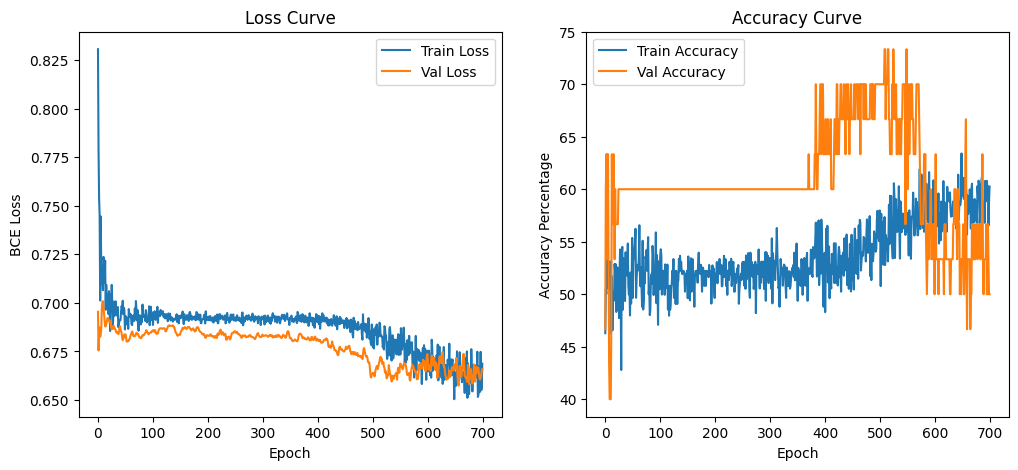

In [399]:
import matplotlib.pyplot as plt

train_loss = [r["loss"] for r in training_steps]
val_loss = [r["loss"] for r in validation_steps]

train_acc = [r["acc"] for r in training_steps]
val_acc = [r["acc"] for r in validation_steps]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy Percentage")
plt.legend()

In [400]:

test_metrics = test_step(
    model=model_01,
    dataloader=test_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device,
    validation=False
)
print(test_metrics)

Epoch Testing --> loss_avg=0.6931 , acc_avg=51.6667% :: time=0.12s
{'loss': 0.6930578110118707, 'acc': 51.666666666666664, 'time': 0.11597833299310878}
